In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Train ve test setlerini birleştir

In [83]:
train=pd.read_csv("C:/Users/kerem/Desktop/Programlama/Miuul/HousePrice/data/train.csv")
test=pd.read_csv("C:/Users/kerem/Desktop/Programlama/Miuul/HousePrice/data/test.csv")

df = pd.concat([train, test], ignore_index=False).reset_index()
df.head()

df=df.drop("index",axis=1)

Genel Resim

In [84]:
def check_df(dataframe):
    print("############## Shape ##############")
    print(dataframe.shape)
    print("############## Types ##############")
    print(dataframe.dtypes)
    print("############## Head ##############")
    print(dataframe.head(3))
    print("############## Tail ##############")
    print(dataframe.tail(3))
    print("############## NA ##############")
    print(dataframe.isnull().sum())
    print("############## Quantiles ##############")
    numeric_cols = dataframe.select_dtypes(include=["int64", "float64"]).columns
    print(dataframe[numeric_cols].quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)
check_df(df)

############## Shape ##############
(2919, 81)
############## Types ##############
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object
############## Head ##############
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   


Nümerik ve Kategorik Değişkenlerin Yakalanması

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


Kategorik Değişken Analizi

          MSZoning  Ratio
MSZoning                 
RL            2265 77.595
RM             460 15.759
FV             139  4.762
RH              26  0.891
C (all)         25  0.856


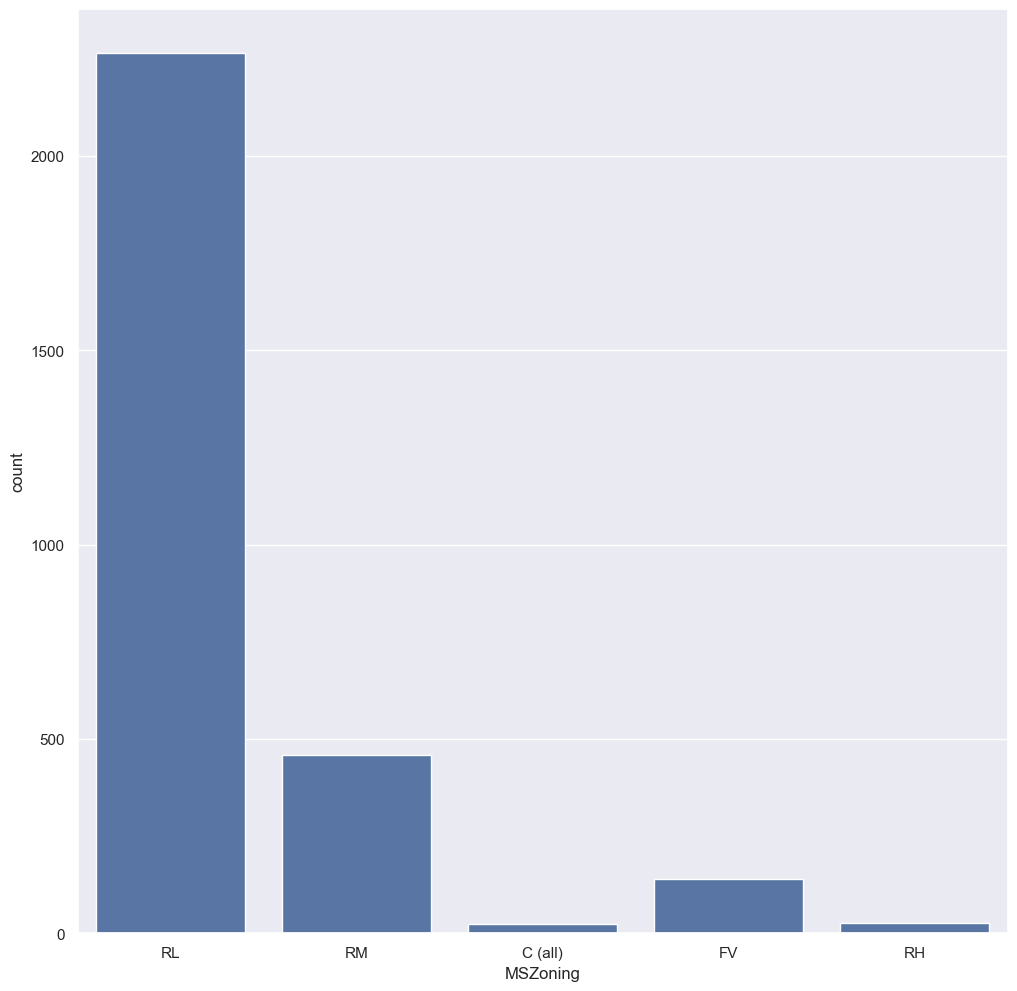

        Street  Ratio
Street               
Pave      2907 99.589
Grvl        12  0.411


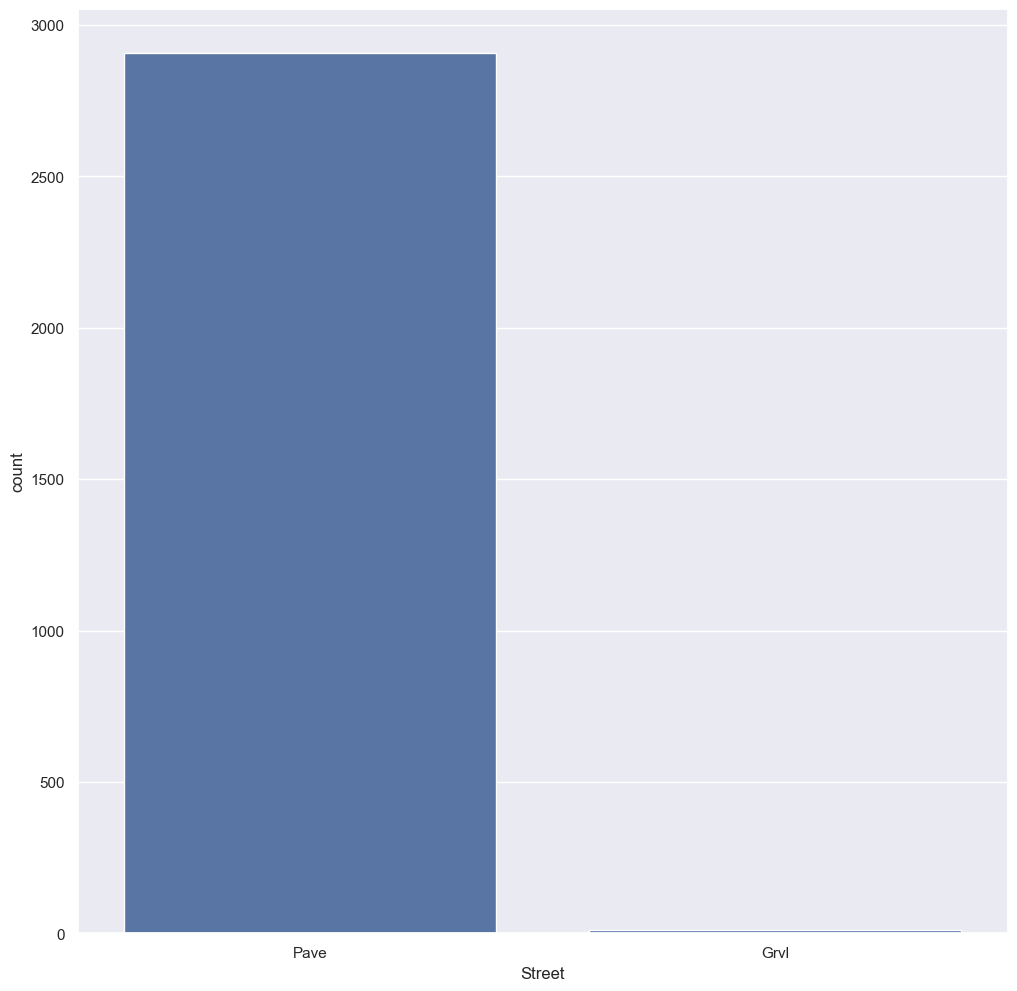

       Alley  Ratio
Alley              
Grvl     120  4.111
Pave      78  2.672


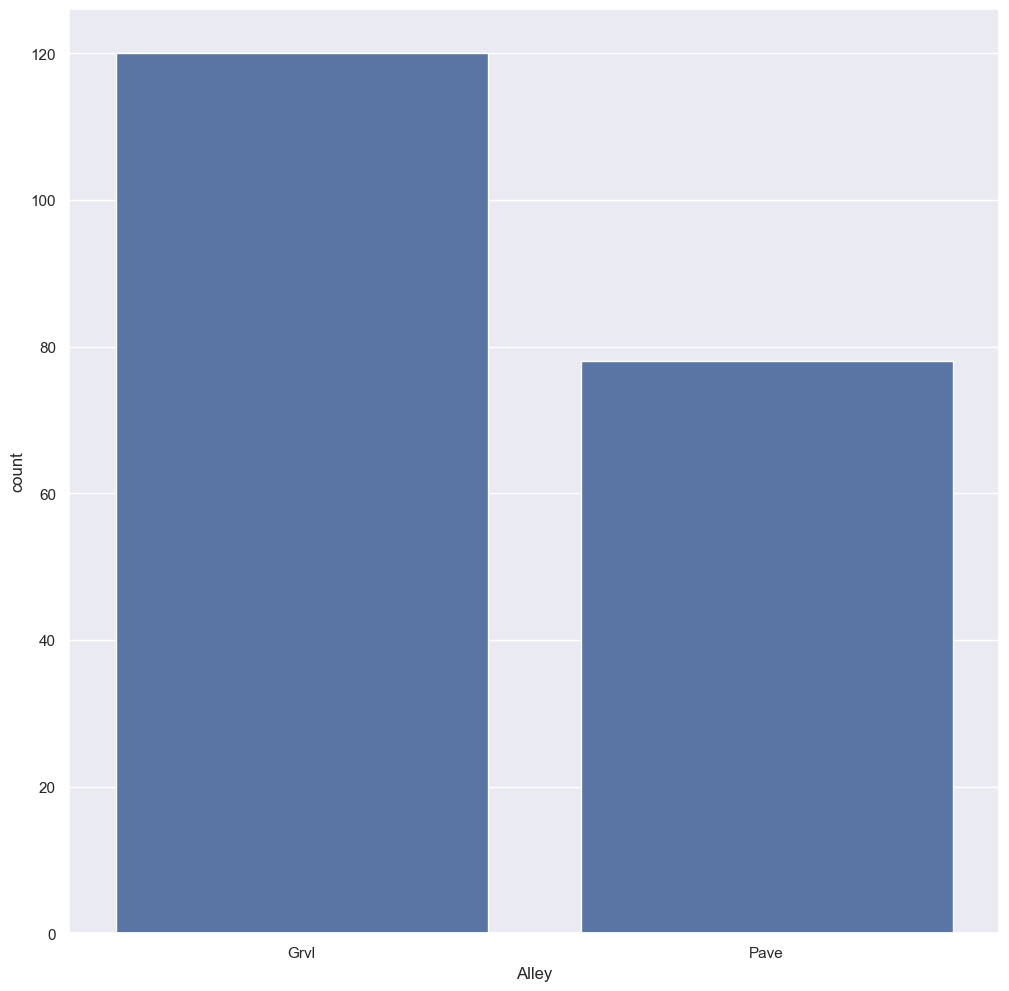

          LotShape  Ratio
LotShape                 
Reg           1859 63.686
IR1            968 33.162
IR2             76  2.604
IR3             16  0.548


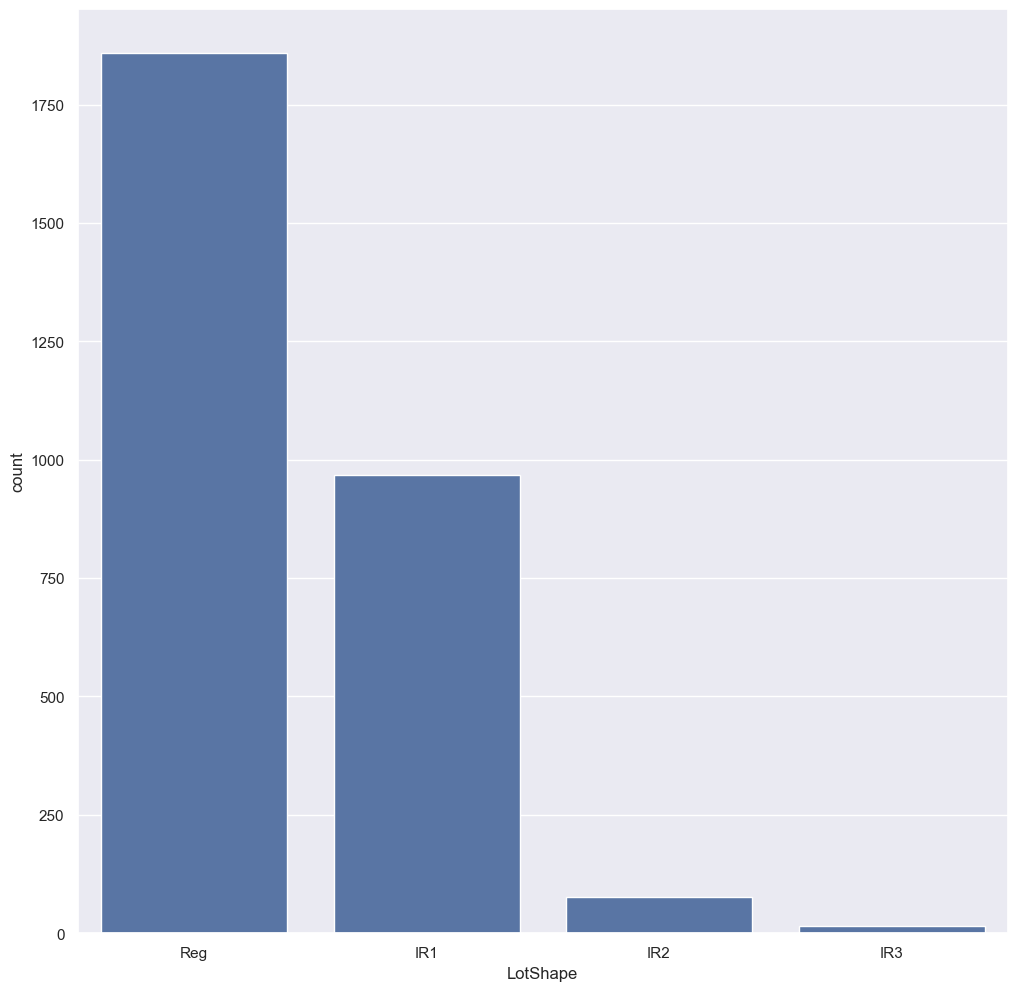

             LandContour  Ratio
LandContour                    
Lvl                 2622 89.825
HLS                  120  4.111
Bnk                  117  4.008
Low                   60  2.055


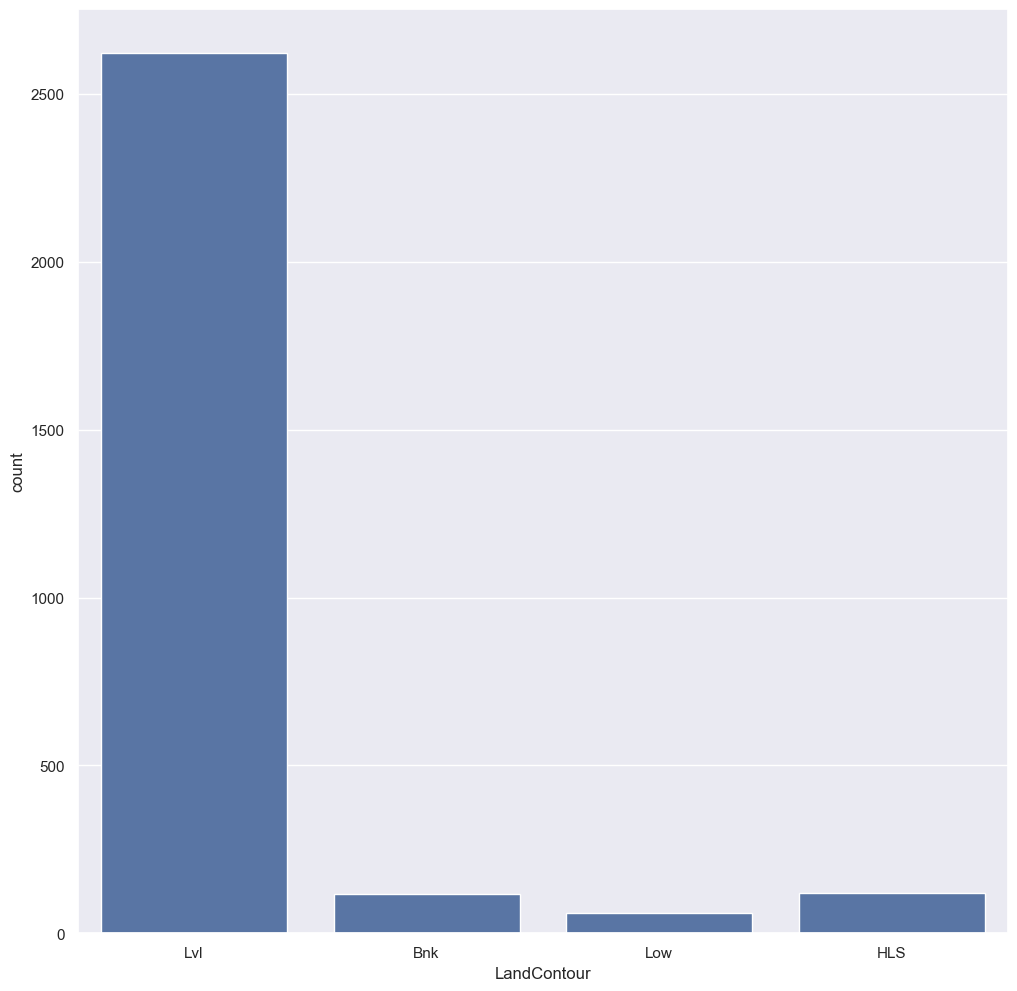

           Utilities  Ratio
Utilities                  
AllPub          2916 99.897
NoSeWa             1  0.034


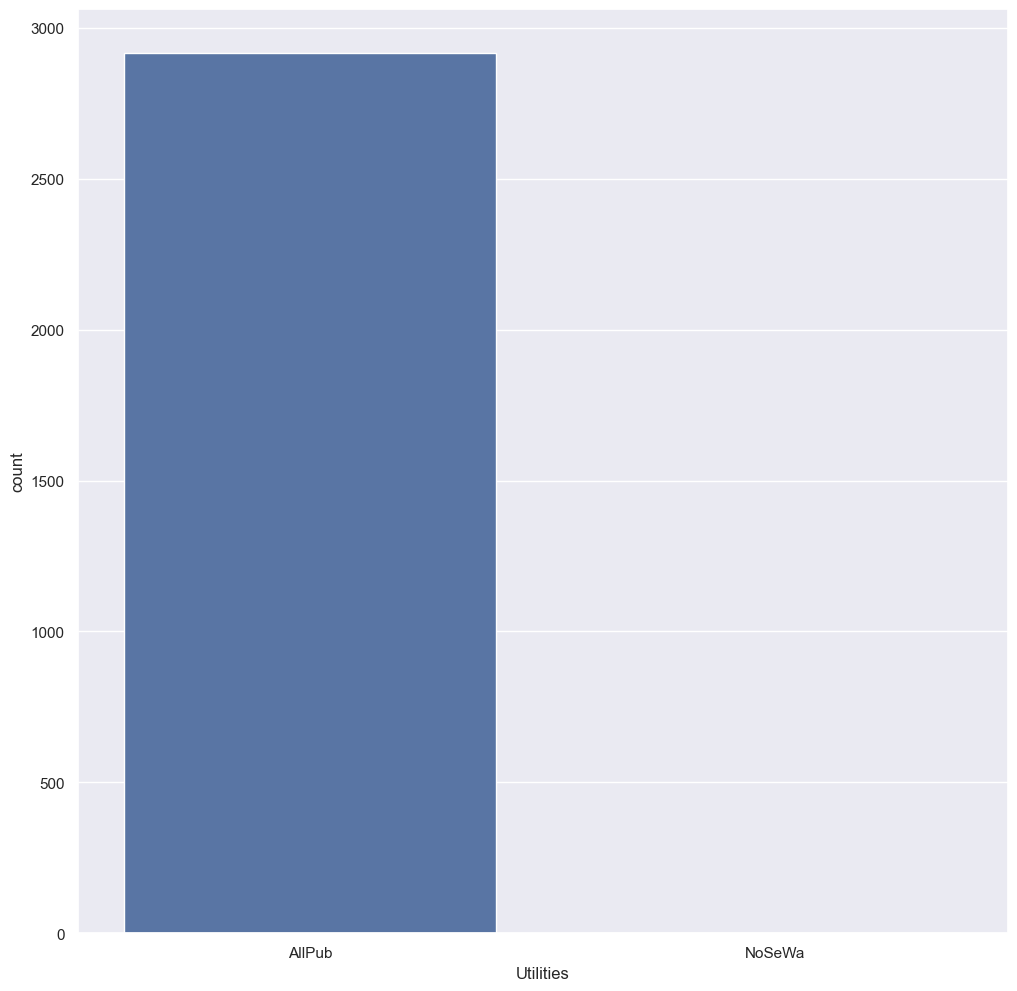

           LotConfig  Ratio
LotConfig                  
Inside          2133 73.073
Corner           511 17.506
CulDSac          176  6.029
FR2               85  2.912
FR3               14  0.480


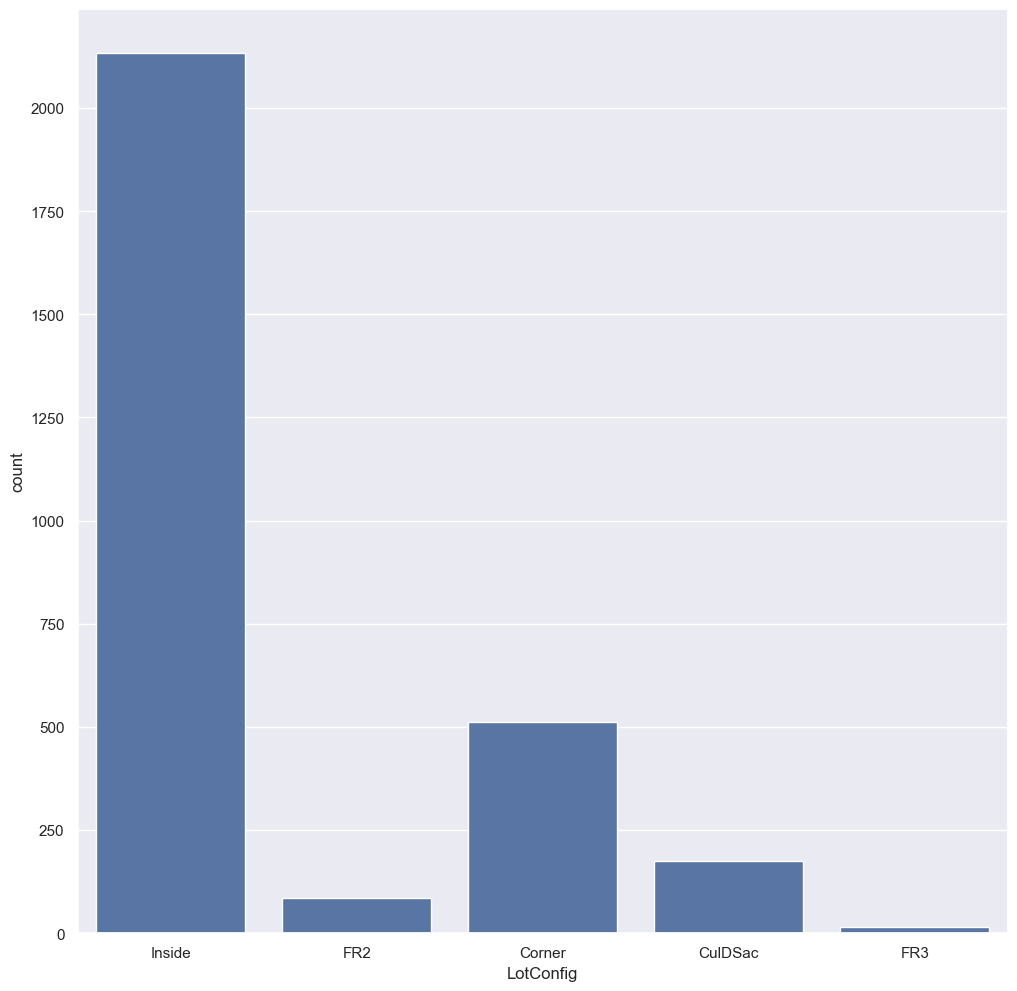

           LandSlope  Ratio
LandSlope                  
Gtl             2778 95.170
Mod              125  4.282
Sev               16  0.548


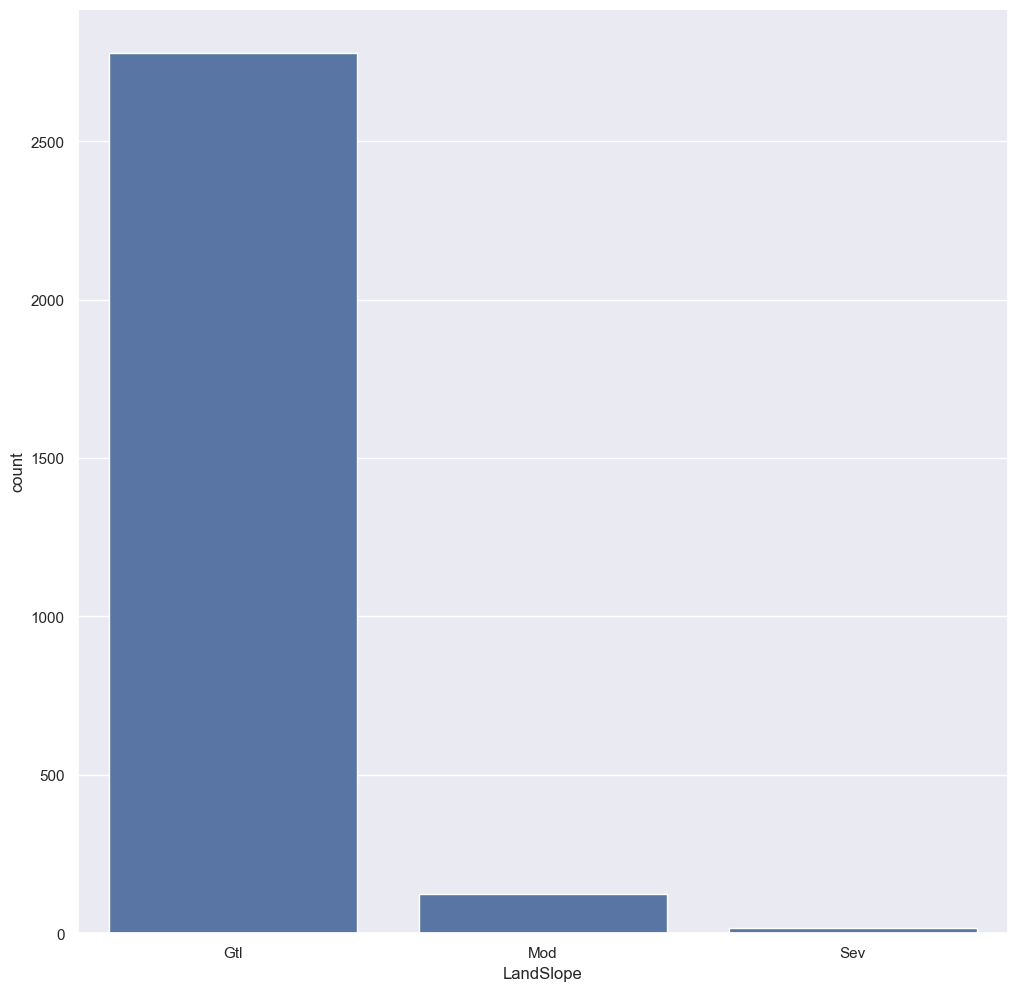

            Condition1  Ratio
Condition1                   
Norm              2511 86.023
Feedr              164  5.618
Artery              92  3.152
RRAn                50  1.713
PosN                39  1.336
RRAe                28  0.959
PosA                20  0.685
RRNn                 9  0.308
RRNe                 6  0.206


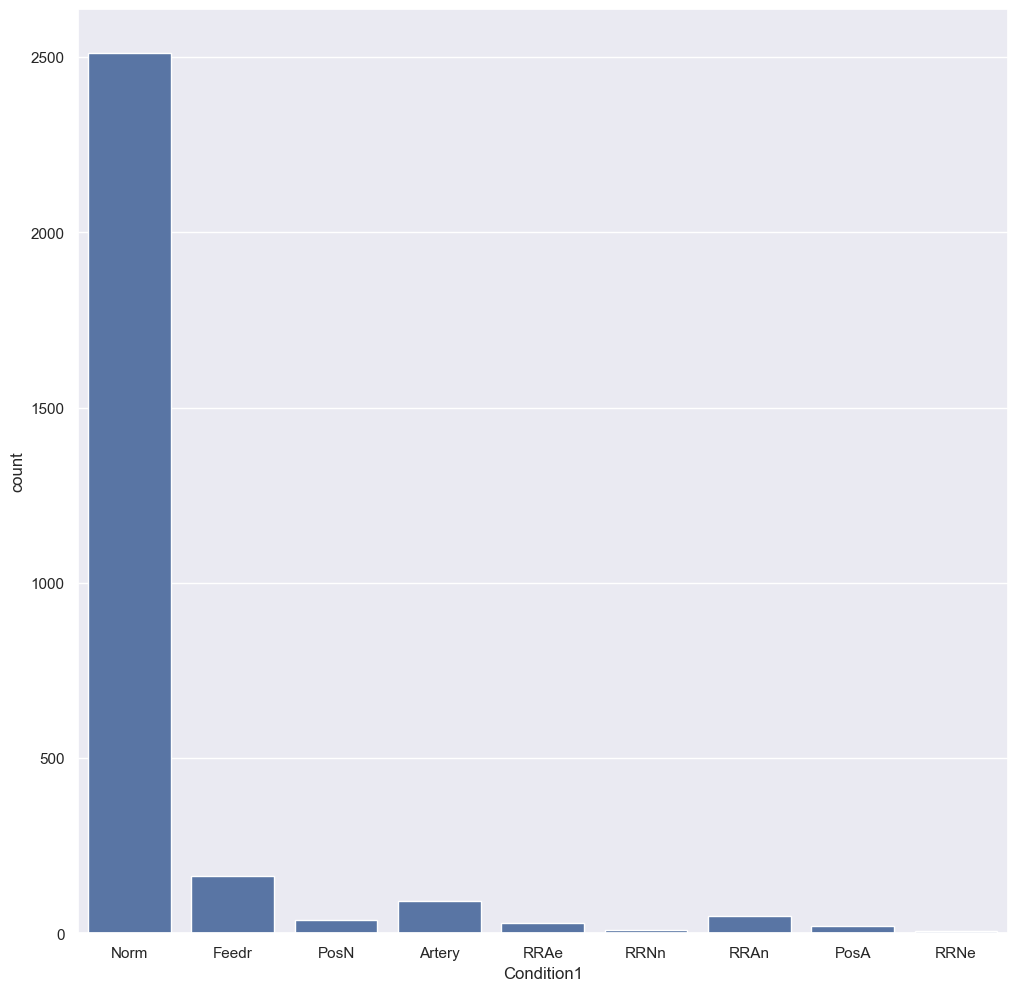

            Condition2  Ratio
Condition2                   
Norm              2889 98.972
Feedr               13  0.445
Artery               5  0.171
PosN                 4  0.137
PosA                 4  0.137
RRNn                 2  0.069
RRAn                 1  0.034
RRAe                 1  0.034


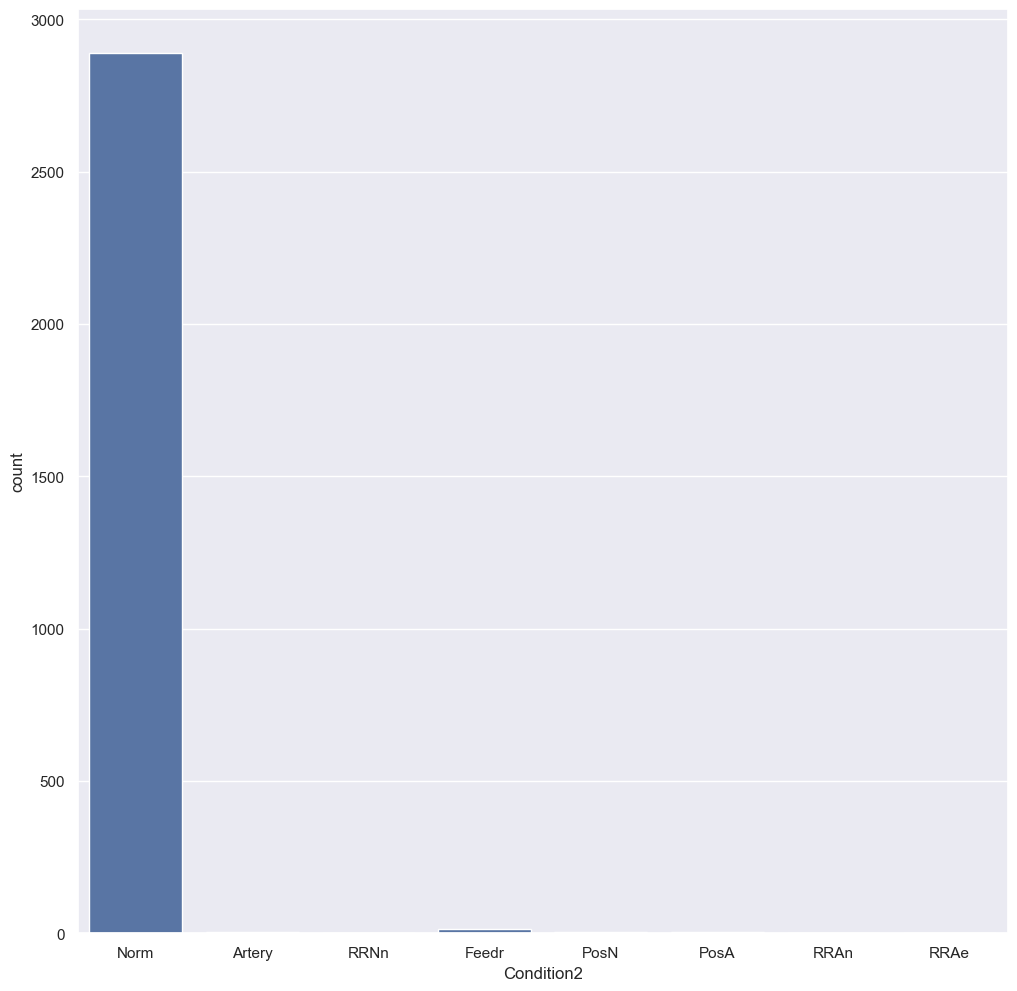

          BldgType  Ratio
BldgType                 
1Fam          2425 83.076
TwnhsE         227  7.777
Duplex         109  3.734
Twnhs           96  3.289
2fmCon          62  2.124


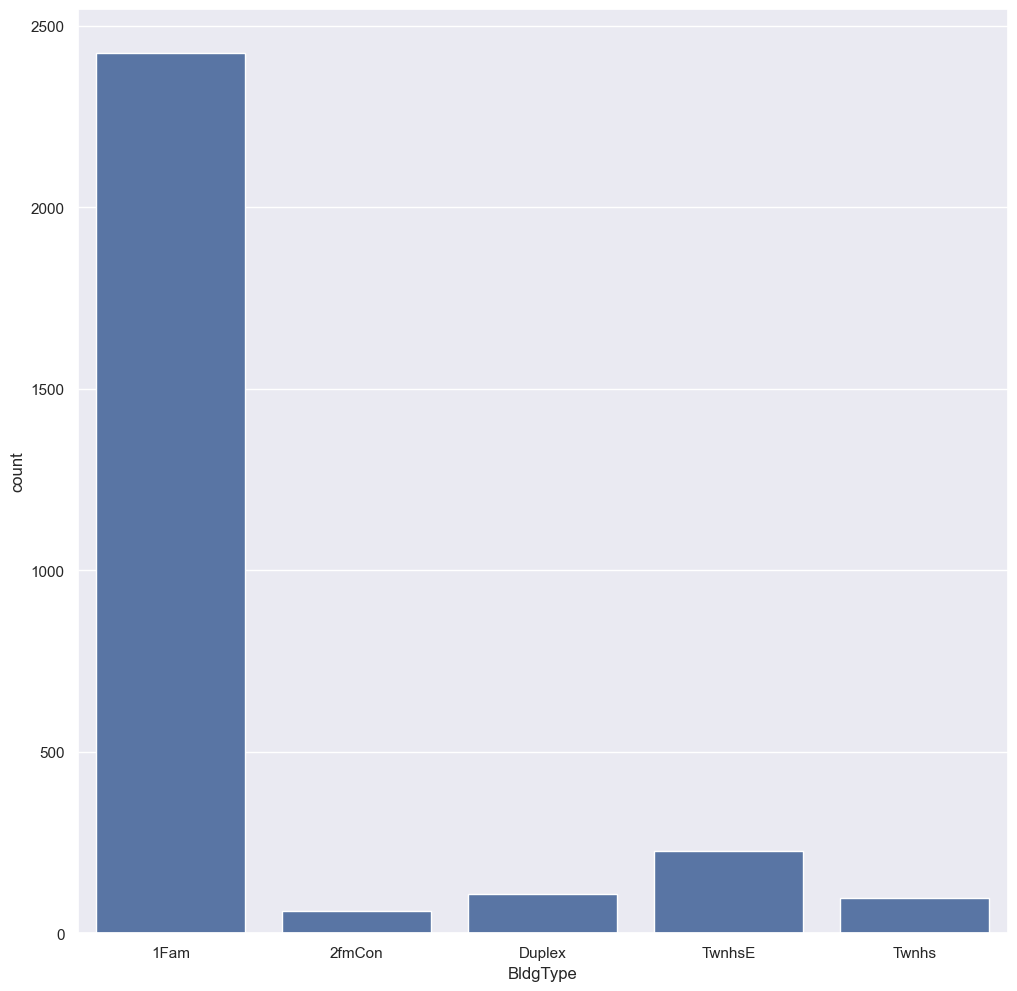

            HouseStyle  Ratio
HouseStyle                   
1Story            1471 50.394
2Story             872 29.873
1.5Fin             314 10.757
SLvl               128  4.385
SFoyer              83  2.843
2.5Unf              24  0.822
1.5Unf              19  0.651
2.5Fin               8  0.274


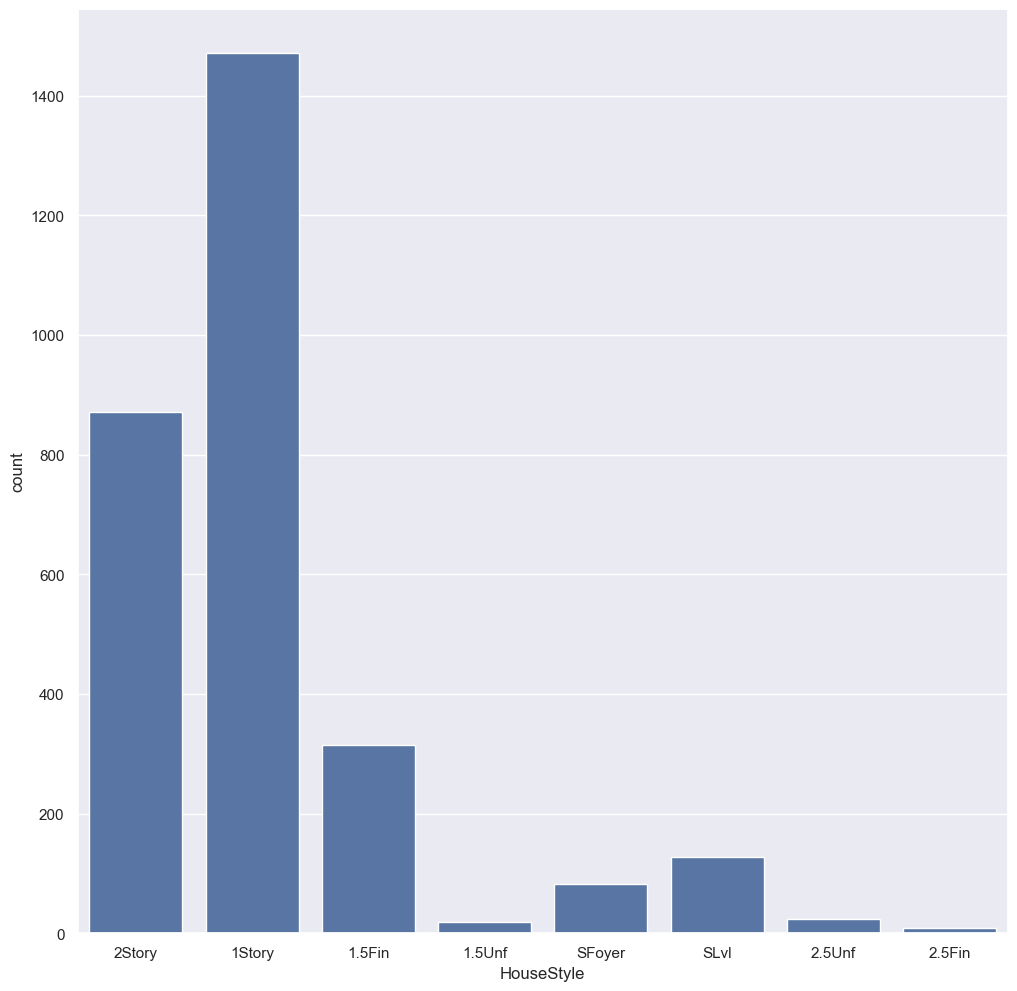

           RoofStyle  Ratio
RoofStyle                  
Gable           2310 79.137
Hip              551 18.876
Gambrel           22  0.754
Flat              20  0.685
Mansard           11  0.377
Shed               5  0.171


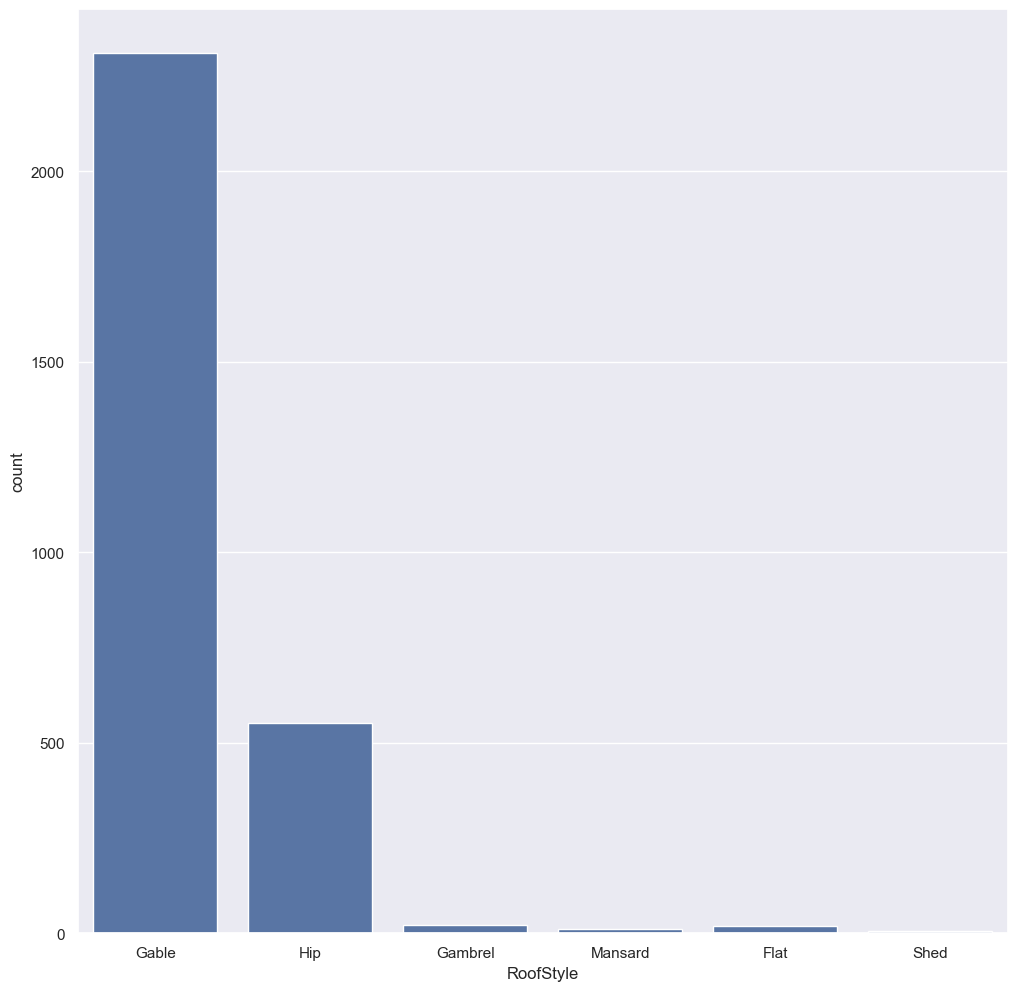

          RoofMatl  Ratio
RoofMatl                 
CompShg       2876 98.527
Tar&Grv         23  0.788
WdShake          9  0.308
WdShngl          7  0.240
Metal            1  0.034
Membran          1  0.034
Roll             1  0.034
ClyTile          1  0.034


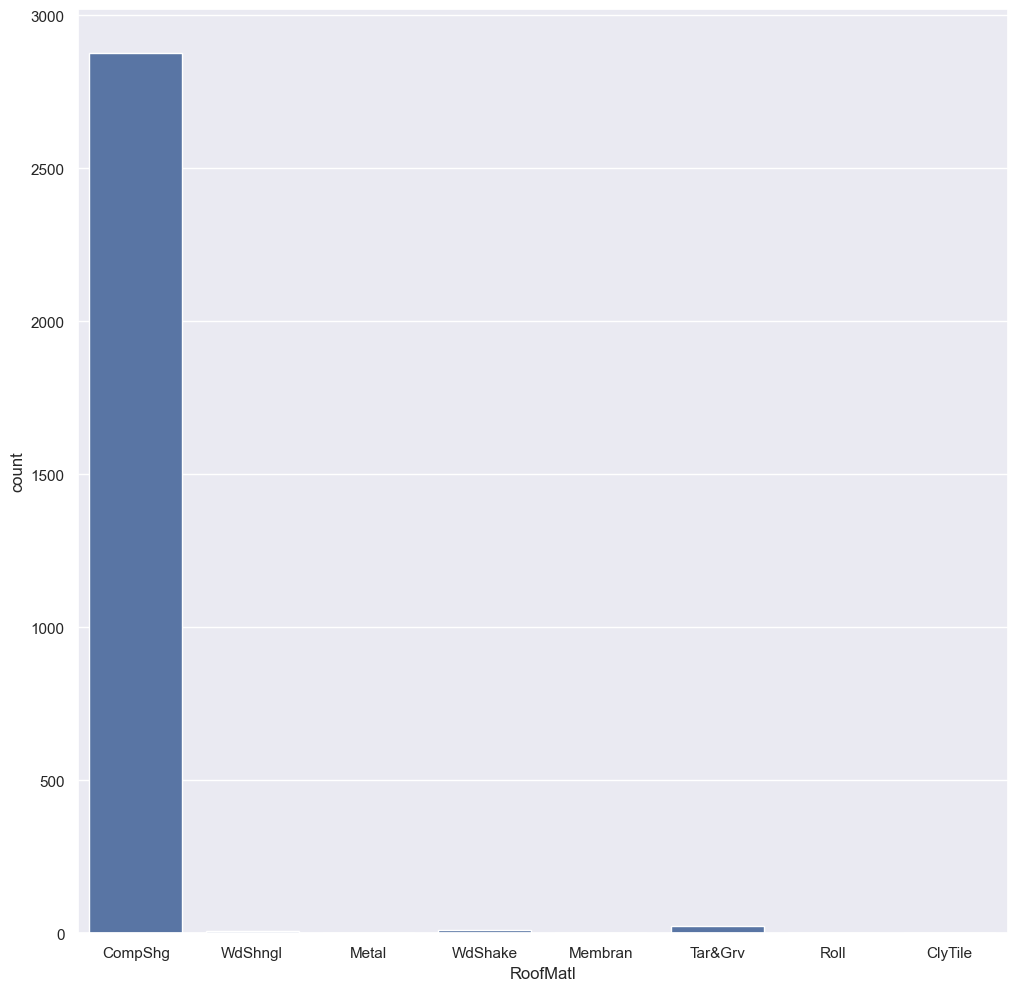

             Exterior1st  Ratio
Exterior1st                    
VinylSd             1025 35.115
MetalSd              450 15.416
HdBoard              442 15.142
Wd Sdng              411 14.080
Plywood              221  7.571
CemntBd              126  4.317
BrkFace               87  2.980
WdShing               56  1.918
AsbShng               44  1.507
Stucco                43  1.473
BrkComm                6  0.206
AsphShn                2  0.069
Stone                  2  0.069
CBlock                 2  0.069
ImStucc                1  0.034


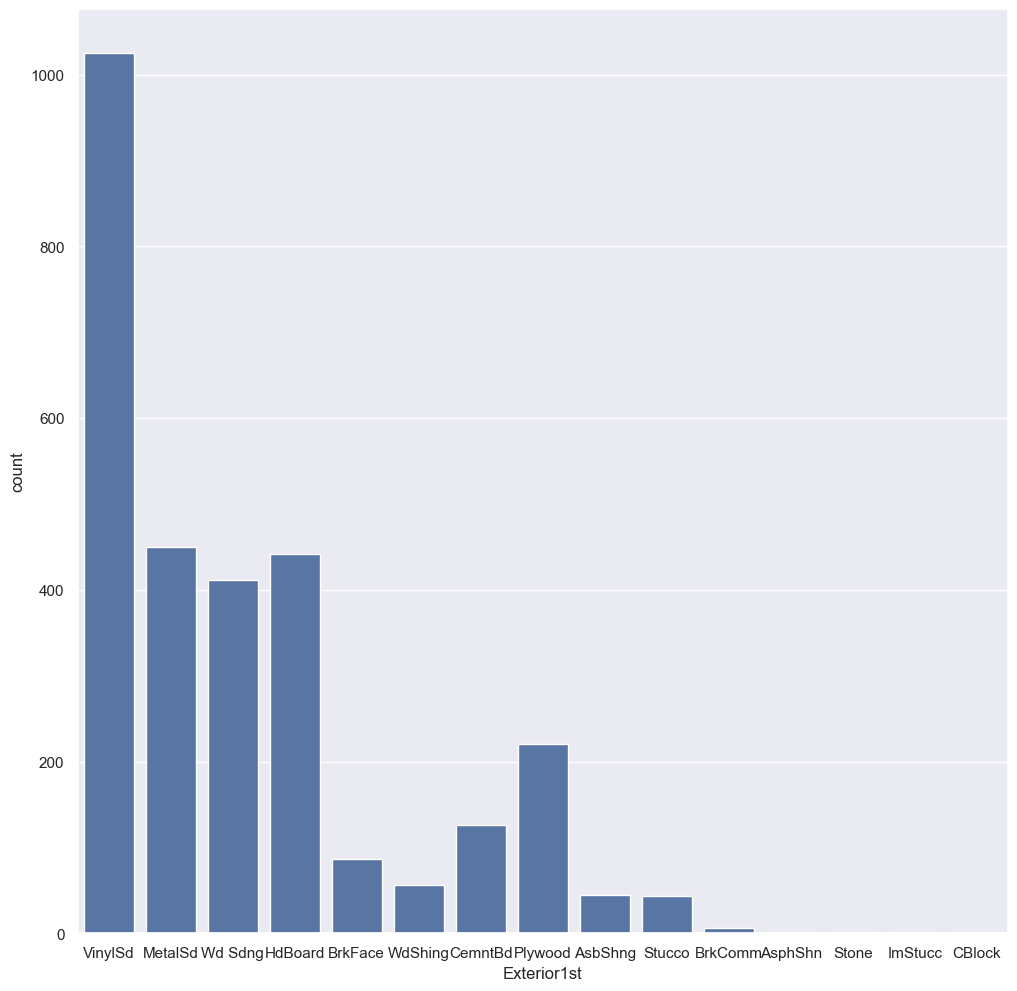

             Exterior2nd  Ratio
Exterior2nd                    
VinylSd             1014 34.738
MetalSd              447 15.313
HdBoard              406 13.909
Wd Sdng              391 13.395
Plywood              270  9.250
CmentBd              126  4.317
Wd Shng               81  2.775
BrkFace               47  1.610
Stucco                47  1.610
AsbShng               38  1.302
Brk Cmn               22  0.754
ImStucc               15  0.514
Stone                  6  0.206
AsphShn                4  0.137
CBlock                 3  0.103
Other                  1  0.034


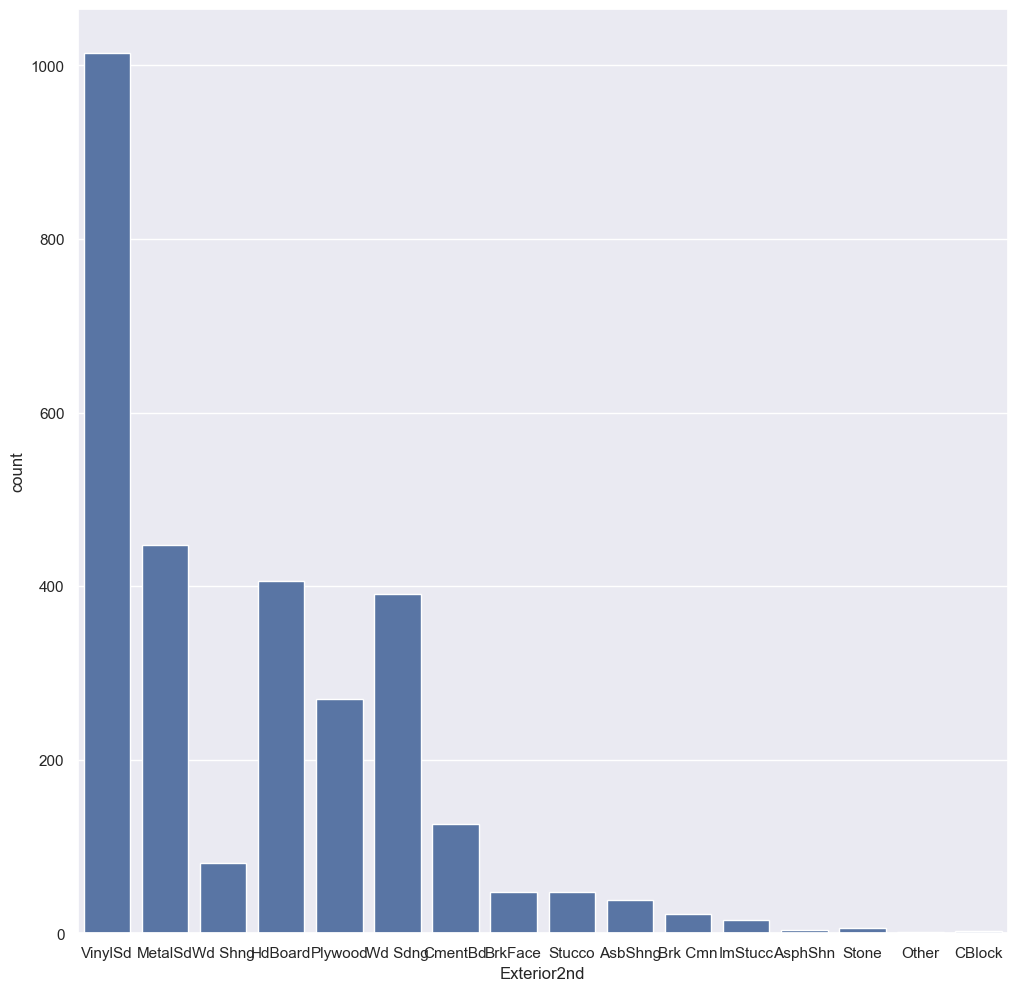

            MasVnrType  Ratio
MasVnrType                   
BrkFace            879 30.113
Stone              249  8.530
BrkCmn              25  0.856


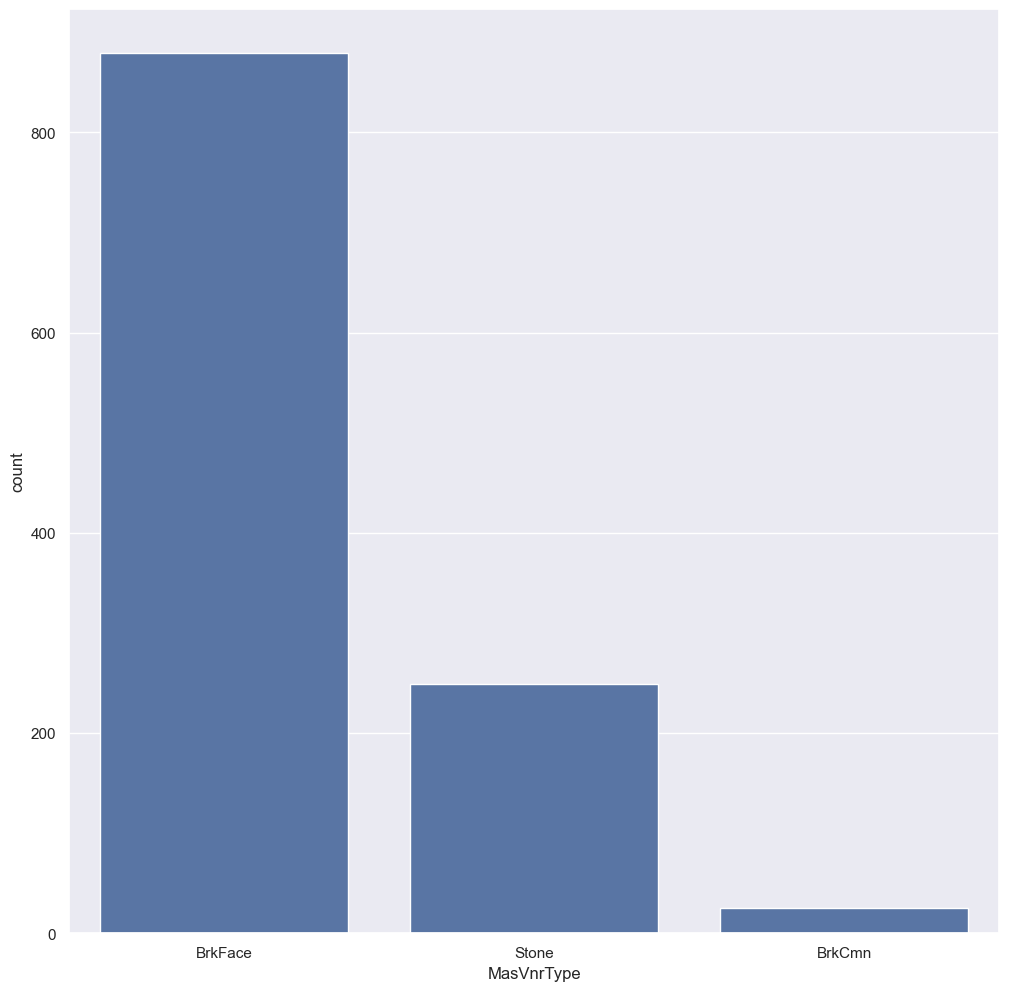

           ExterQual  Ratio
ExterQual                  
TA              1798 61.596
Gd               979 33.539
Ex               107  3.666
Fa                35  1.199


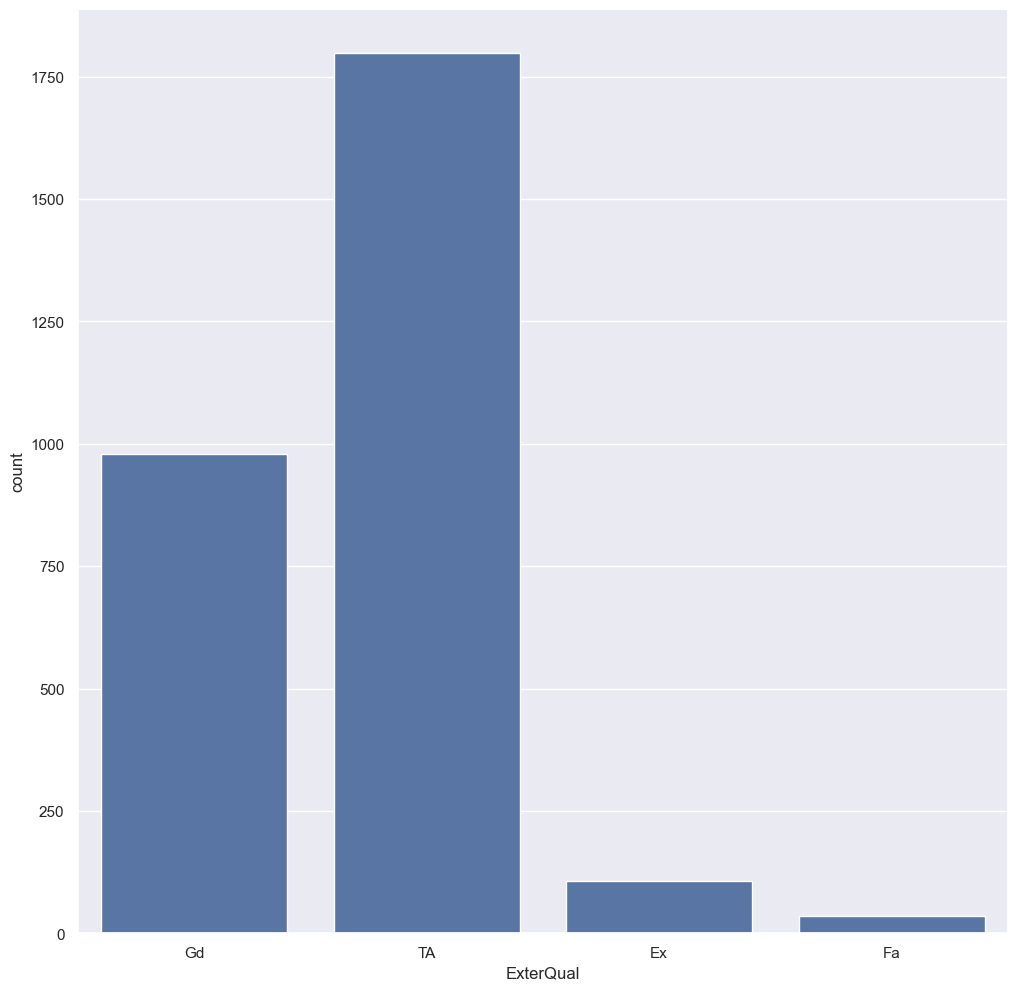

           ExterCond  Ratio
ExterCond                  
TA              2538 86.948
Gd               299 10.243
Fa                67  2.295
Ex                12  0.411
Po                 3  0.103


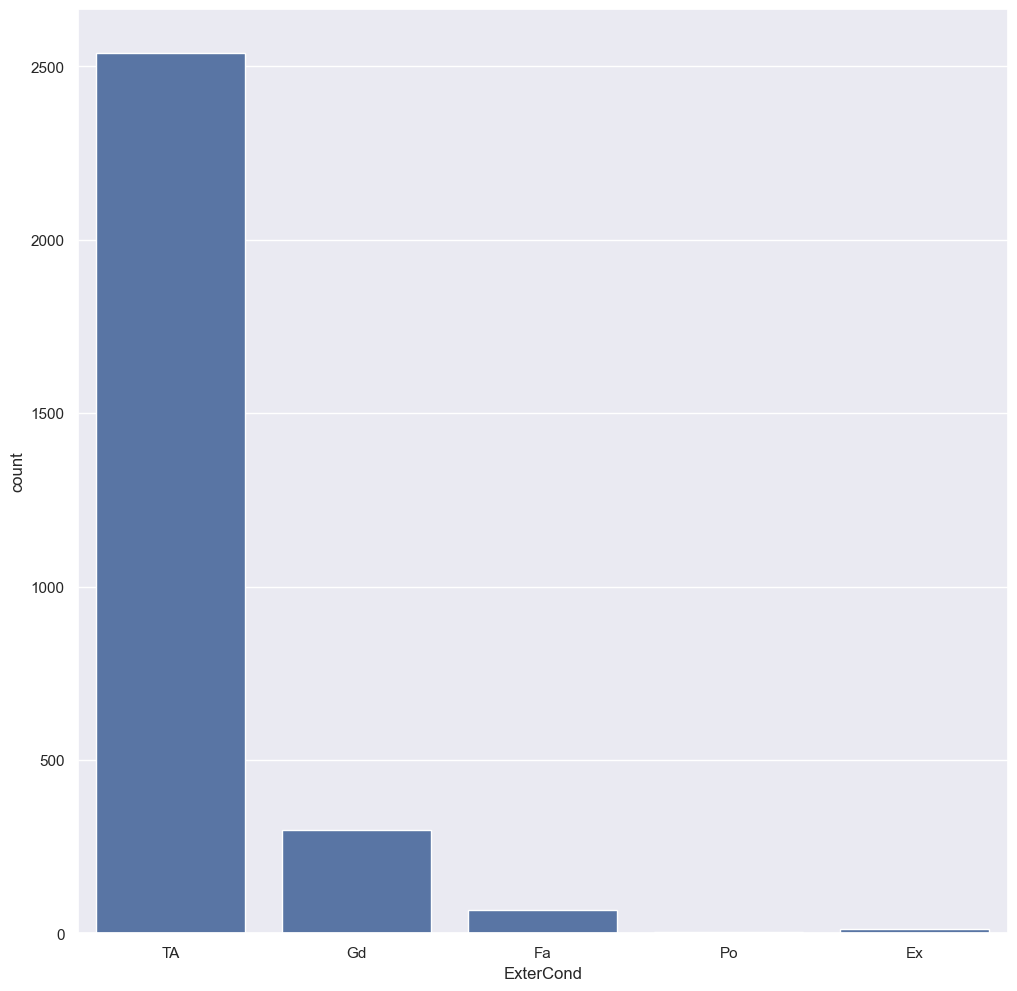

            Foundation  Ratio
Foundation                   
PConc             1308 44.810
CBlock            1235 42.309
BrkTil             311 10.654
Slab                49  1.679
Stone               11  0.377
Wood                 5  0.171


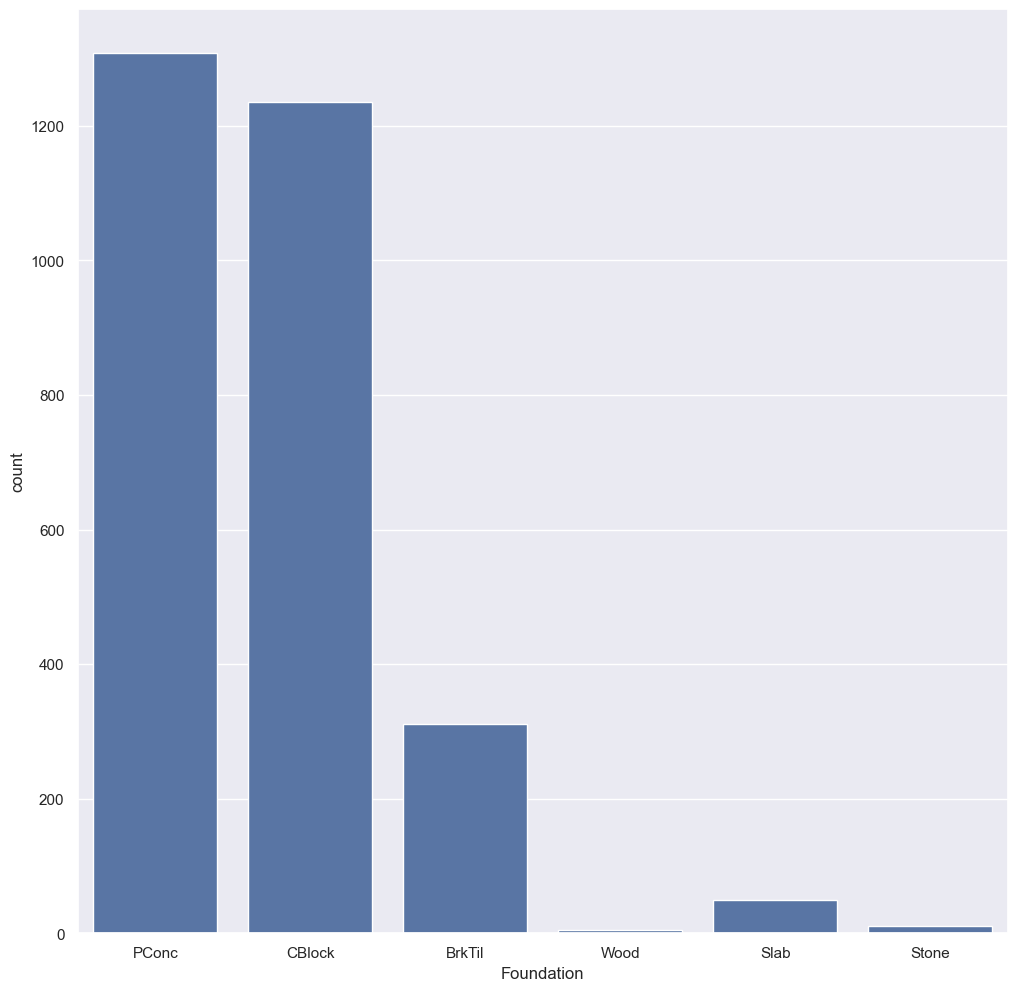

          BsmtQual  Ratio
BsmtQual                 
TA            1283 43.953
Gd            1209 41.418
Ex             258  8.839
Fa              88  3.015


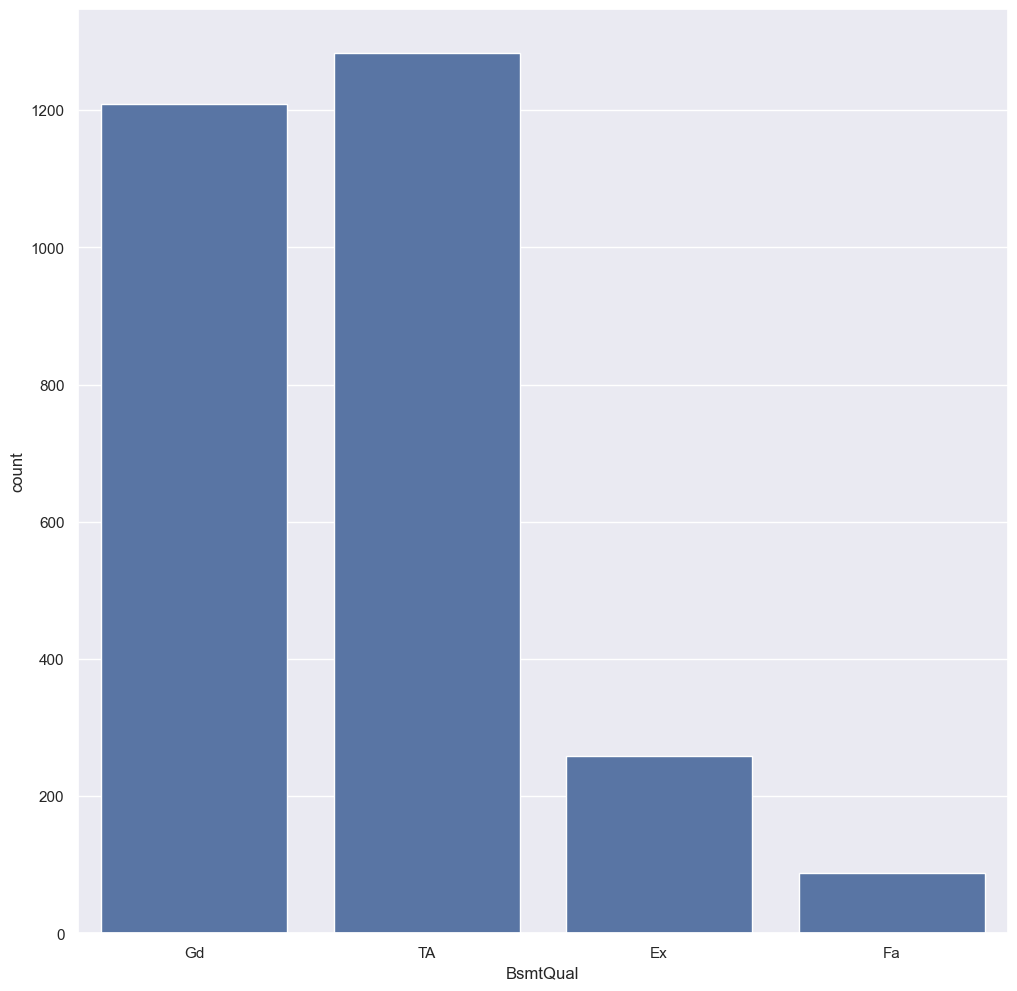

          BsmtCond  Ratio
BsmtCond                 
TA            2606 89.277
Gd             122  4.180
Fa             104  3.563
Po               5  0.171


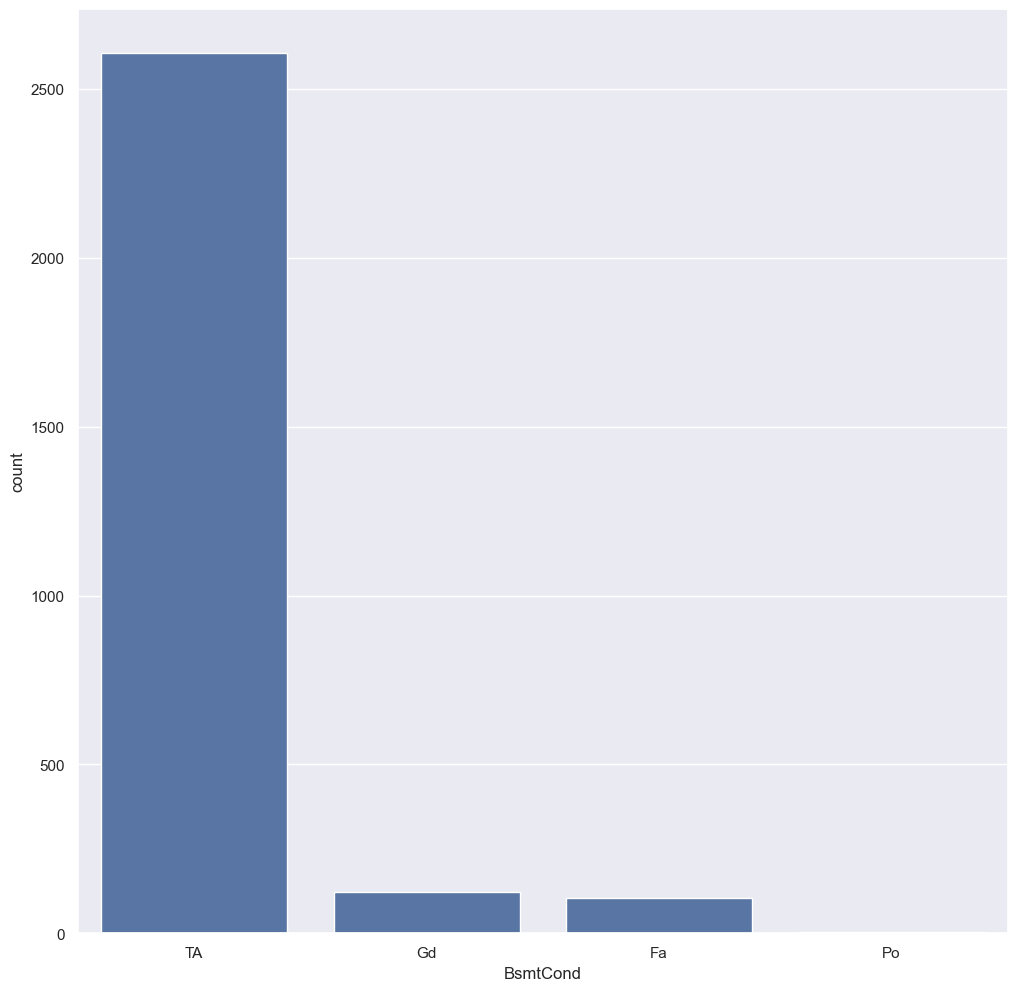

              BsmtExposure  Ratio
BsmtExposure                     
No                    1904 65.228
Av                     418 14.320
Gd                     276  9.455
Mn                     239  8.188


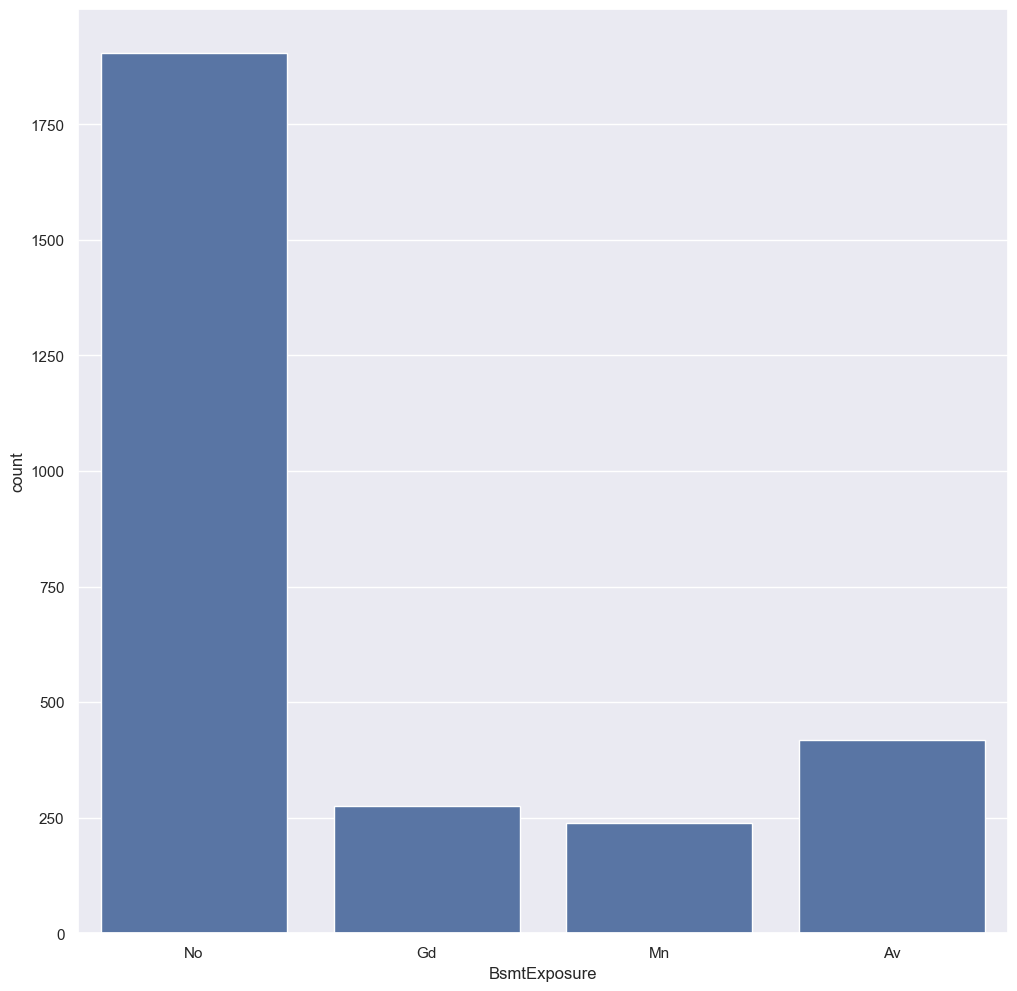

              BsmtFinType1  Ratio
BsmtFinType1                     
Unf                    851 29.154
GLQ                    849 29.085
ALQ                    429 14.697
Rec                    288  9.866
BLQ                    269  9.215
LwQ                    154  5.276


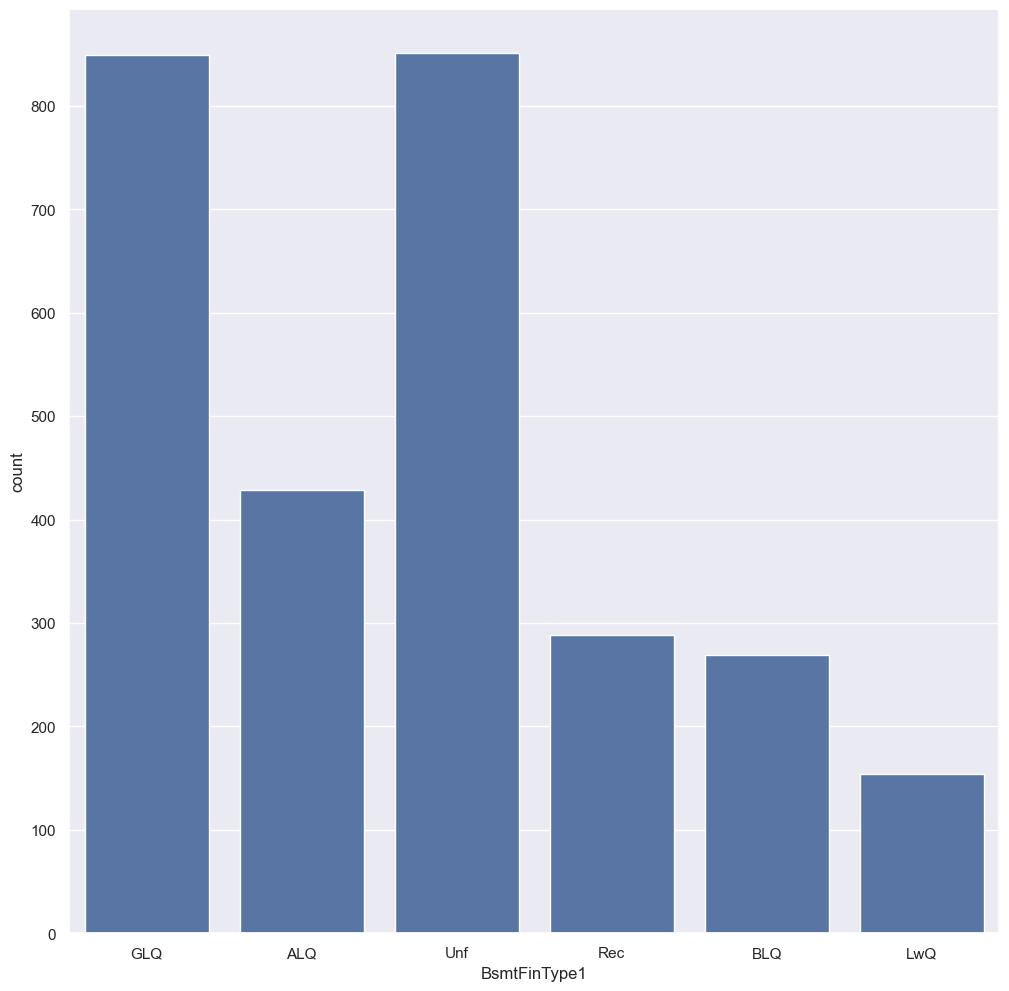

              BsmtFinType2  Ratio
BsmtFinType2                     
Unf                   2493 85.406
Rec                    105  3.597
LwQ                     87  2.980
BLQ                     68  2.330
ALQ                     52  1.781
GLQ                     34  1.165


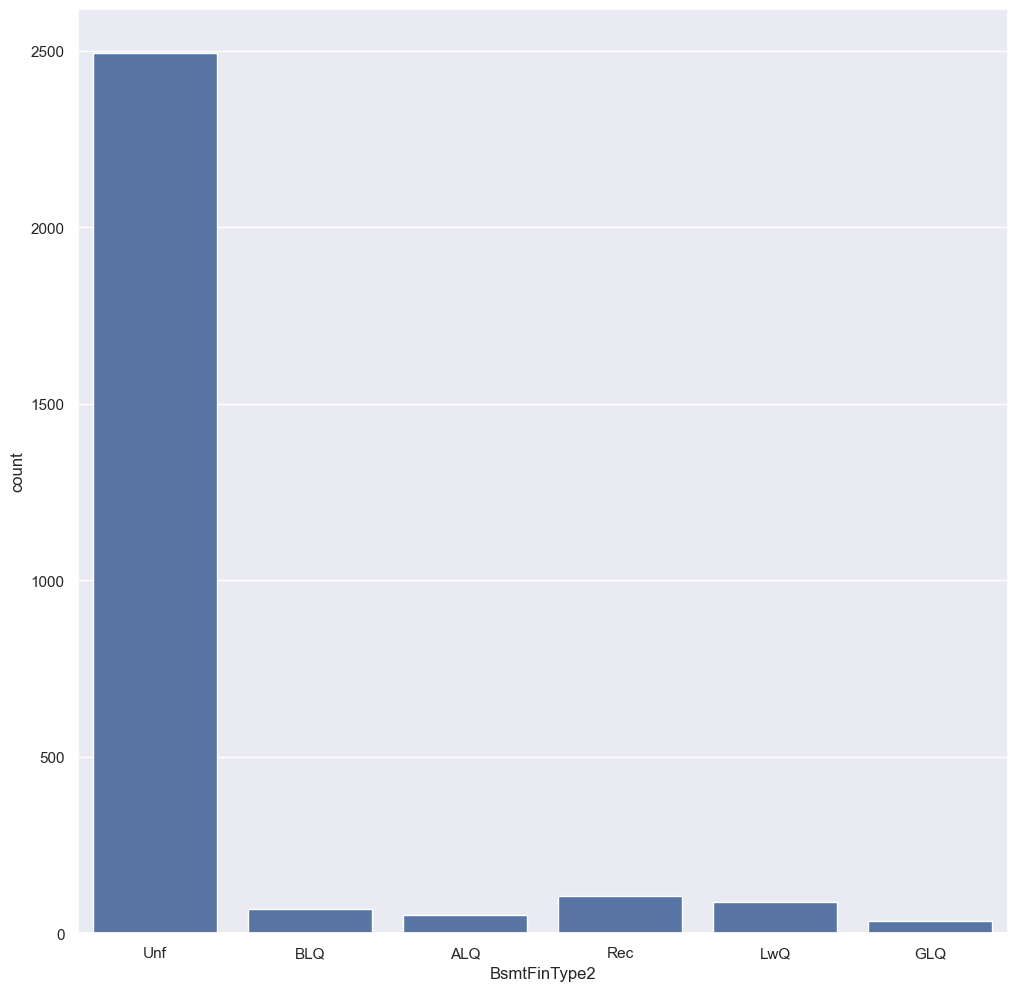

         Heating  Ratio
Heating                
GasA        2874 98.458
GasW          27  0.925
Grav           9  0.308
Wall           6  0.206
OthW           2  0.069
Floor          1  0.034


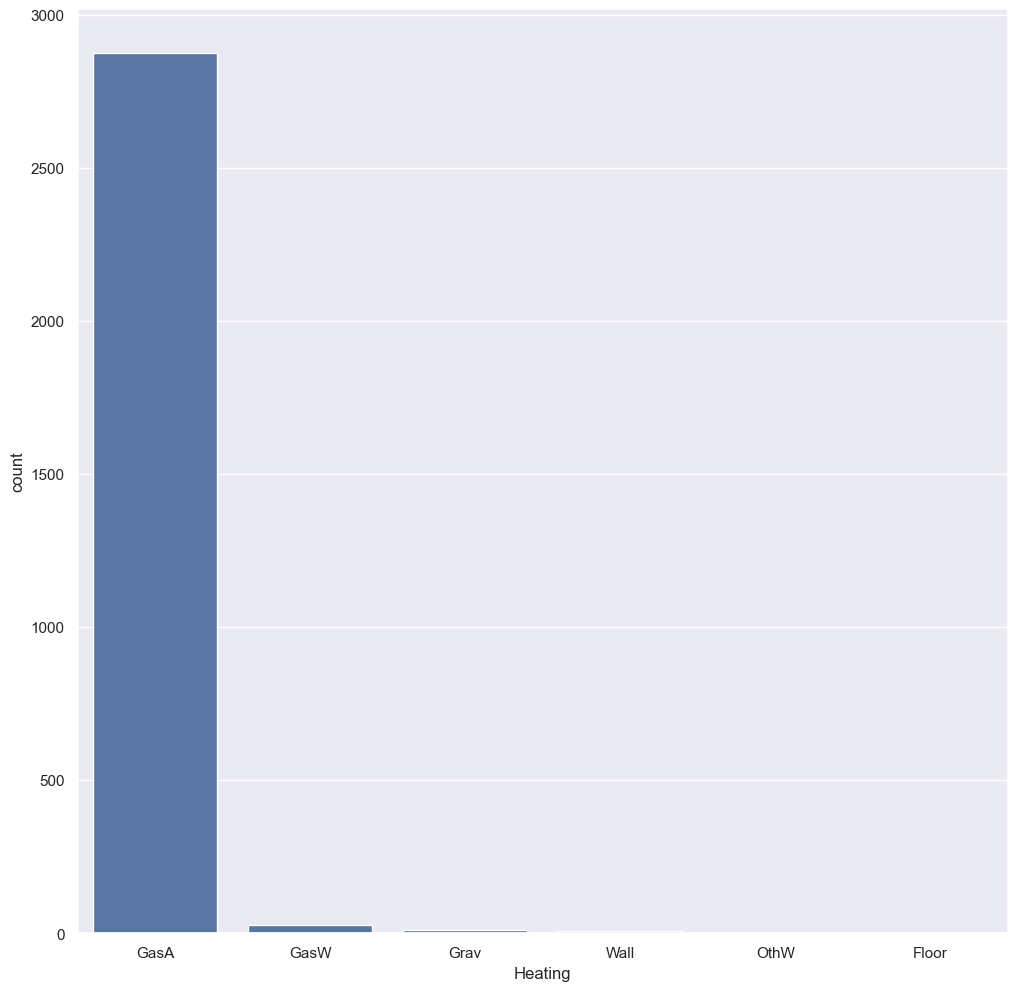

           HeatingQC  Ratio
HeatingQC                  
Ex              1493 51.148
TA               857 29.359
Gd               474 16.238
Fa                92  3.152
Po                 3  0.103


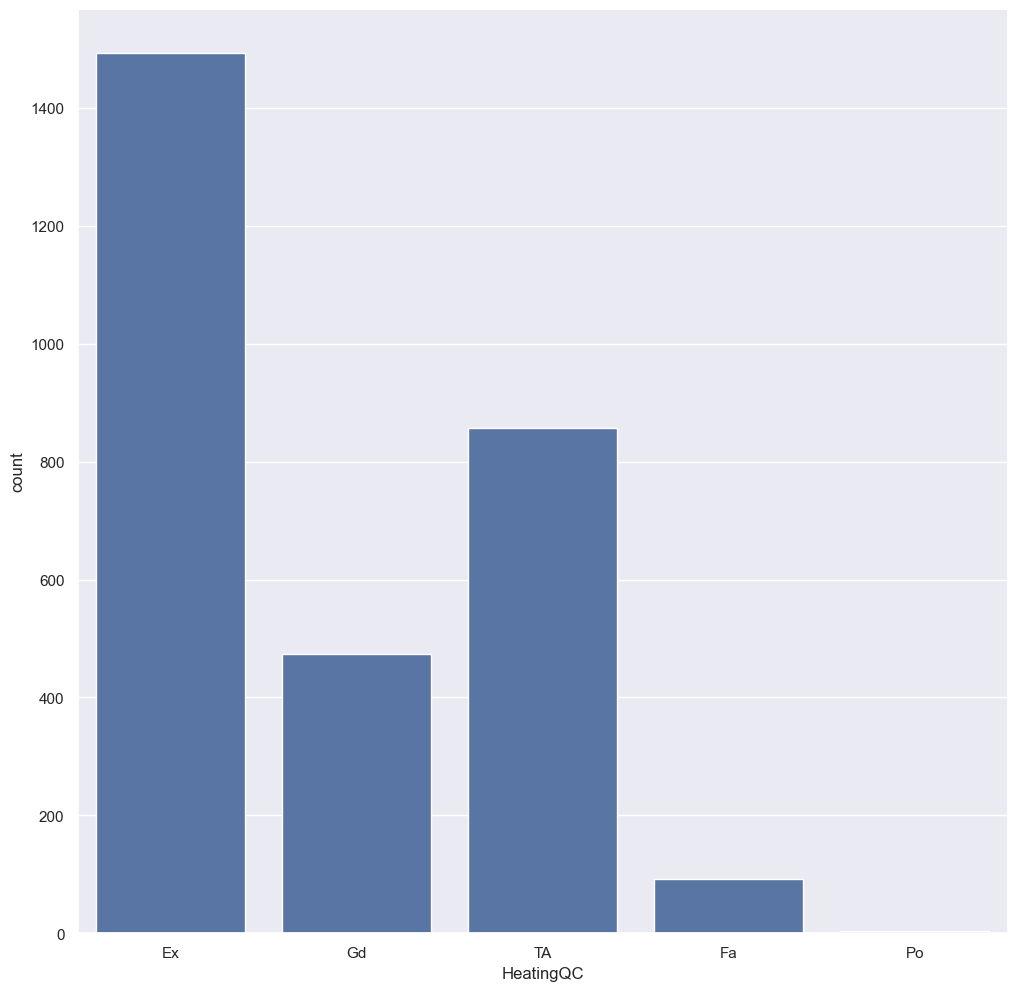

            CentralAir  Ratio
CentralAir                   
Y                 2723 93.285
N                  196  6.715


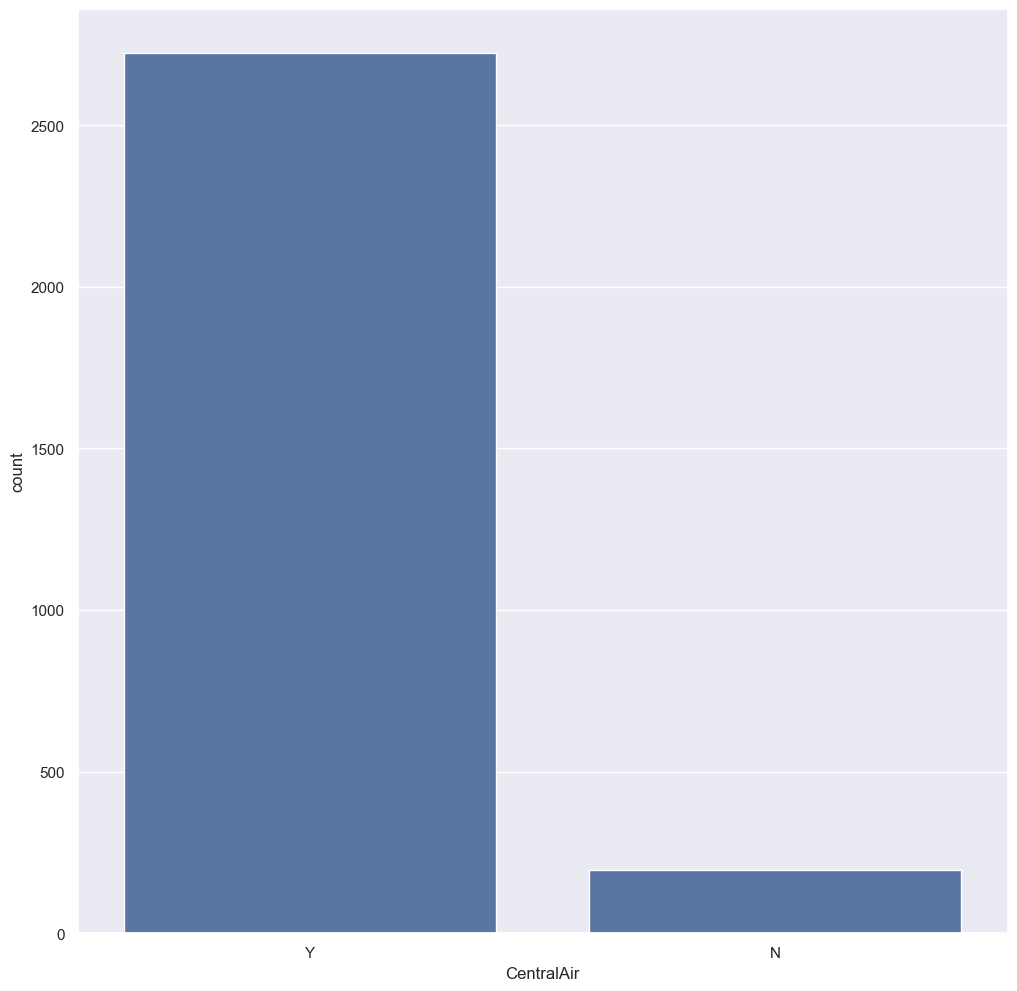

            Electrical  Ratio
Electrical                   
SBrkr             2671 91.504
FuseA              188  6.441
FuseF               50  1.713
FuseP                8  0.274
Mix                  1  0.034


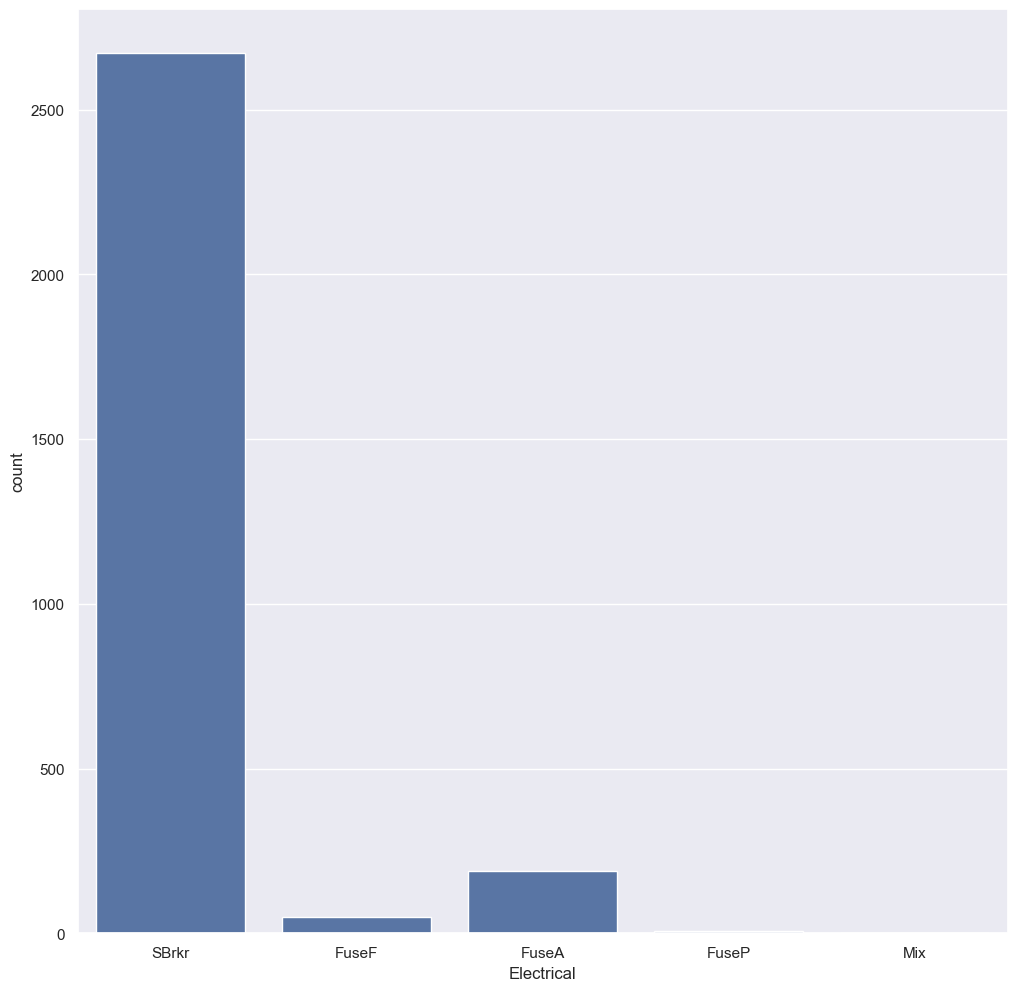

             KitchenQual  Ratio
KitchenQual                    
TA                  1492 51.113
Gd                  1151 39.431
Ex                   205  7.023
Fa                    70  2.398


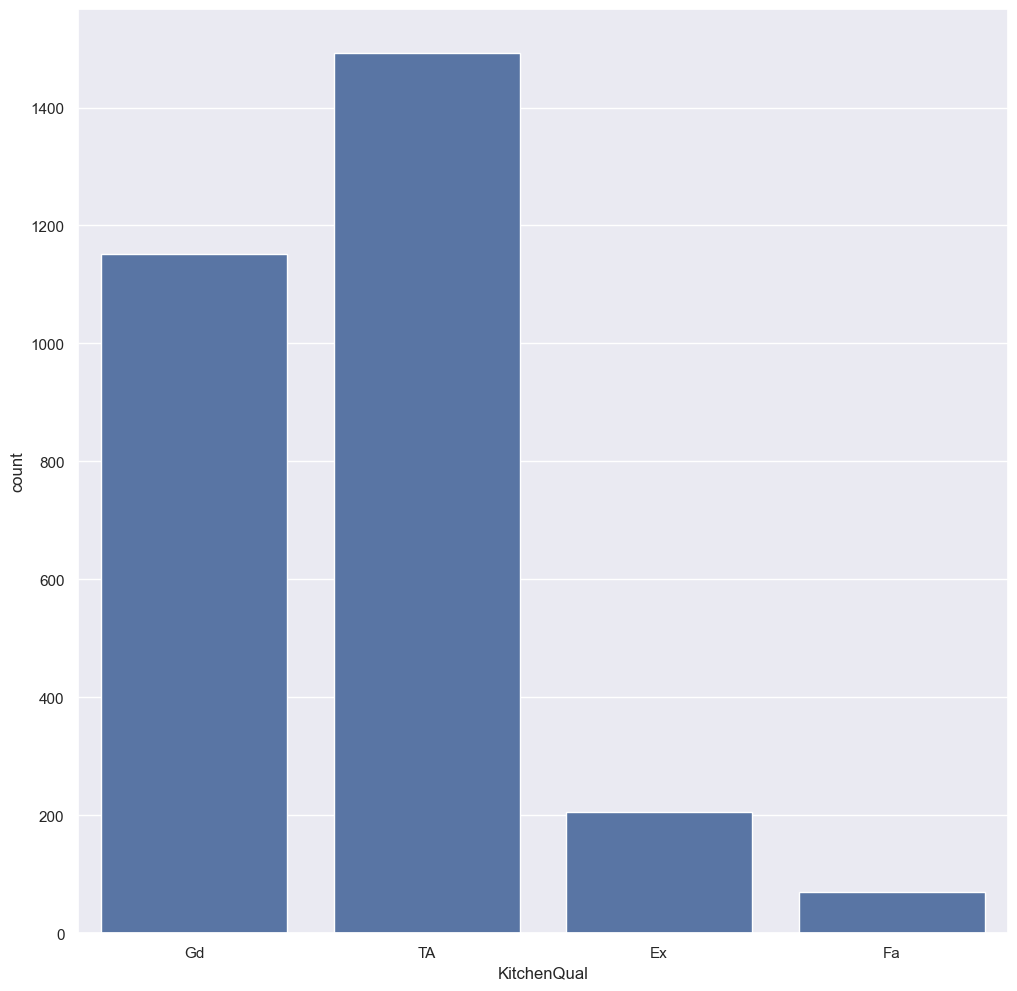

            Functional  Ratio
Functional                   
Typ               2717 93.080
Min2                70  2.398
Min1                65  2.227
Mod                 35  1.199
Maj1                19  0.651
Maj2                 9  0.308
Sev                  2  0.069


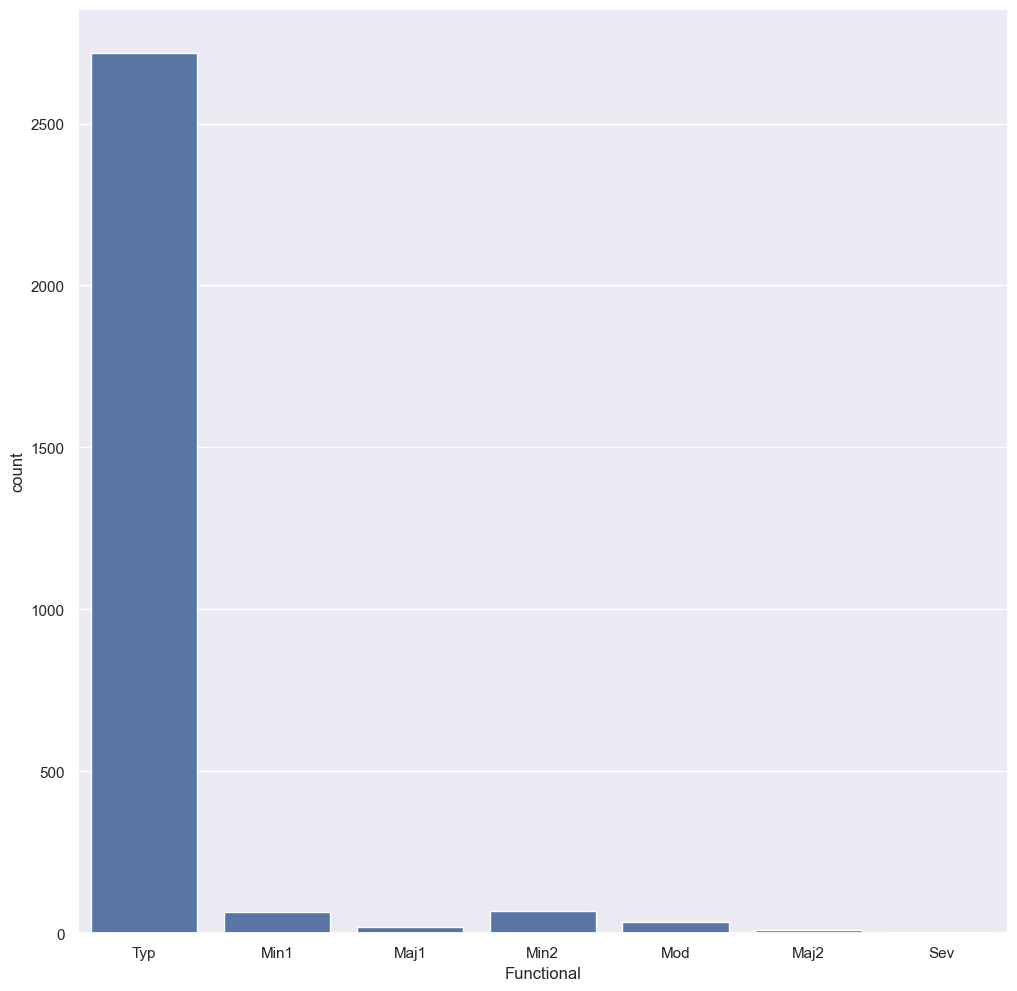

             FireplaceQu  Ratio
FireplaceQu                    
Gd                   744 25.488
TA                   592 20.281
Fa                    74  2.535
Po                    46  1.576
Ex                    43  1.473


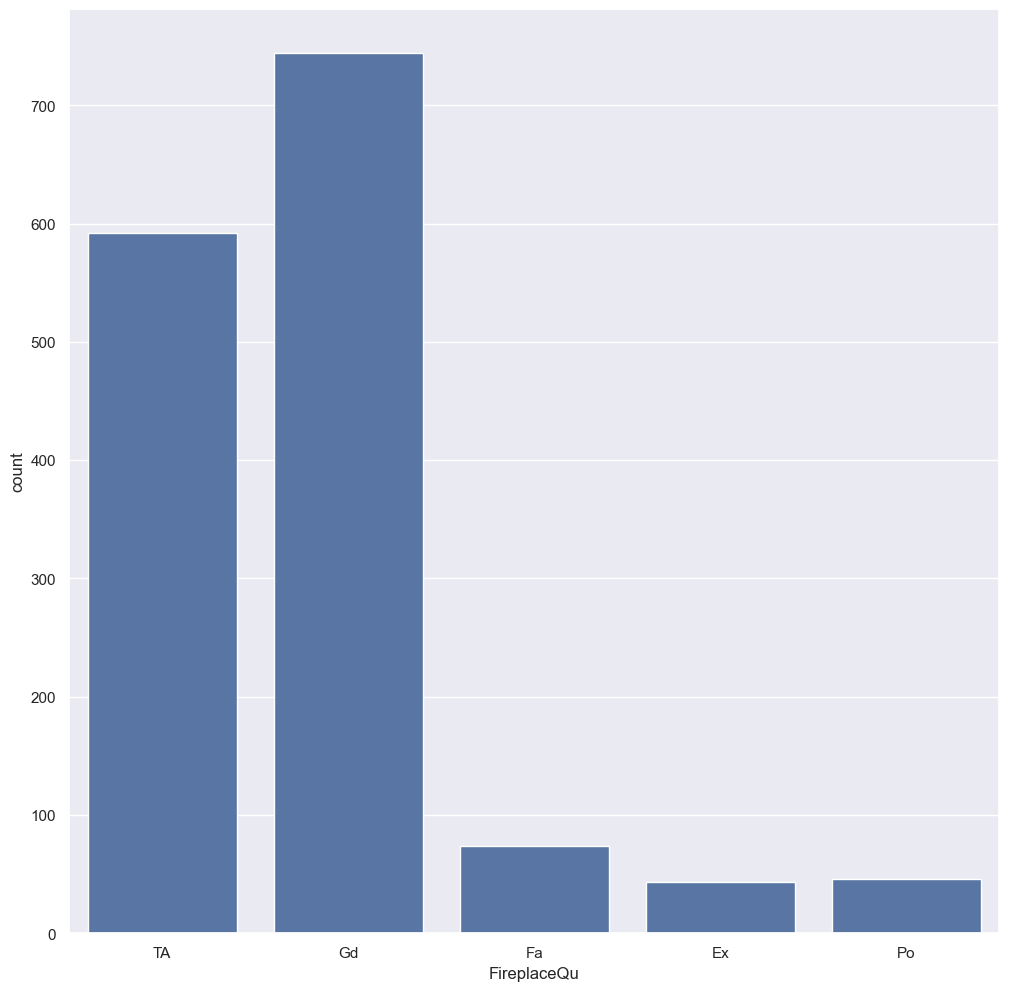

            GarageType  Ratio
GarageType                   
Attchd            1723 59.027
Detchd             779 26.687
BuiltIn            186  6.372
Basment             36  1.233
2Types              23  0.788
CarPort             15  0.514


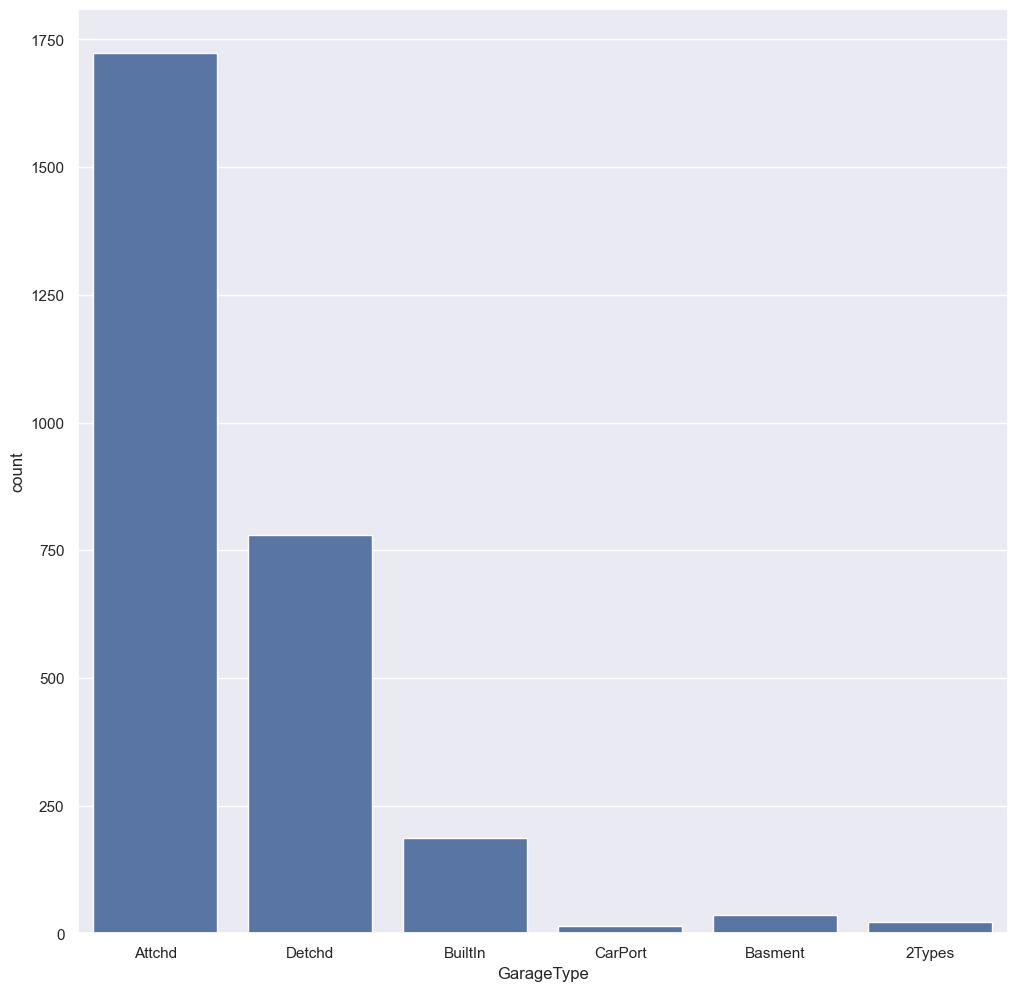

              GarageFinish  Ratio
GarageFinish                     
Unf                   1230 42.138
RFn                    811 27.783
Fin                    719 24.632


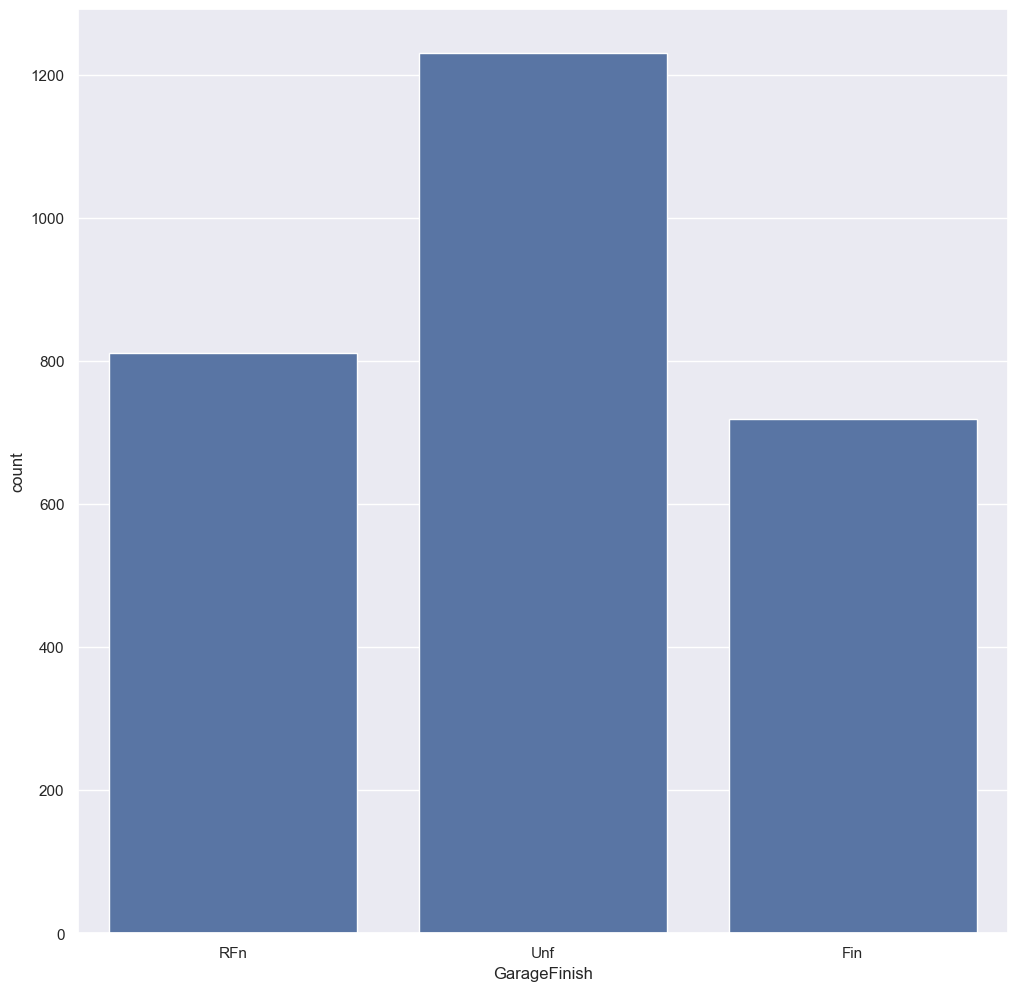

            GarageQual  Ratio
GarageQual                   
TA                2604 89.209
Fa                 124  4.248
Gd                  24  0.822
Po                   5  0.171
Ex                   3  0.103


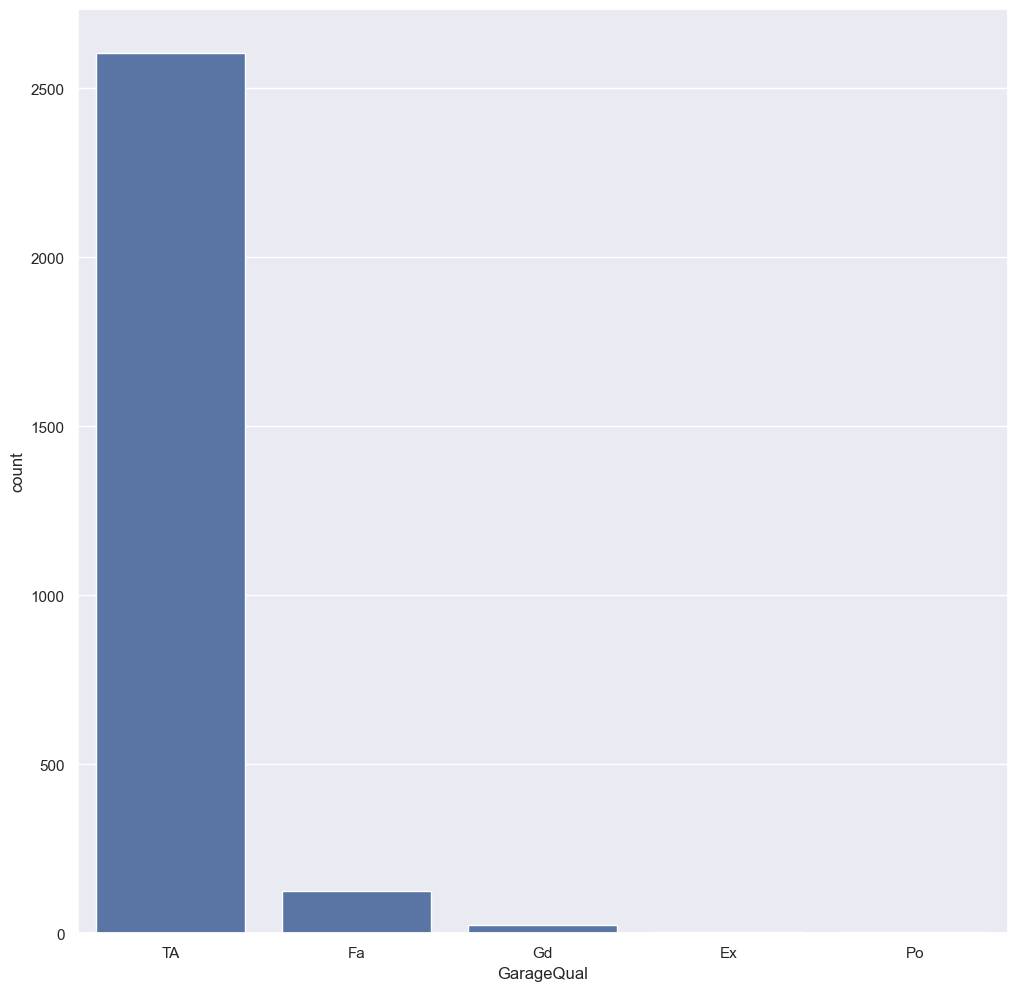

            GarageCond  Ratio
GarageCond                   
TA                2654 90.922
Fa                  74  2.535
Gd                  15  0.514
Po                  14  0.480
Ex                   3  0.103


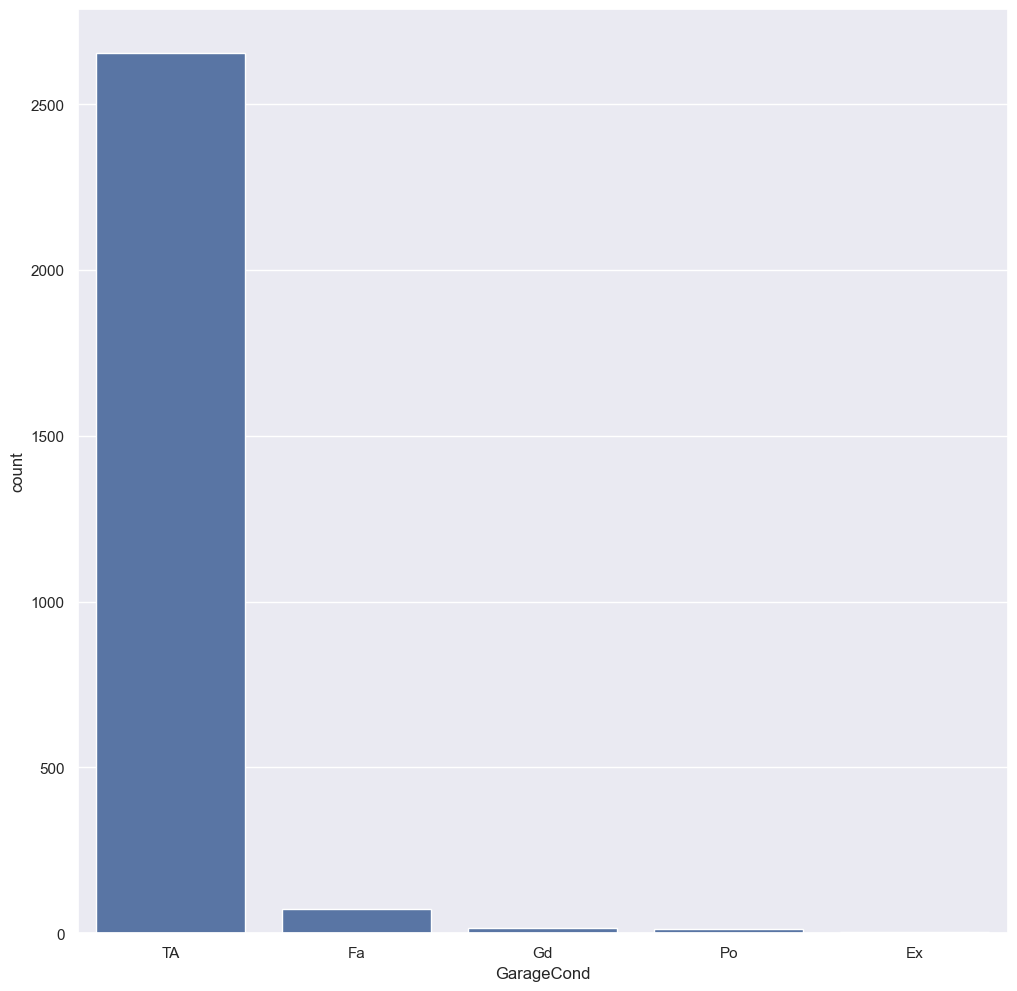

            PavedDrive  Ratio
PavedDrive                   
Y                 2641 90.476
N                  216  7.400
P                   62  2.124


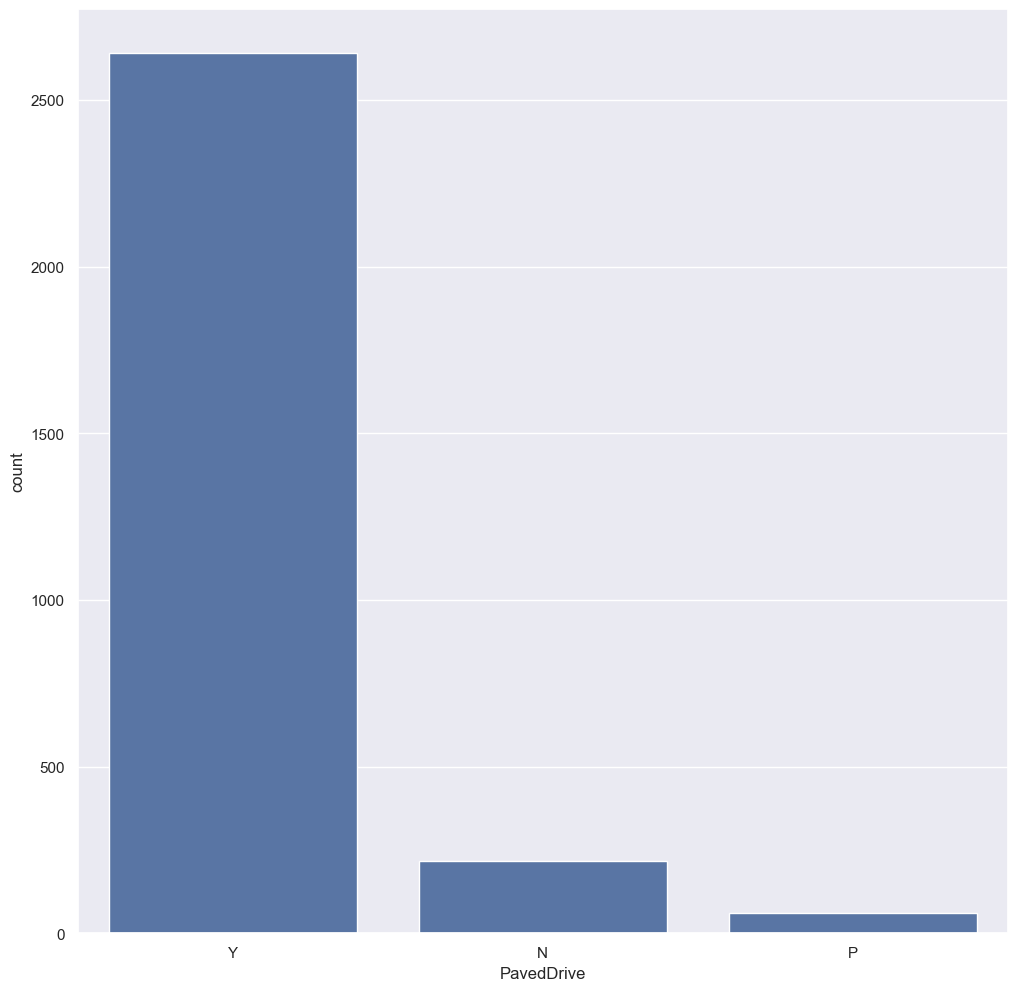

        PoolQC  Ratio
PoolQC               
Ex           4  0.137
Gd           4  0.137
Fa           2  0.069


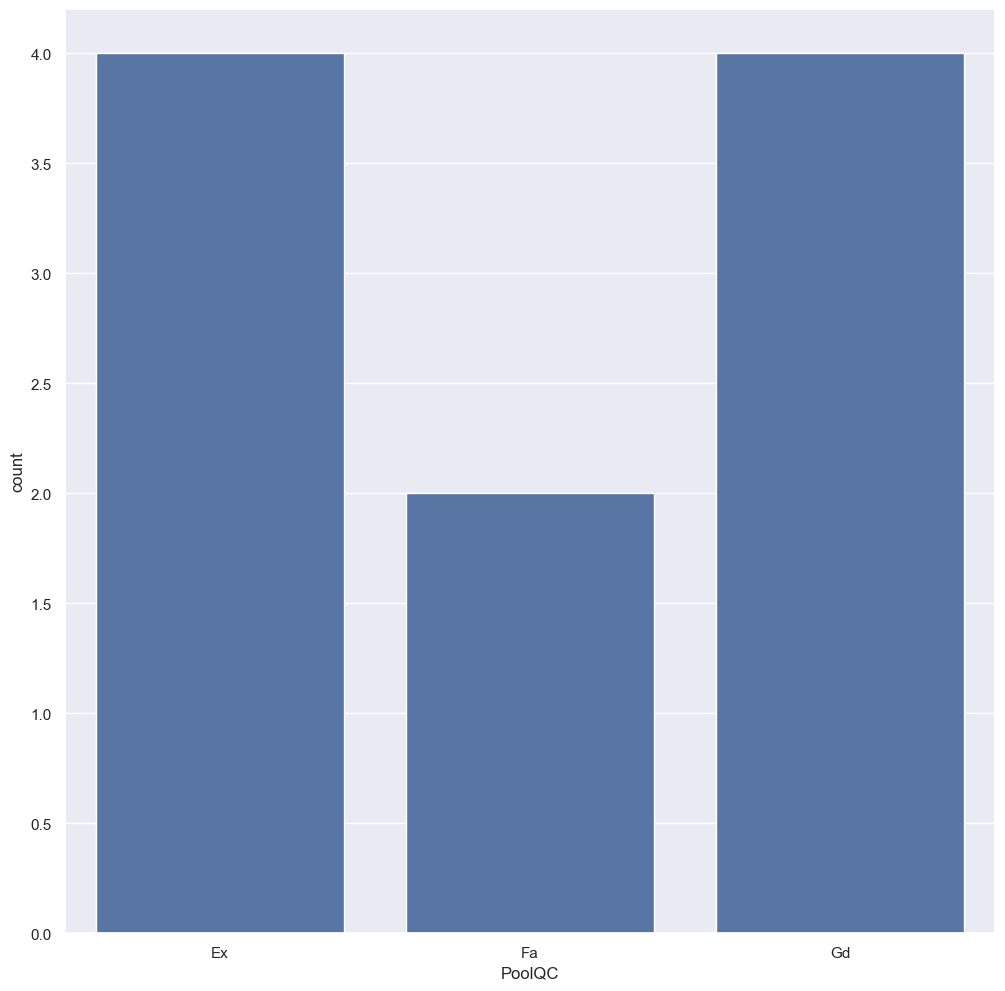

       Fence  Ratio
Fence              
MnPrv    329 11.271
GdPrv    118  4.042
GdWo     112  3.837
MnWw      12  0.411


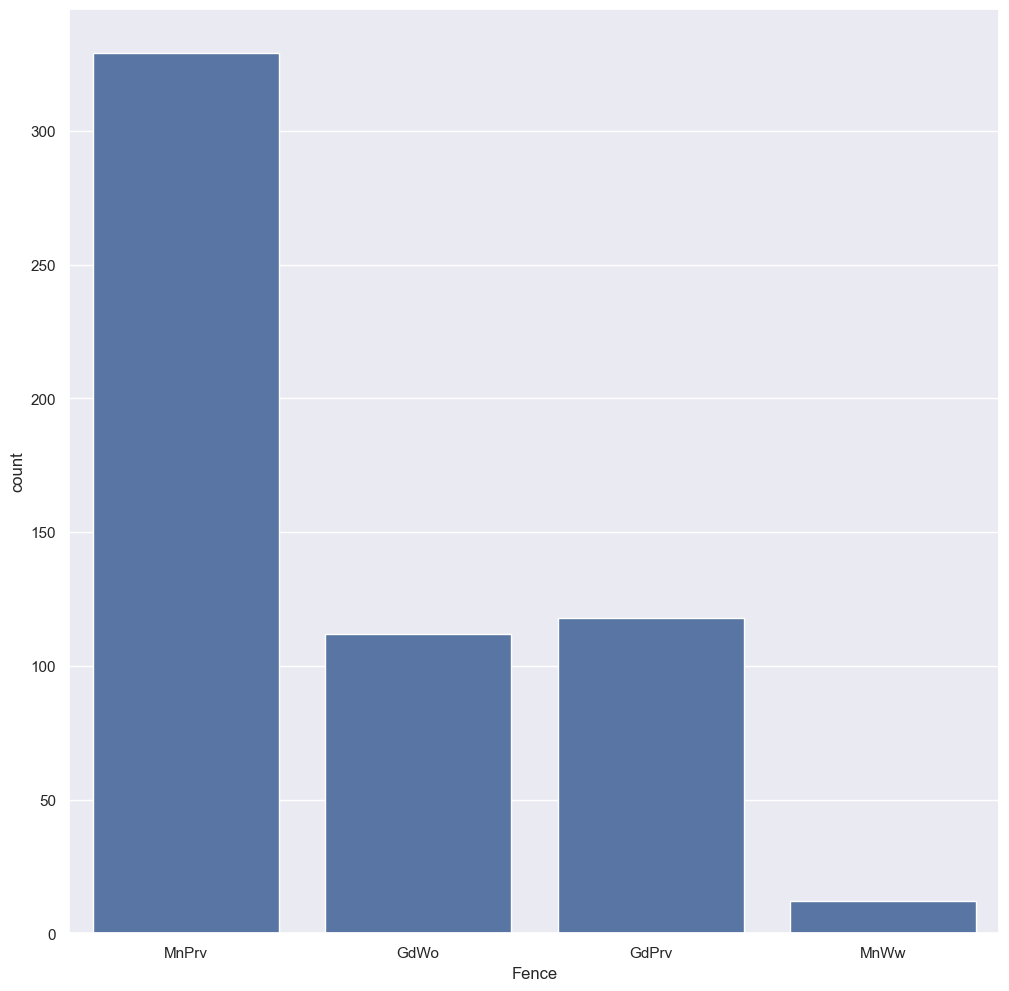

             MiscFeature  Ratio
MiscFeature                    
Shed                  95  3.255
Gar2                   5  0.171
Othr                   4  0.137
TenC                   1  0.034


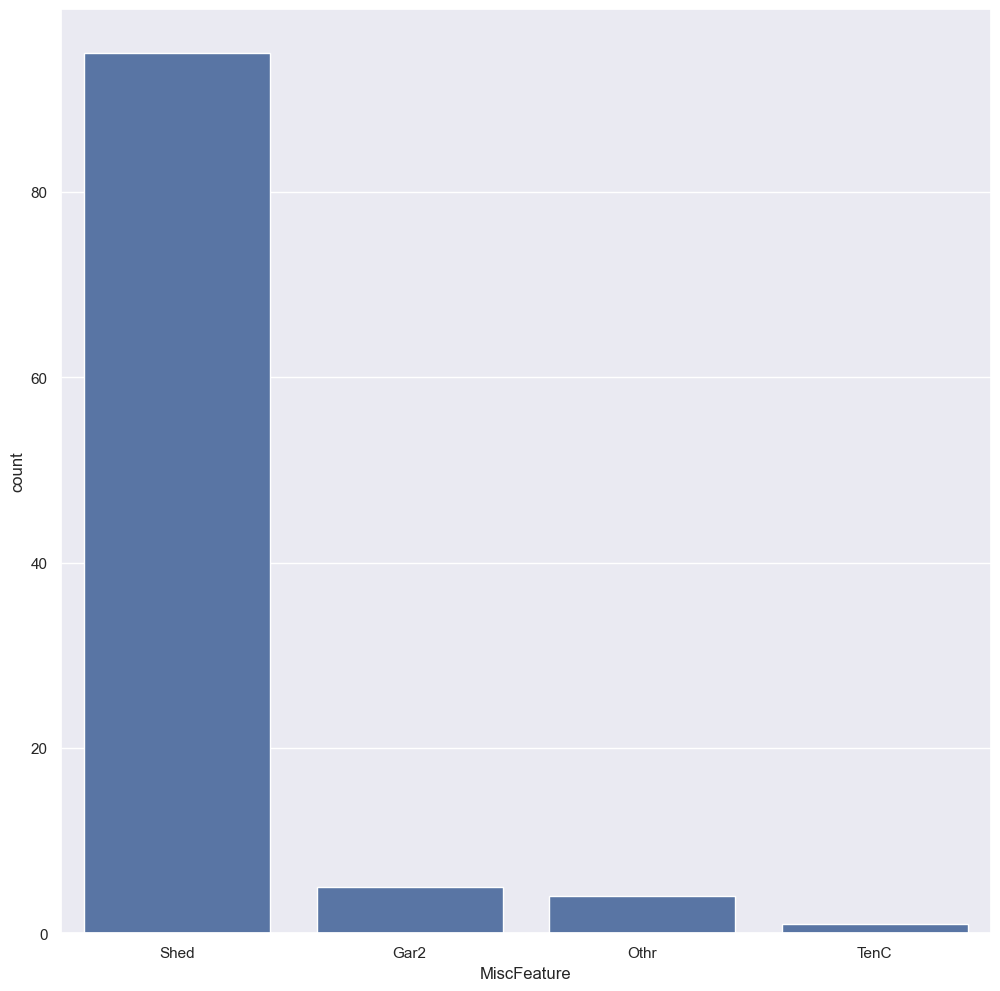

          SaleType  Ratio
SaleType                 
WD            2525 86.502
New            239  8.188
COD             87  2.980
ConLD           26  0.891
CWD             12  0.411
ConLI            9  0.308
ConLw            8  0.274
Oth              7  0.240
Con              5  0.171


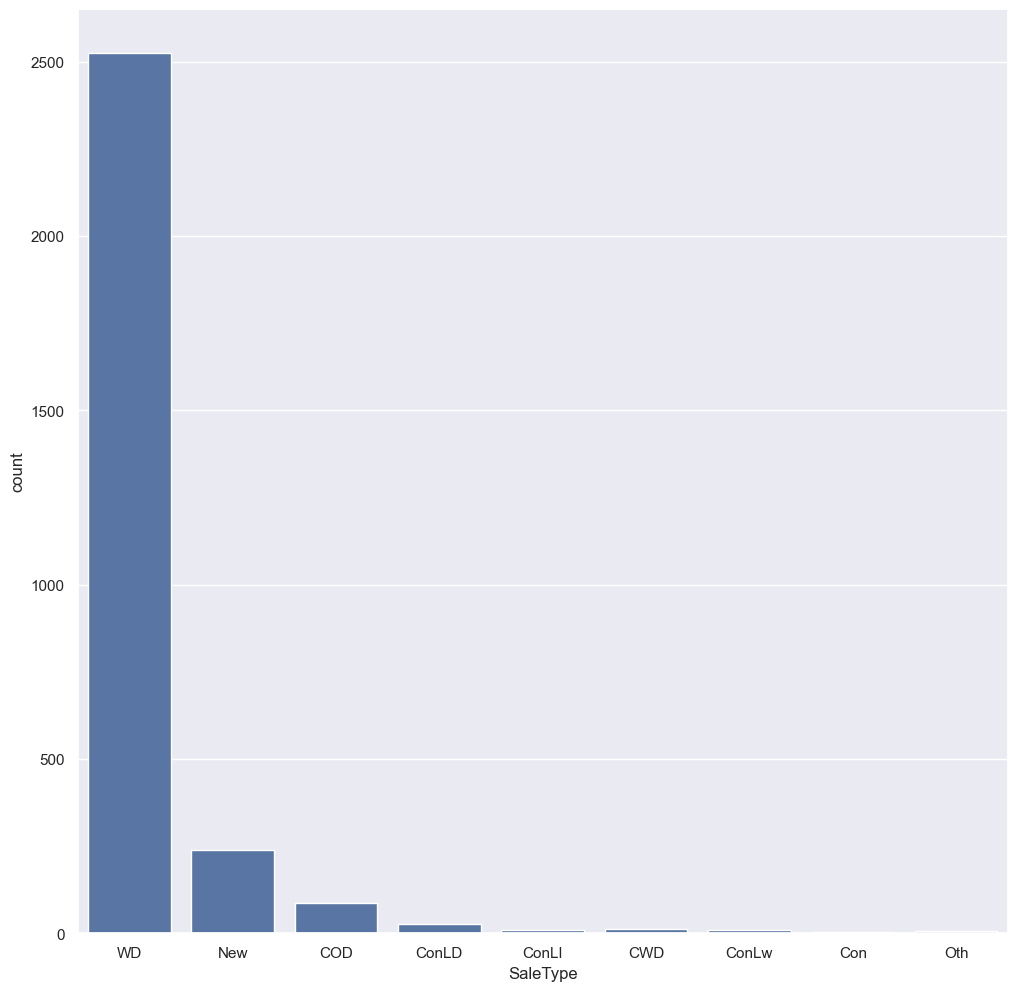

               SaleCondition  Ratio
SaleCondition                      
Normal                  2402 82.288
Partial                  245  8.393
Abnorml                  190  6.509
Family                    46  1.576
Alloca                    24  0.822
AdjLand                   12  0.411


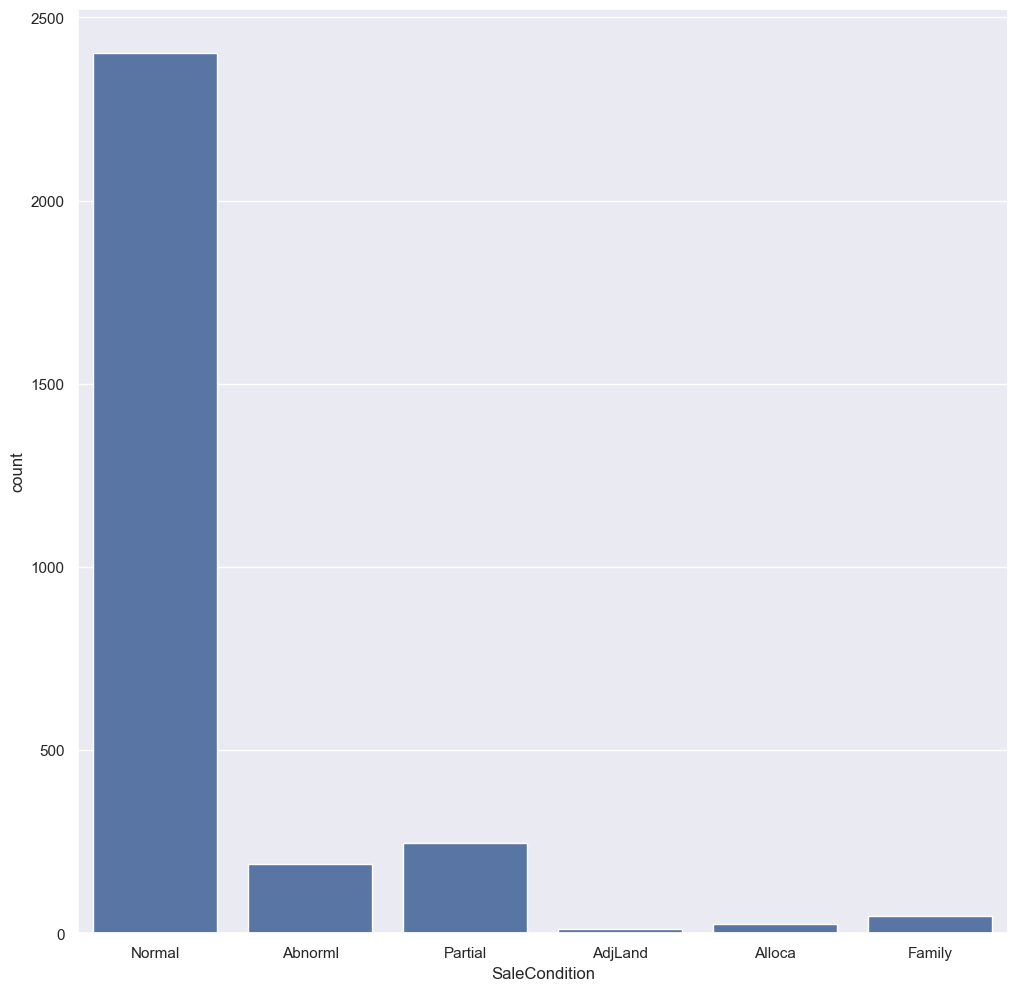

             OverallCond  Ratio
OverallCond                    
5                   1645 56.355
6                    531 18.191
7                    390 13.361
8                    144  4.933
4                    101  3.460
3                     50  1.713
9                     41  1.405
2                     10  0.343
1                      7  0.240


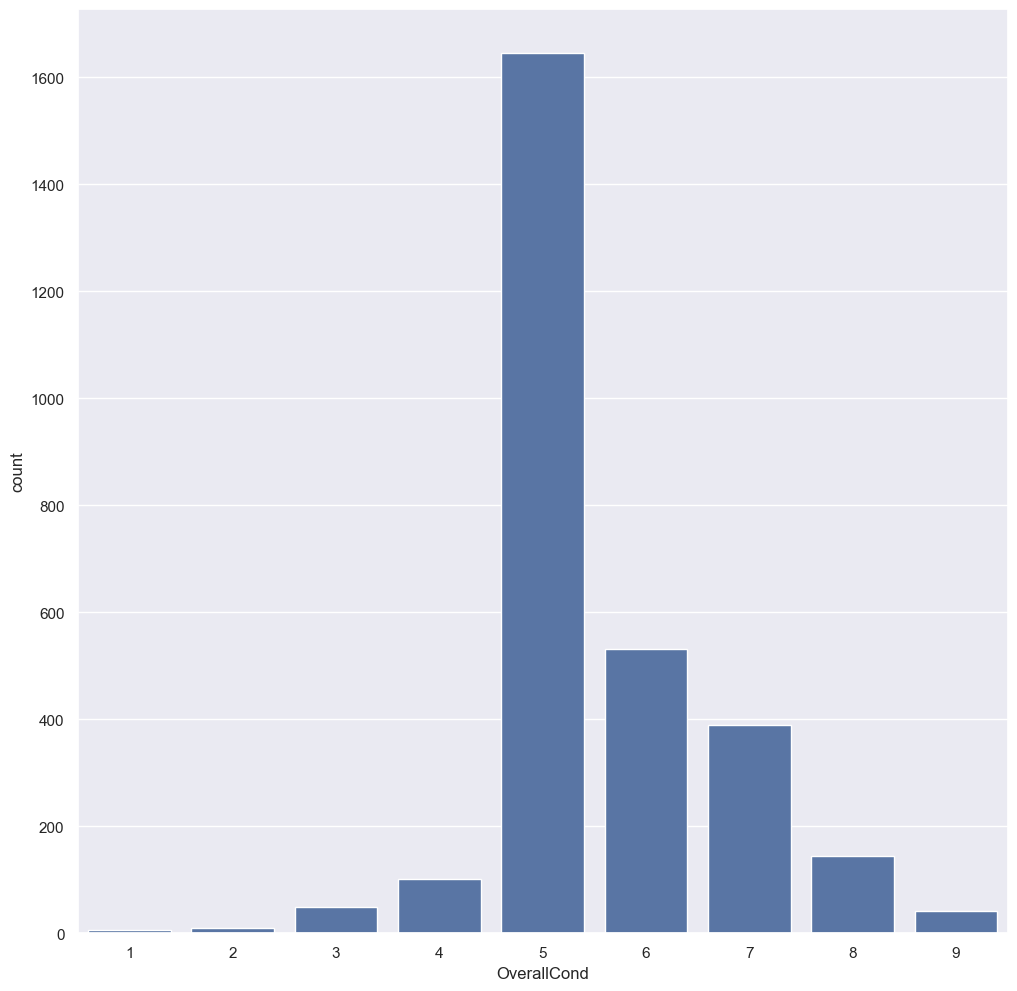

              BsmtFullBath  Ratio
BsmtFullBath                     
0.000                 1705 58.410
1.000                 1172 40.151
2.000                   38  1.302
3.000                    2  0.069


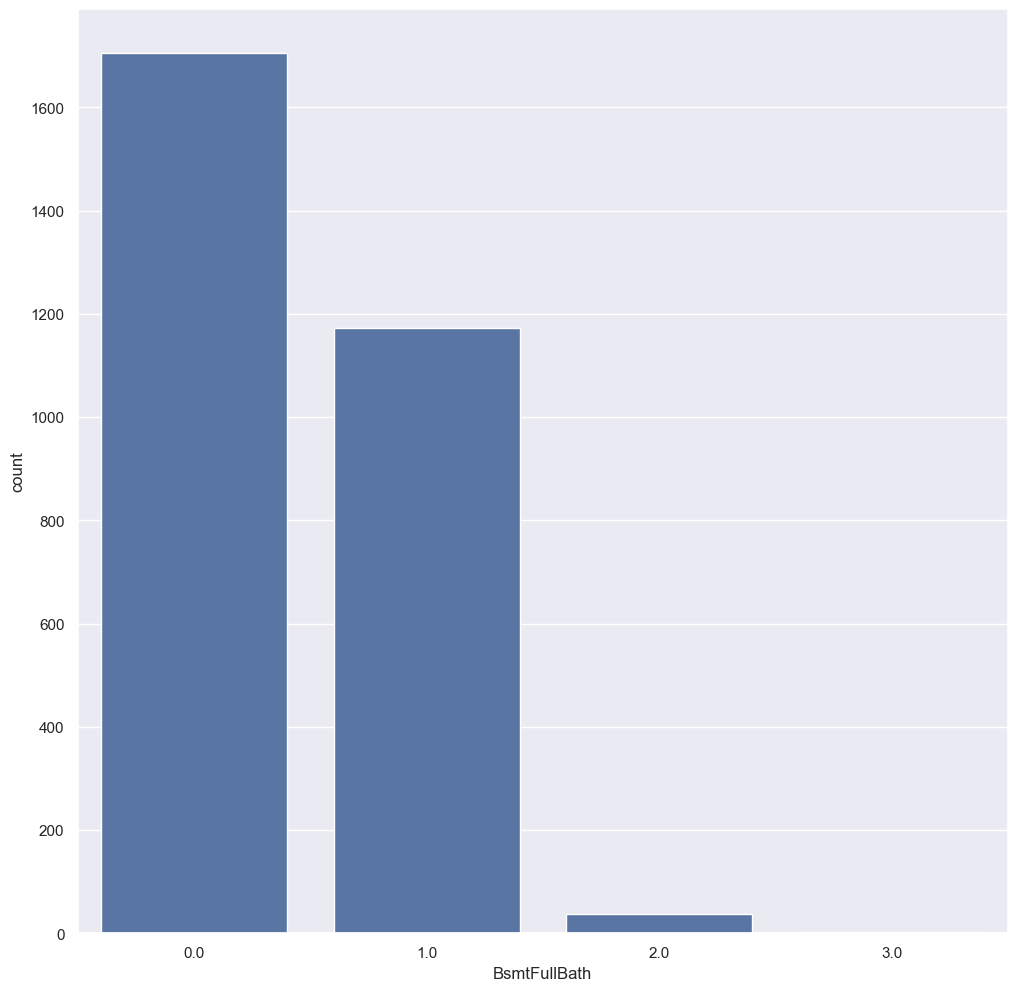

              BsmtHalfBath  Ratio
BsmtHalfBath                     
0.000                 2742 93.936
1.000                  171  5.858
2.000                    4  0.137


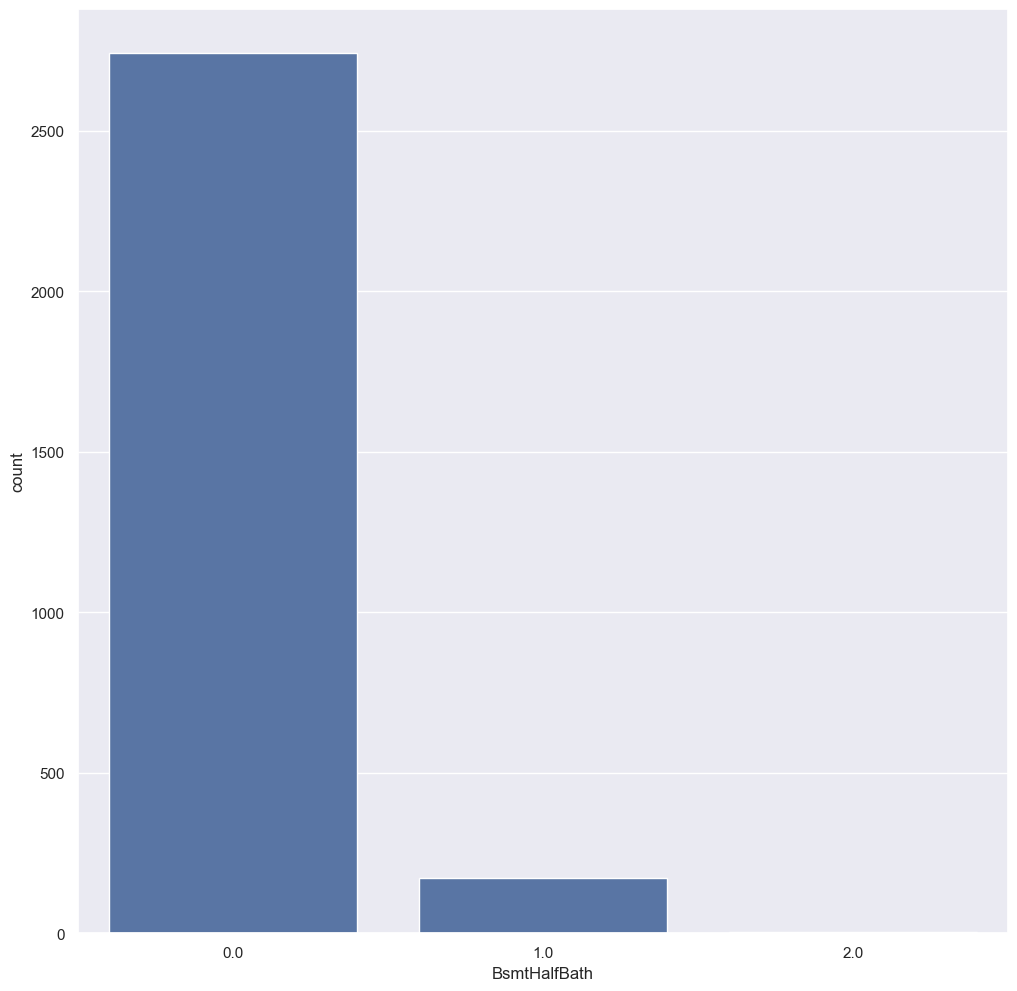

          FullBath  Ratio
FullBath                 
2             1530 52.415
1             1309 44.844
3               64  2.193
0               12  0.411
4                4  0.137


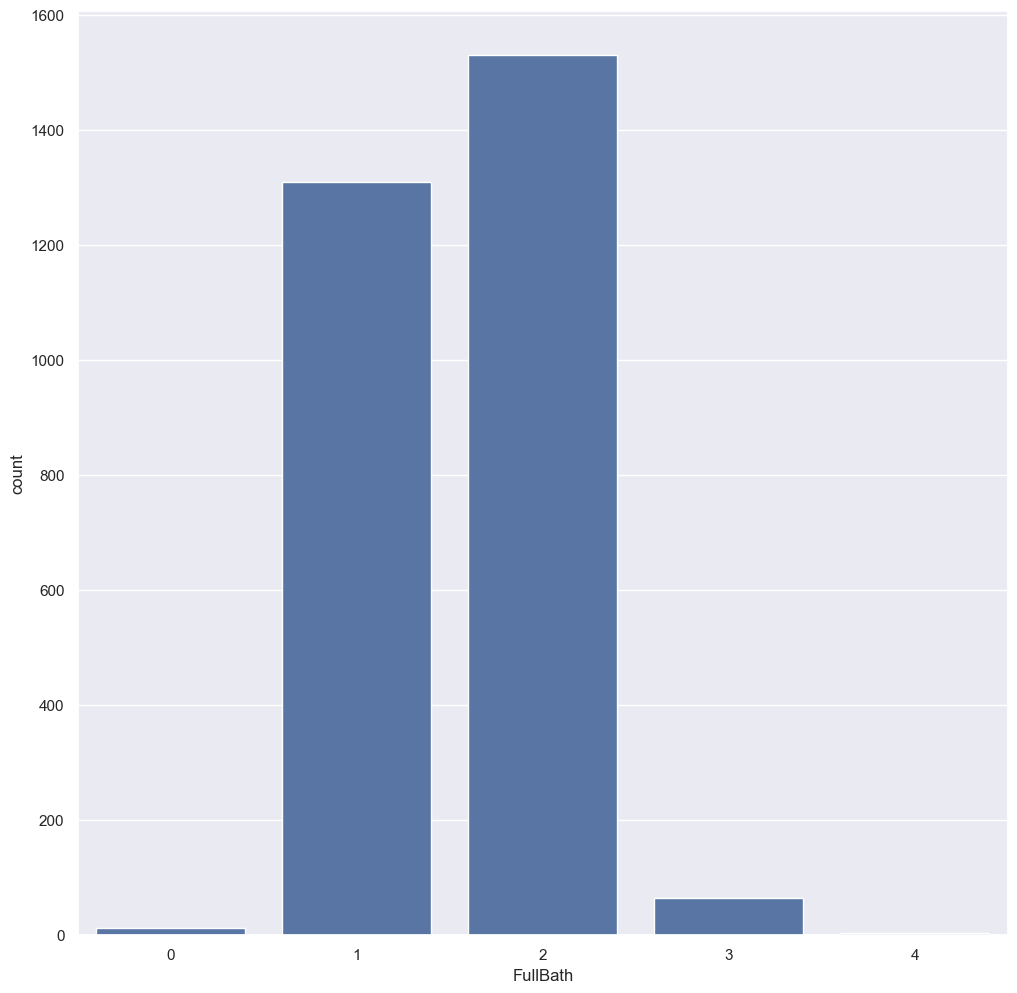

          HalfBath  Ratio
HalfBath                 
0             1834 62.830
1             1060 36.314
2               25  0.856


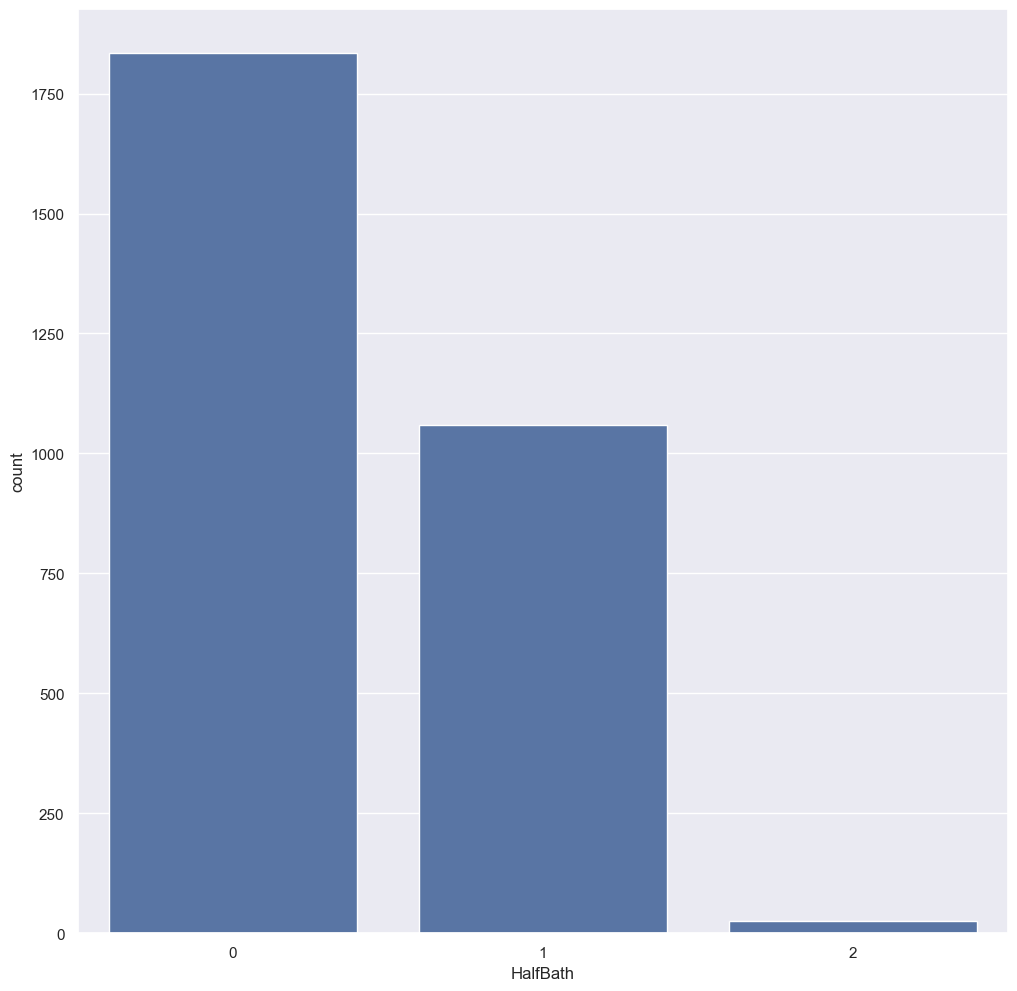

              BedroomAbvGr  Ratio
BedroomAbvGr                     
3                     1596 54.676
2                      742 25.420
4                      400 13.703
1                      103  3.529
5                       48  1.644
6                       21  0.719
0                        8  0.274
8                        1  0.034


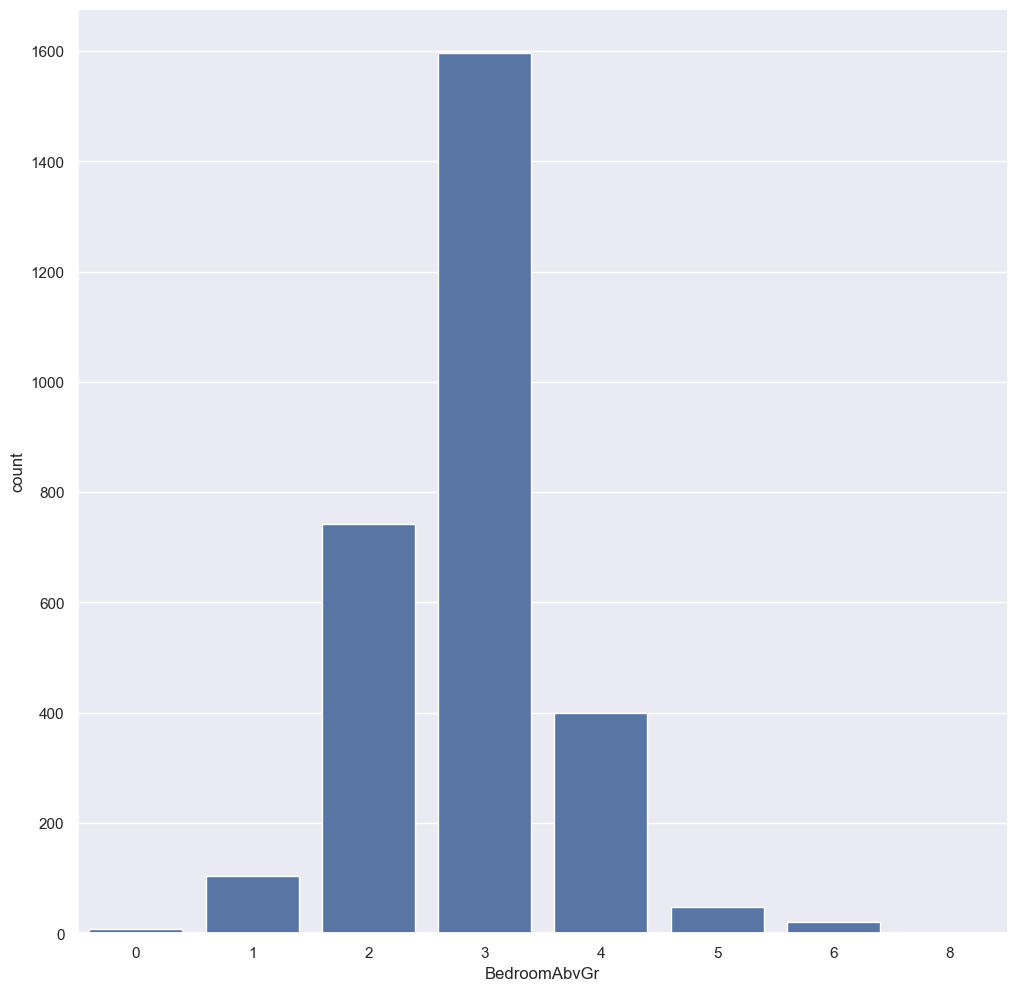

              KitchenAbvGr  Ratio
KitchenAbvGr                     
1                     2785 95.409
2                      129  4.419
0                        3  0.103
3                        2  0.069


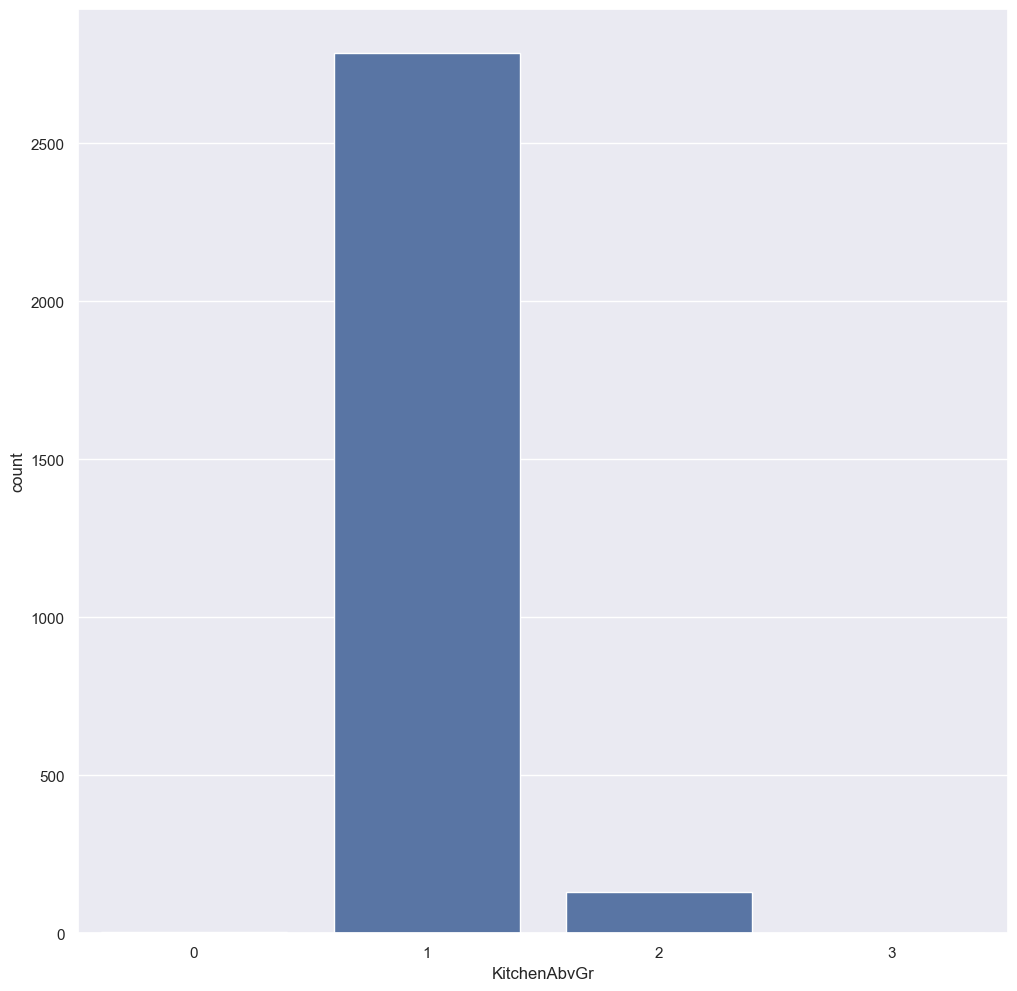

            Fireplaces  Ratio
Fireplaces                   
0                 1420 48.647
1                 1268 43.440
2                  219  7.503
3                   11  0.377
4                    1  0.034


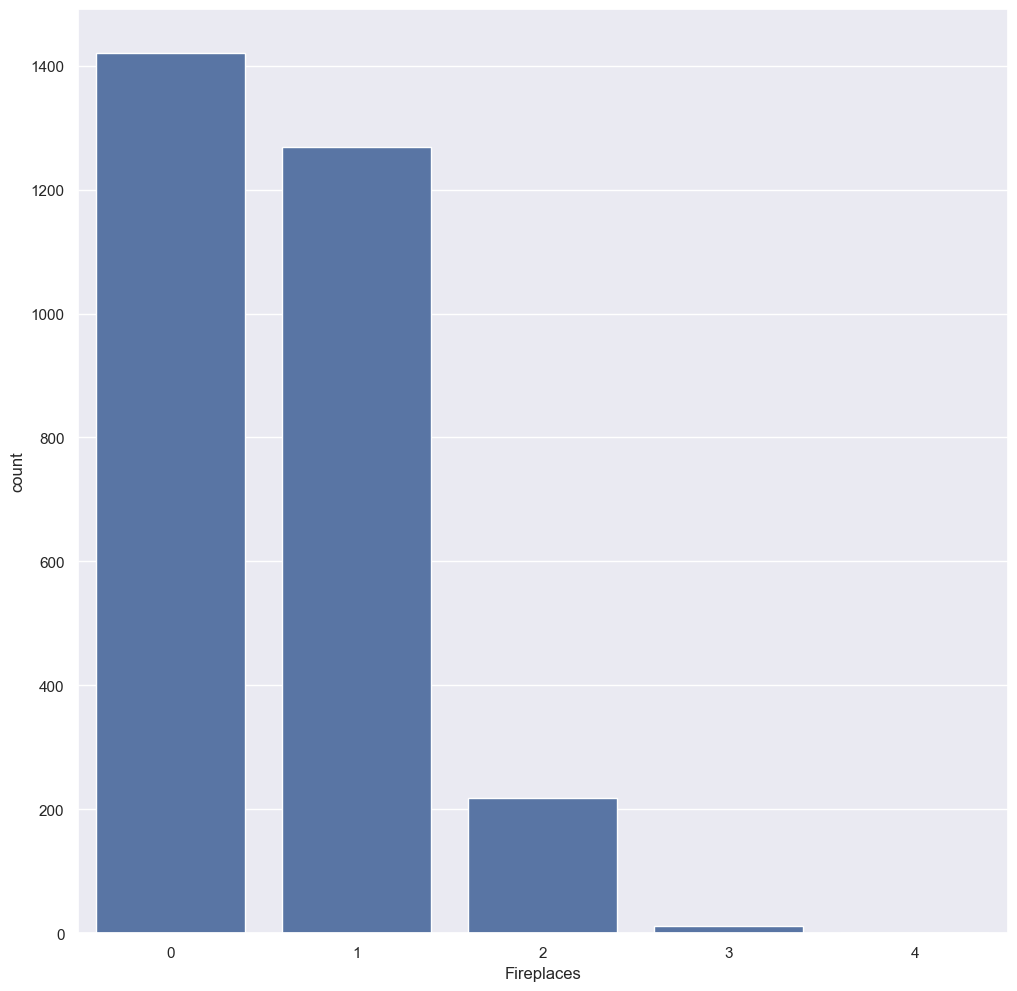

            GarageCars  Ratio
GarageCars                   
2.000             1594 54.608
1.000              776 26.584
3.000              374 12.813
0.000              157  5.379
4.000               16  0.548
5.000                1  0.034


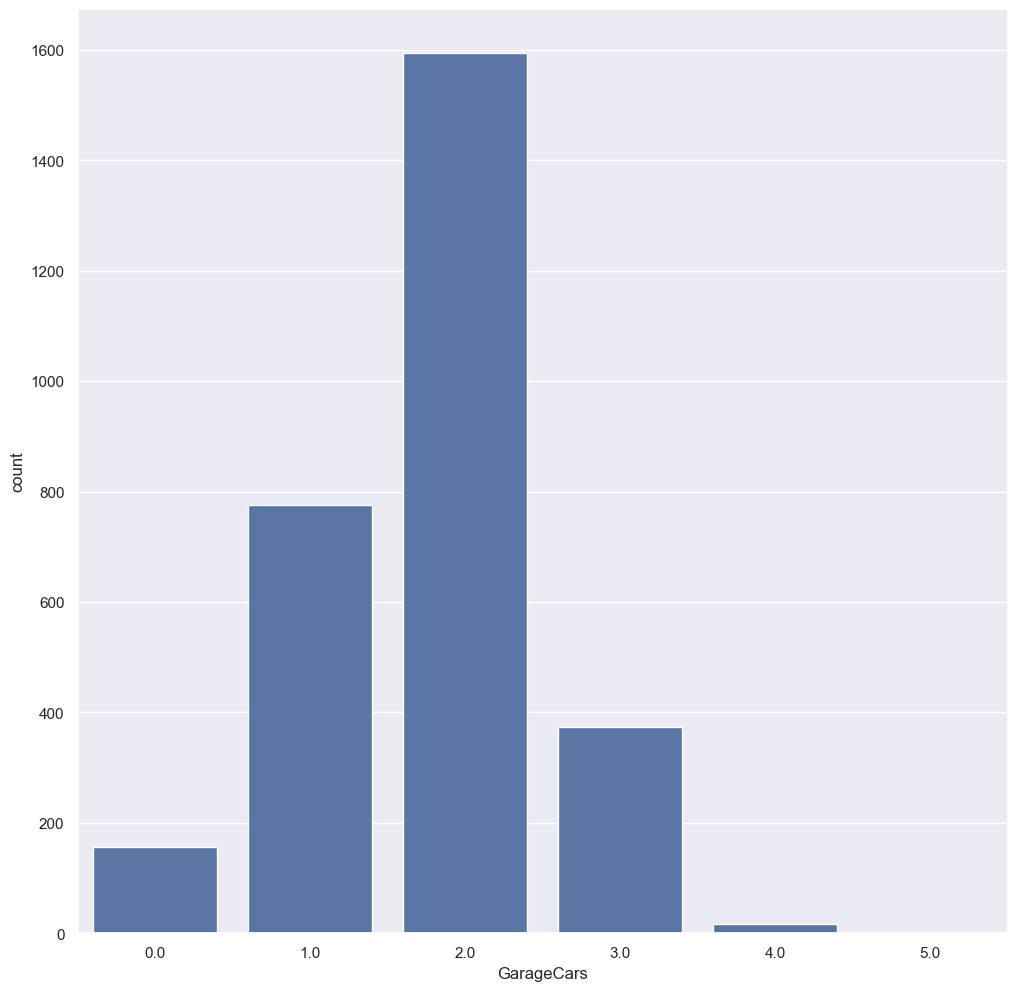

        YrSold  Ratio
YrSold               
2007       692 23.707
2009       647 22.165
2008       622 21.309
2006       619 21.206
2010       339 11.614


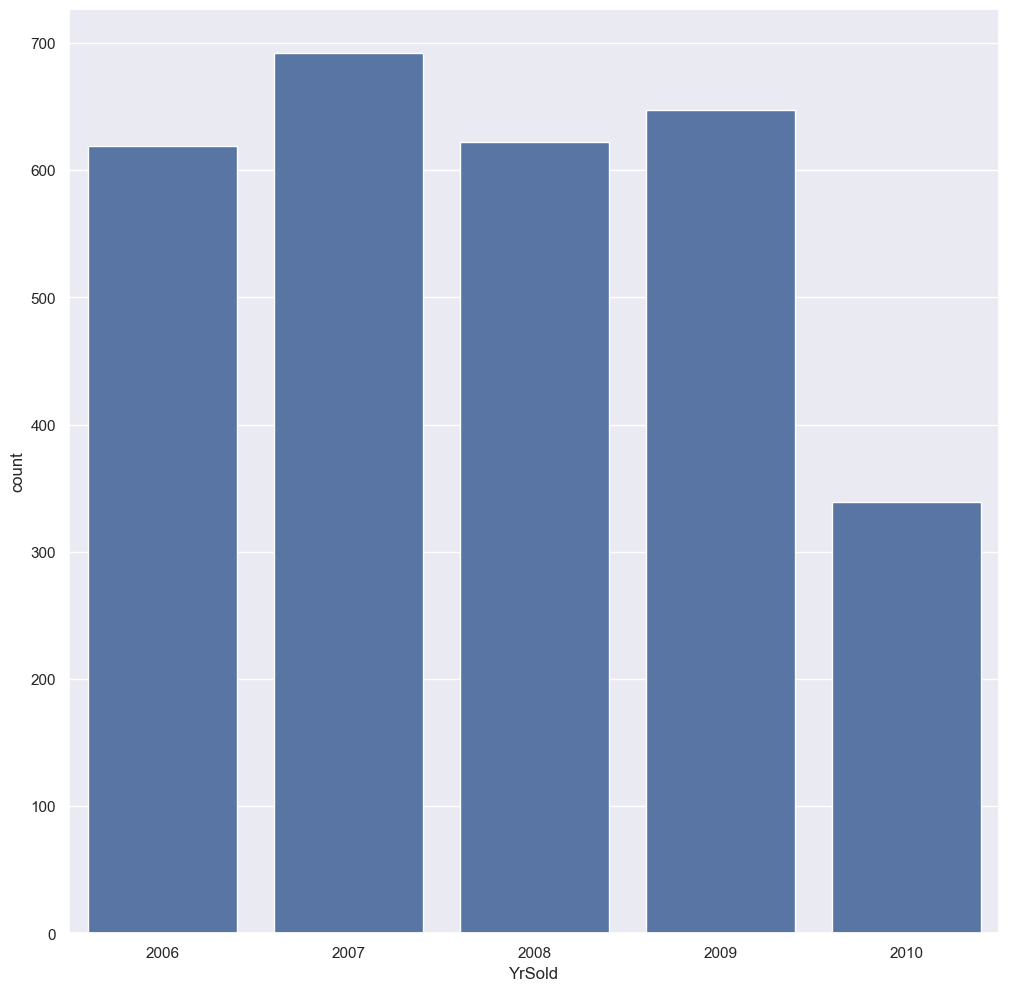

In [86]:
def cat_summary(dataframe, col_name, plot=True):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)
    
for col in cat_cols:
    cat_summary(df, col)

Sayısal Değişken Analizi

count   2919.000
mean    1460.000
std      842.787
min        1.000
5%       146.900
10%      292.800
20%      584.600
30%      876.400
40%     1168.200
50%     1460.000
60%     1751.800
70%     2043.600
80%     2335.400
90%     2627.200
95%     2773.100
99%     2889.820
max     2919.000
Name: Id, dtype: float64


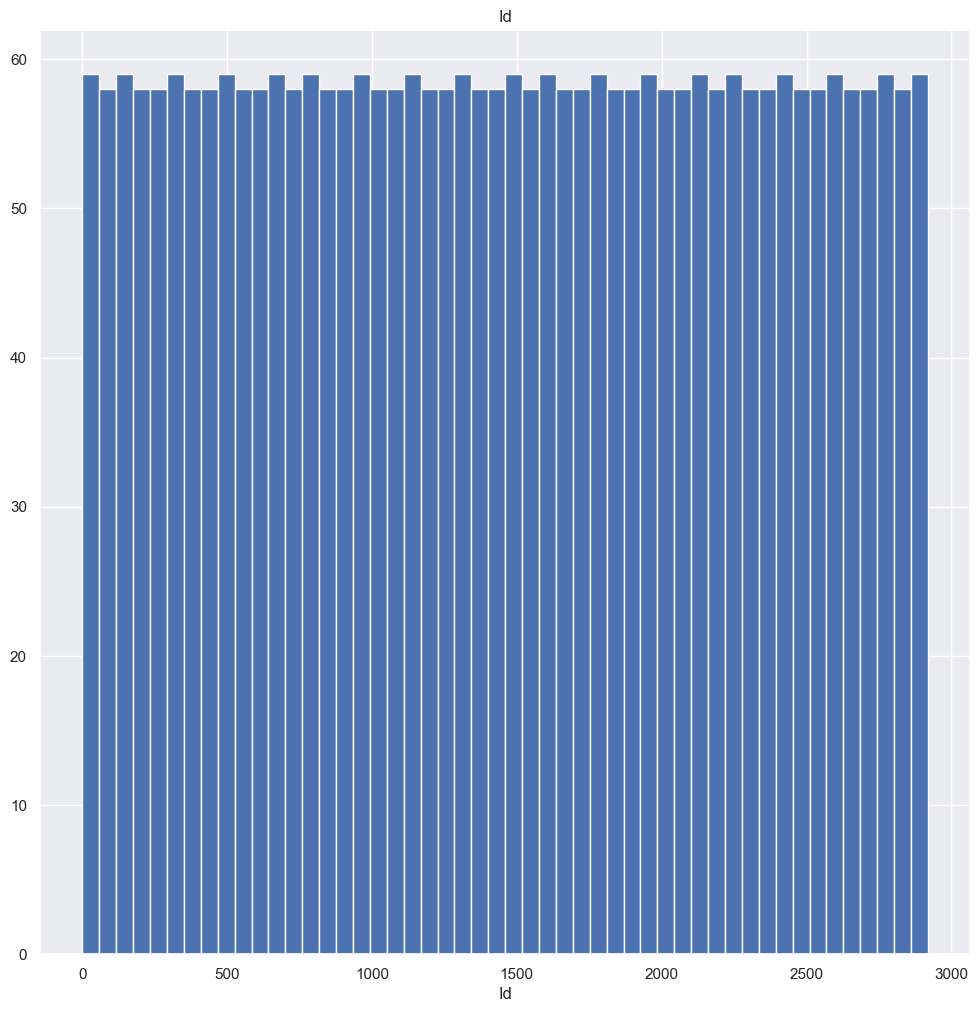

###########################
count   2919.000
mean      57.138
std       42.518
min       20.000
5%        20.000
10%       20.000
20%       20.000
30%       20.000
40%       30.000
50%       50.000
60%       60.000
70%       60.000
80%       80.000
90%      120.000
95%      160.000
99%      190.000
max      190.000
Name: MSSubClass, dtype: float64


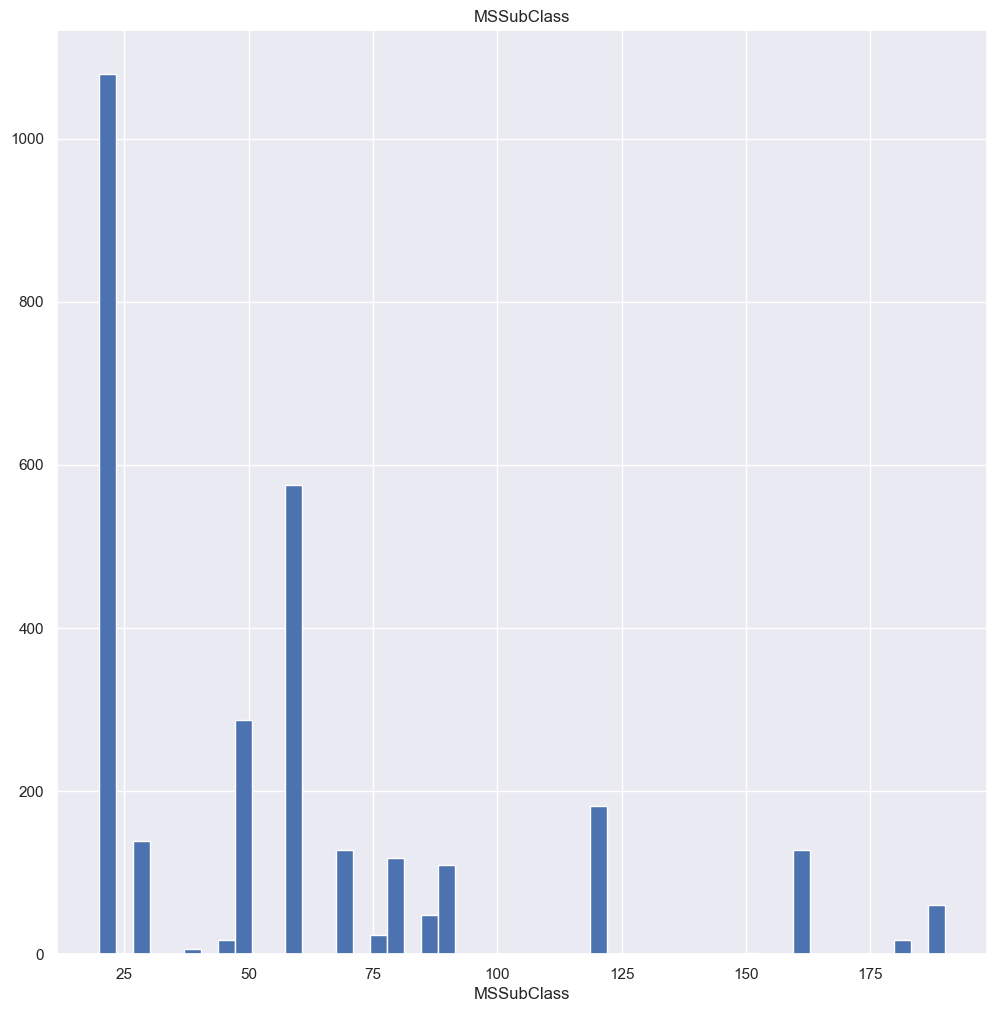

###########################
count   2433.000
mean      69.306
std       23.345
min       21.000
5%        32.000
10%       43.000
20%       53.000
30%       60.000
40%       63.000
50%       68.000
60%       73.000
70%       78.000
80%       84.000
90%       95.000
95%      107.000
99%      135.680
max      313.000
Name: LotFrontage, dtype: float64


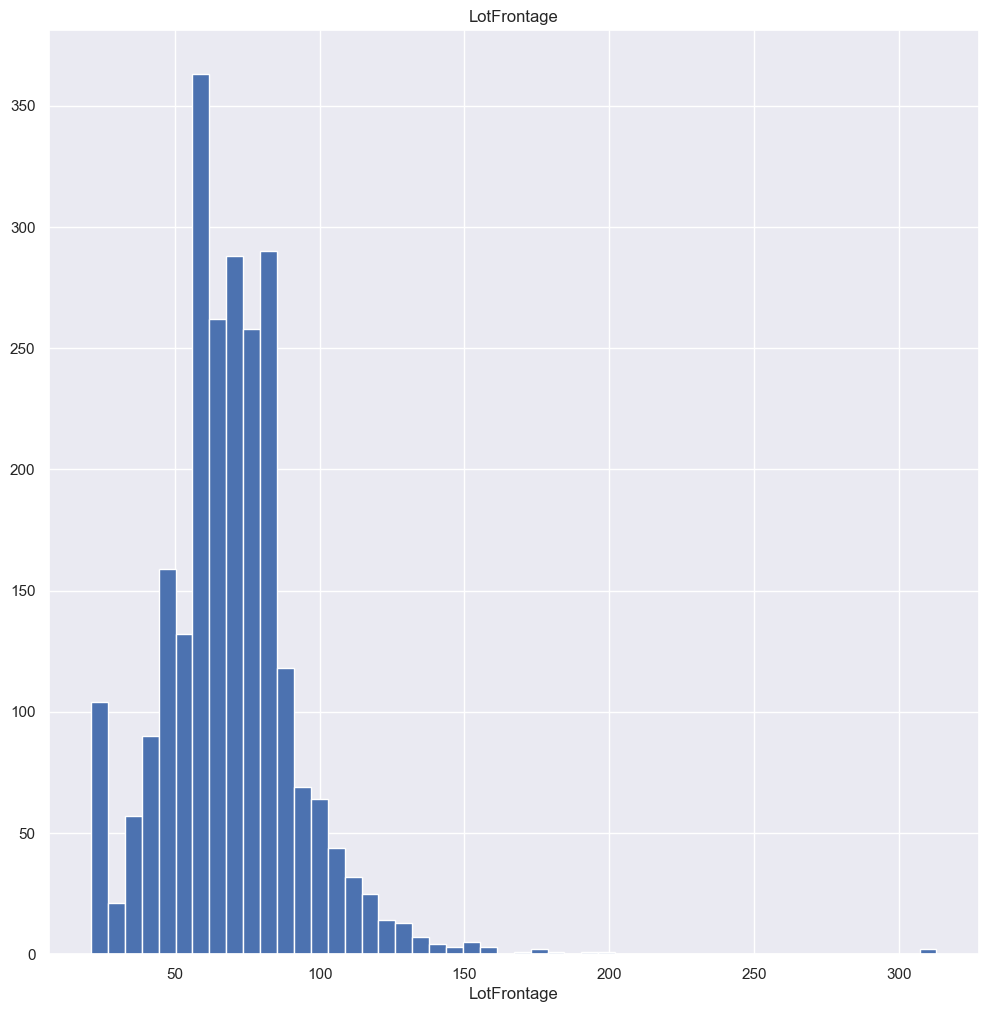

###########################
count     2919.000
mean     10168.114
std       7886.996
min       1300.000
5%        3182.000
10%       4922.400
20%       7007.600
30%       7960.400
40%       8741.000
50%       9453.000
60%      10151.600
70%      11001.200
80%      12203.800
90%      14300.600
95%      17142.900
99%      33038.640
max     215245.000
Name: LotArea, dtype: float64


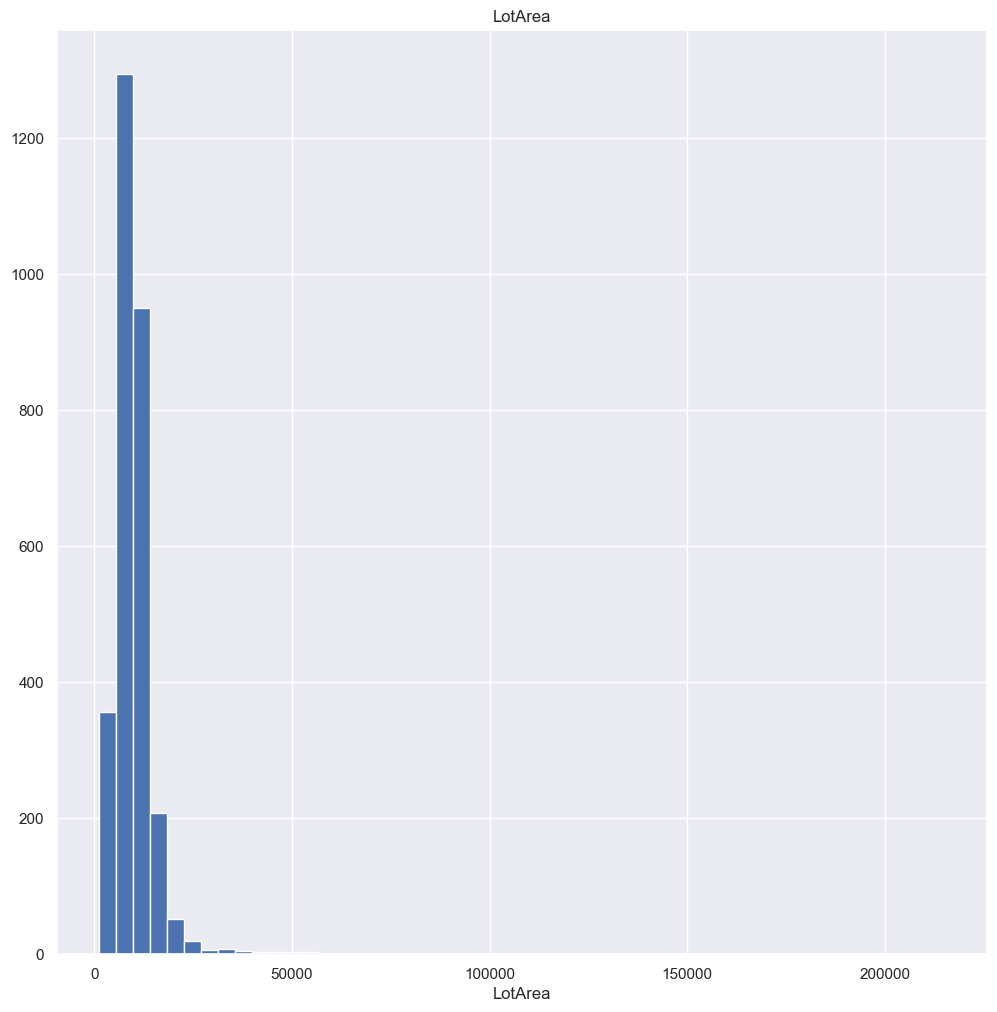

###########################
count   2919.000
mean       6.089
std        1.410
min        1.000
5%         4.000
10%        5.000
20%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        6.000
70%        7.000
80%        7.000
90%        8.000
95%        8.000
99%       10.000
max       10.000
Name: OverallQual, dtype: float64


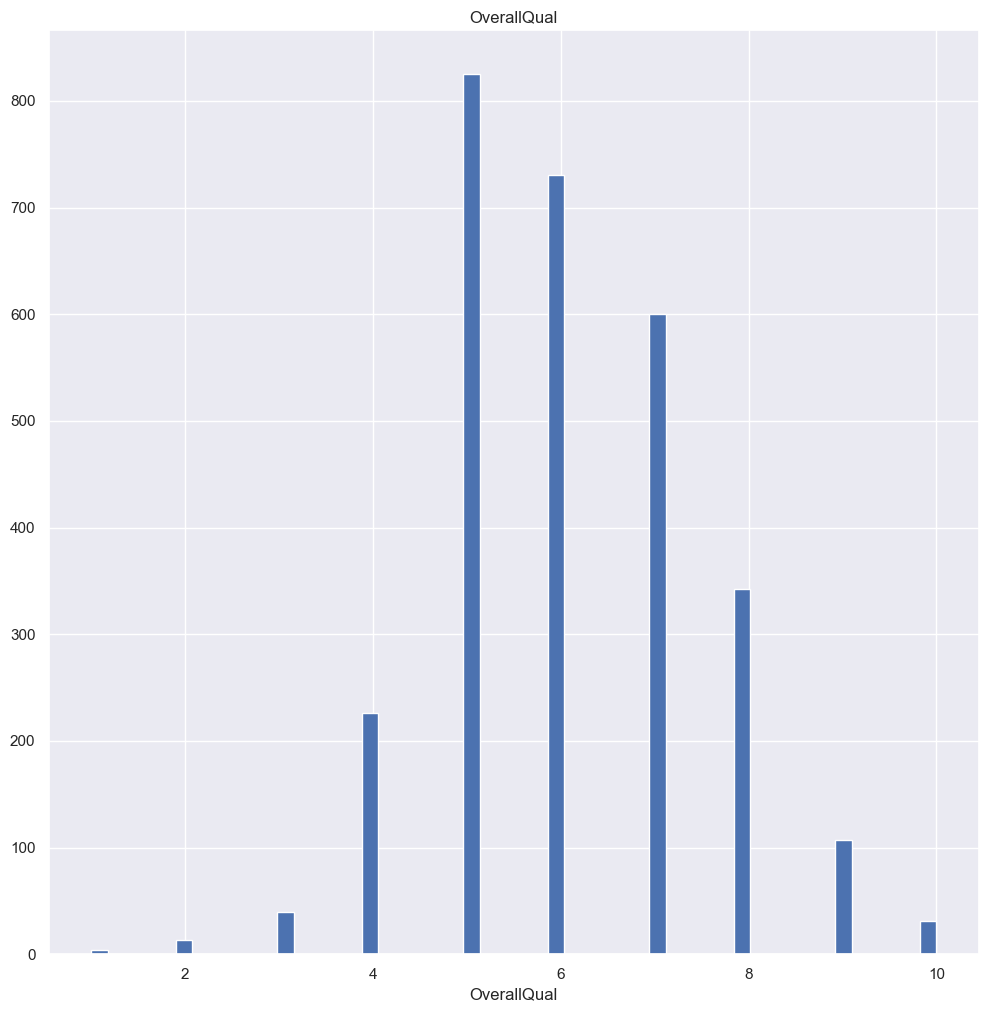

###########################
count   2919.000
mean    1971.313
std       30.291
min     1872.000
5%      1915.000
10%     1924.000
20%     1947.000
30%     1957.000
40%     1965.000
50%     1973.000
60%     1984.000
70%     1998.000
80%     2003.000
90%     2006.000
95%     2007.000
99%     2008.000
max     2010.000
Name: YearBuilt, dtype: float64


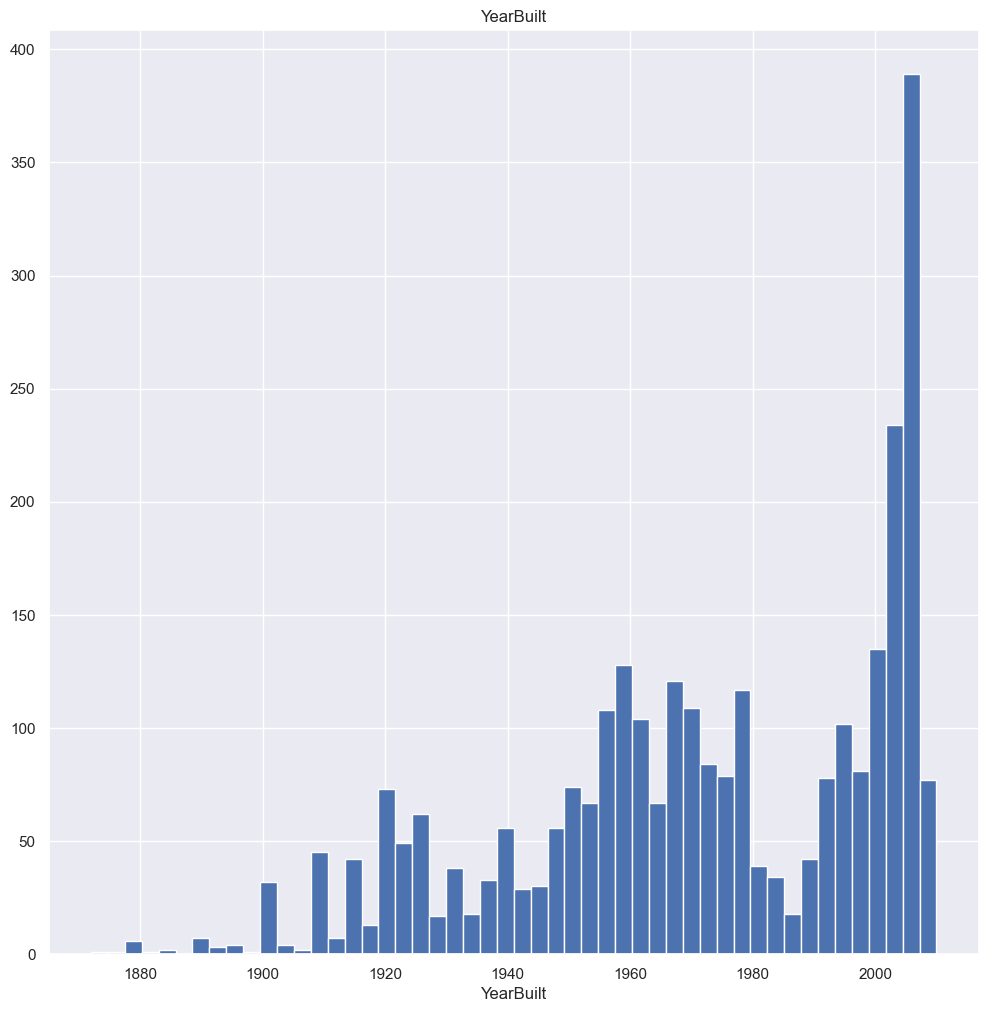

###########################
count   2919.000
mean    1984.264
std       20.894
min     1950.000
5%      1950.000
10%     1950.000
20%     1960.000
30%     1970.000
40%     1978.000
50%     1993.000
60%     1998.000
70%     2002.000
80%     2005.000
90%     2006.200
95%     2007.000
99%     2009.000
max     2010.000
Name: YearRemodAdd, dtype: float64


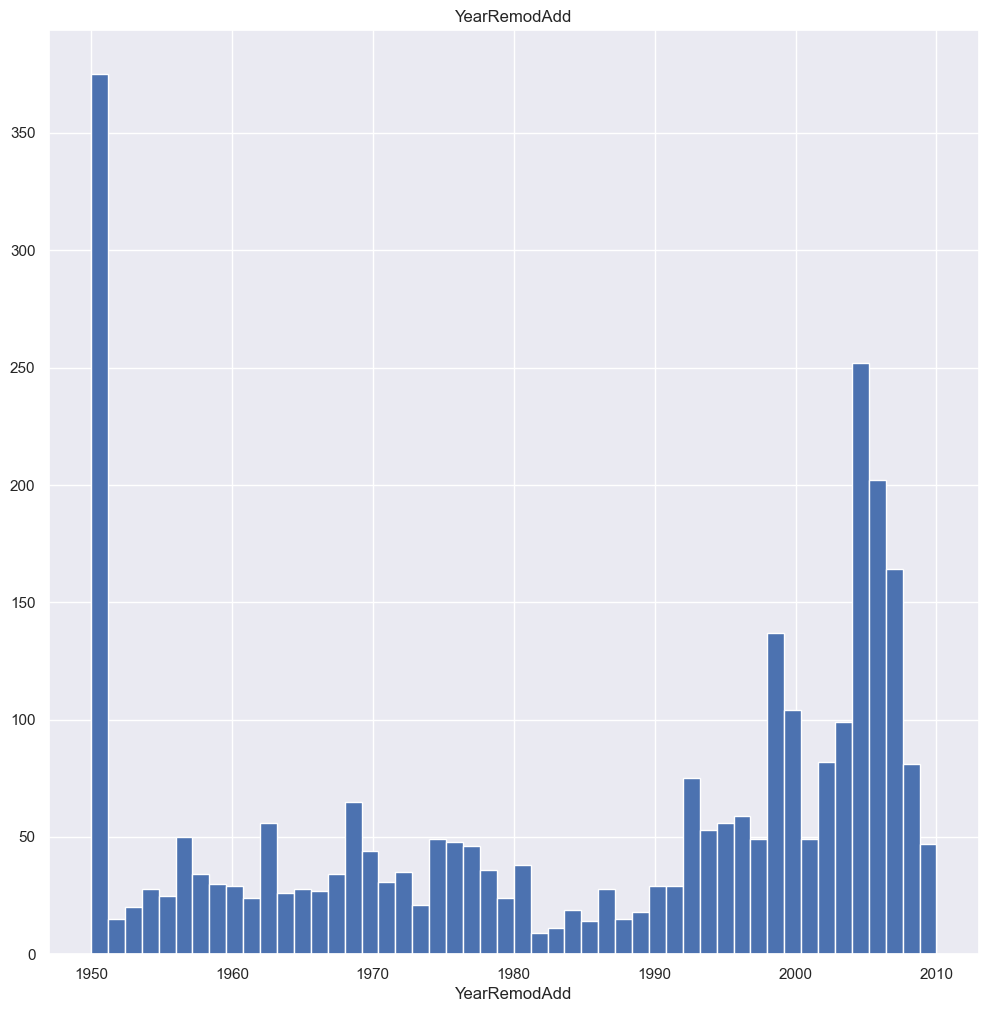

###########################
count   2896.000
mean     102.201
std      179.334
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%      120.000
80%      202.000
90%      325.500
95%      466.500
99%      771.050
max     1600.000
Name: MasVnrArea, dtype: float64


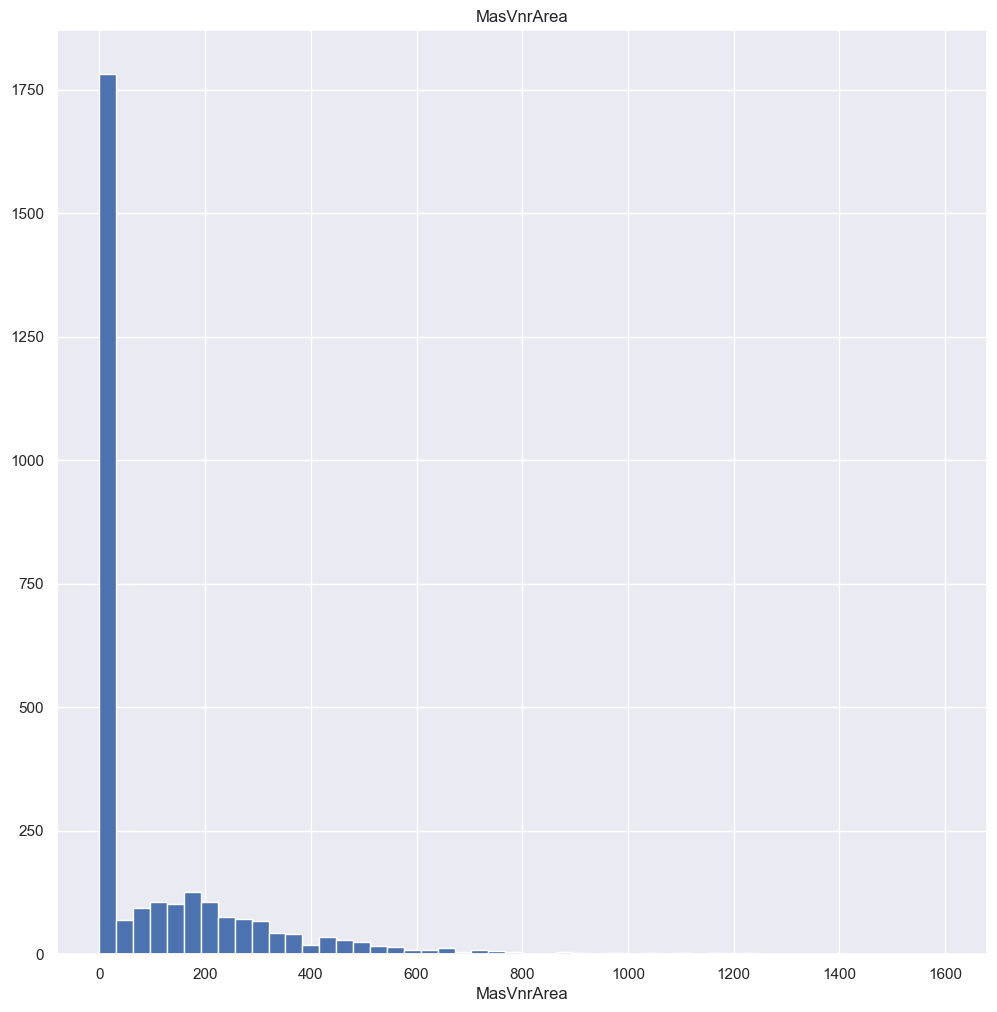

###########################
count   2918.000
mean     441.423
std      455.611
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%      202.600
50%      368.500
60%      515.200
70%      656.000
80%      812.000
90%     1056.900
95%     1274.000
99%     1635.320
max     5644.000
Name: BsmtFinSF1, dtype: float64


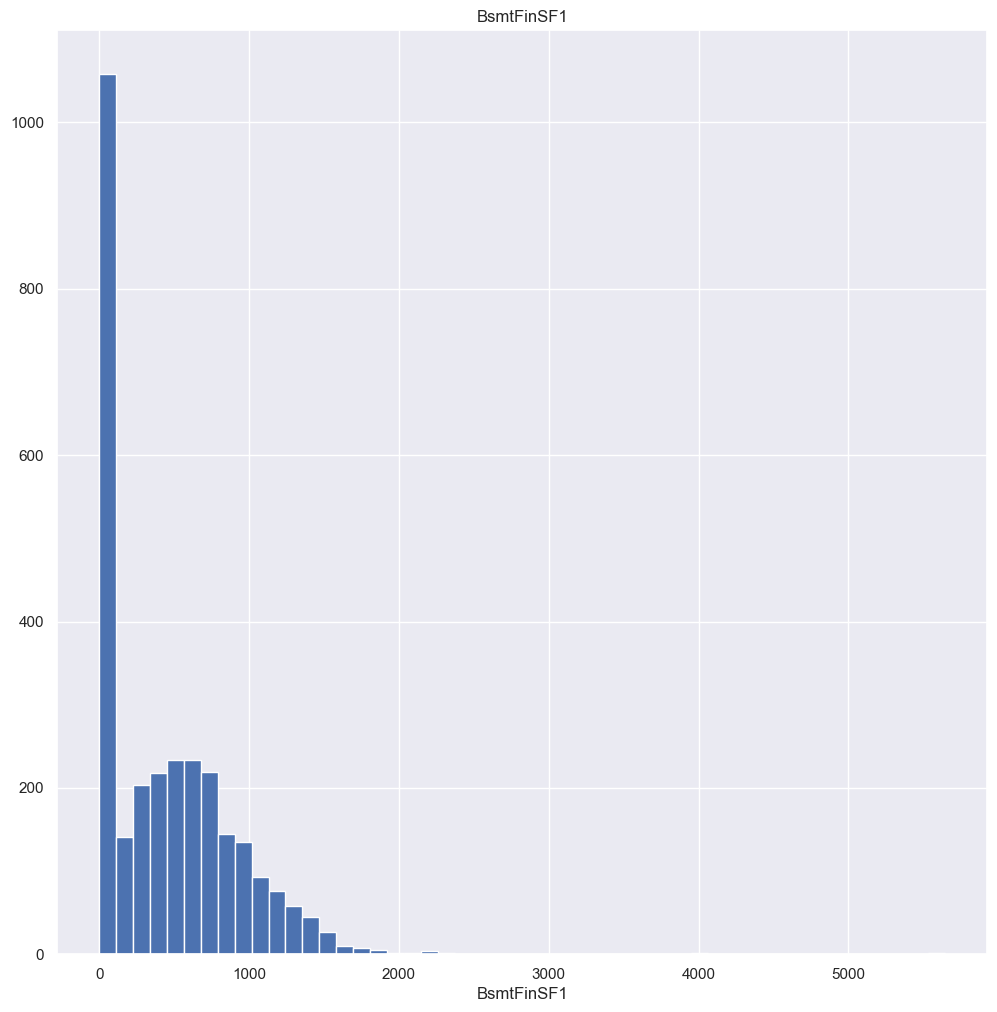

###########################
count   2918.000
mean      49.582
std      169.206
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      125.600
95%      435.000
99%      874.660
max     1526.000
Name: BsmtFinSF2, dtype: float64


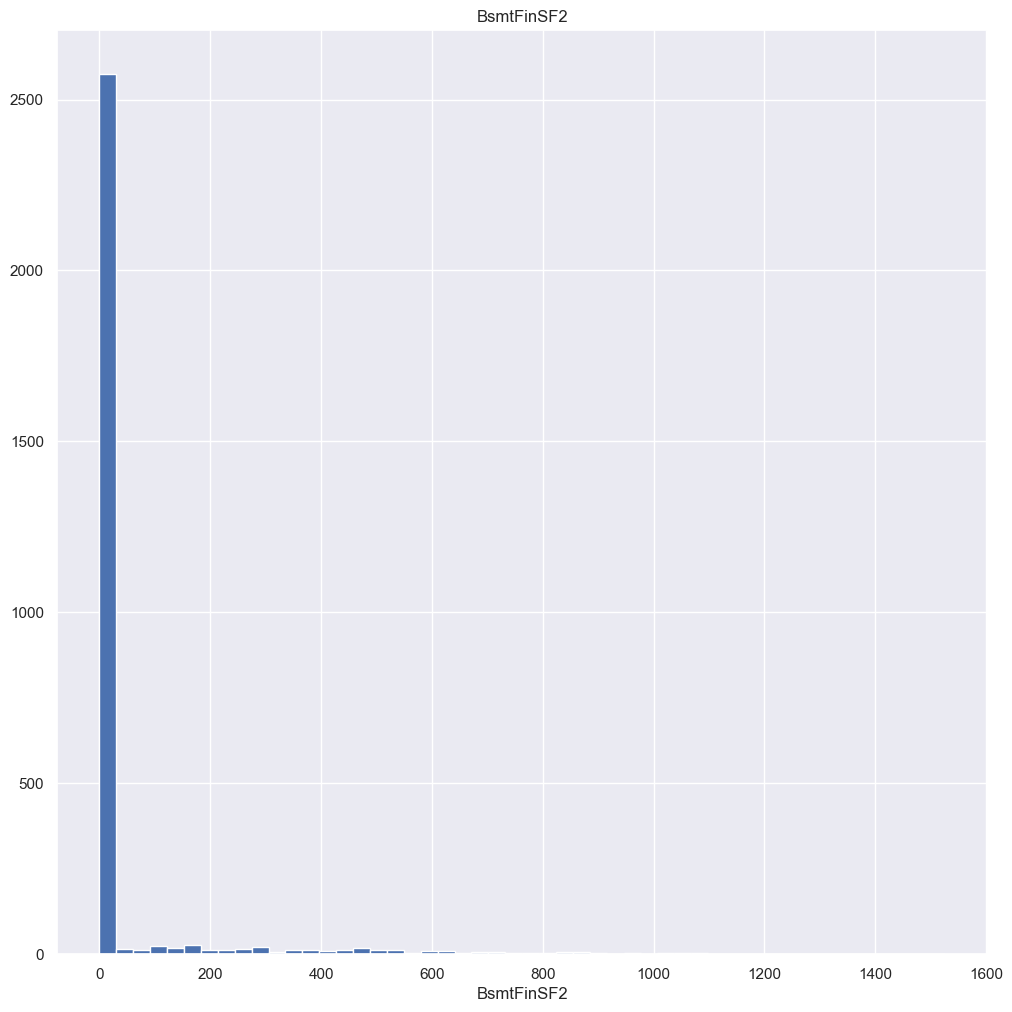

###########################
count   2918.000
mean     560.772
std      439.544
min        0.000
5%         0.000
10%       56.000
20%      174.000
30%      270.000
40%      365.800
50%      467.000
60%      595.000
70%      732.000
80%      892.600
90%     1212.600
95%     1474.900
99%     1776.490
max     2336.000
Name: BsmtUnfSF, dtype: float64


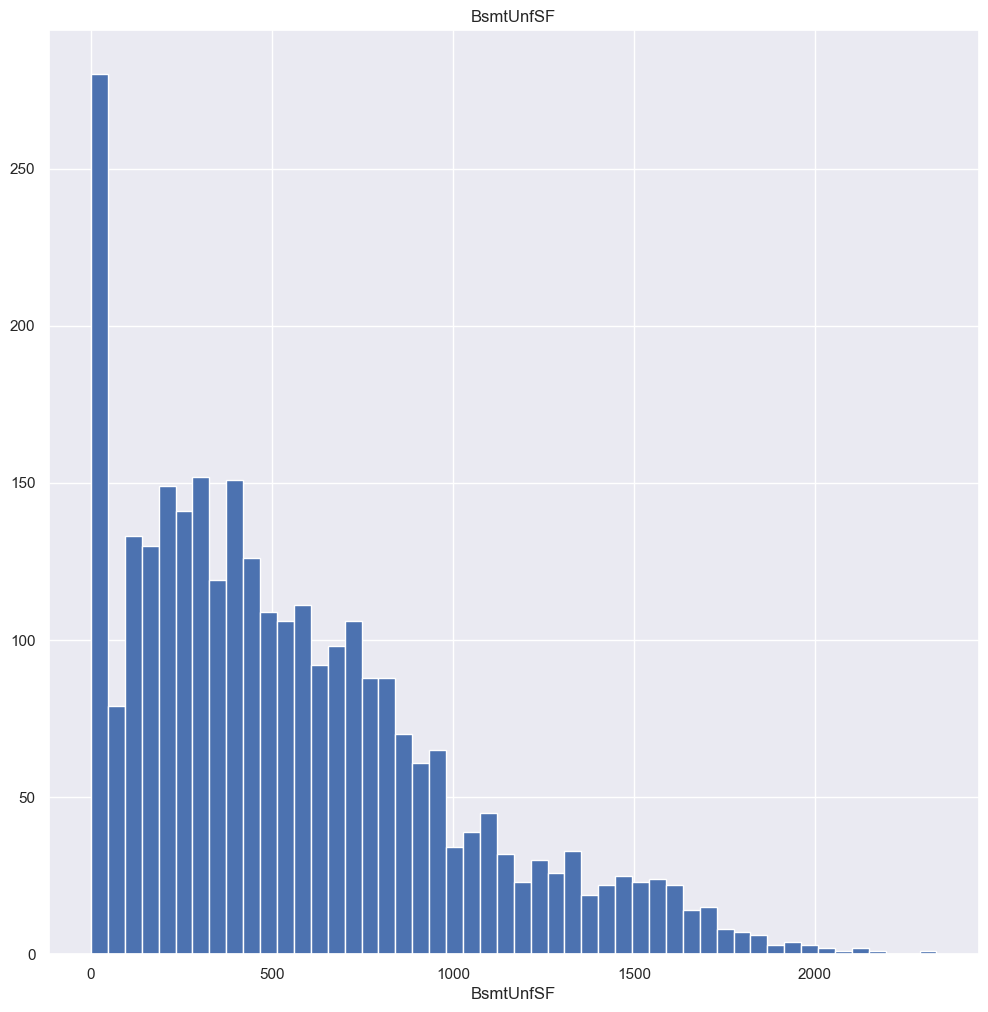

###########################
count   2918.000
mean    1051.778
std      440.766
min        0.000
5%       455.250
10%      600.000
20%      741.000
30%      836.000
40%      911.000
50%      989.500
60%     1089.200
70%     1216.000
80%     1392.000
90%     1614.000
95%     1776.150
99%     2198.300
max     6110.000
Name: TotalBsmtSF, dtype: float64


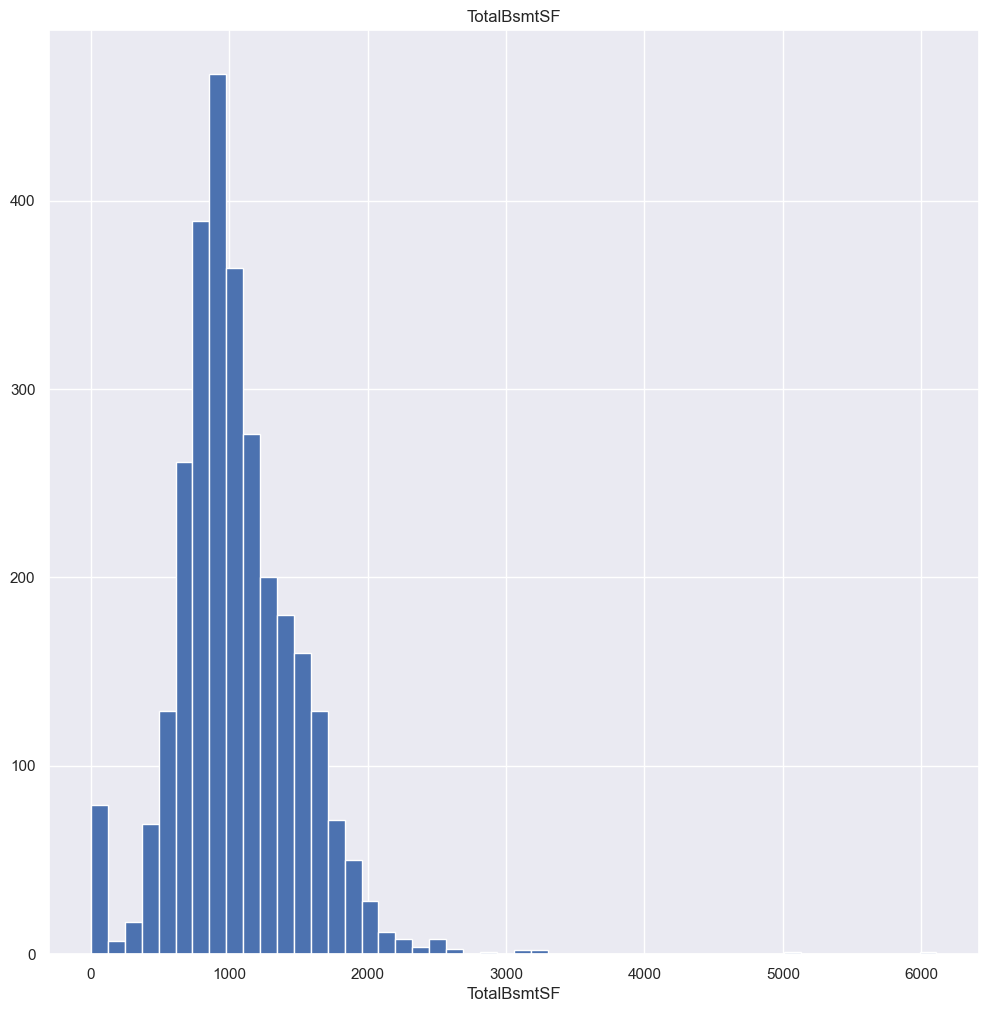

###########################
count   2919.000
mean    1159.582
std      392.362
min      334.000
5%       665.900
10%      744.800
20%      847.000
30%      914.000
40%      996.200
50%     1082.000
60%     1180.000
70%     1314.000
80%     1483.400
90%     1675.000
95%     1830.100
99%     2288.020
max     5095.000
Name: 1stFlrSF, dtype: float64


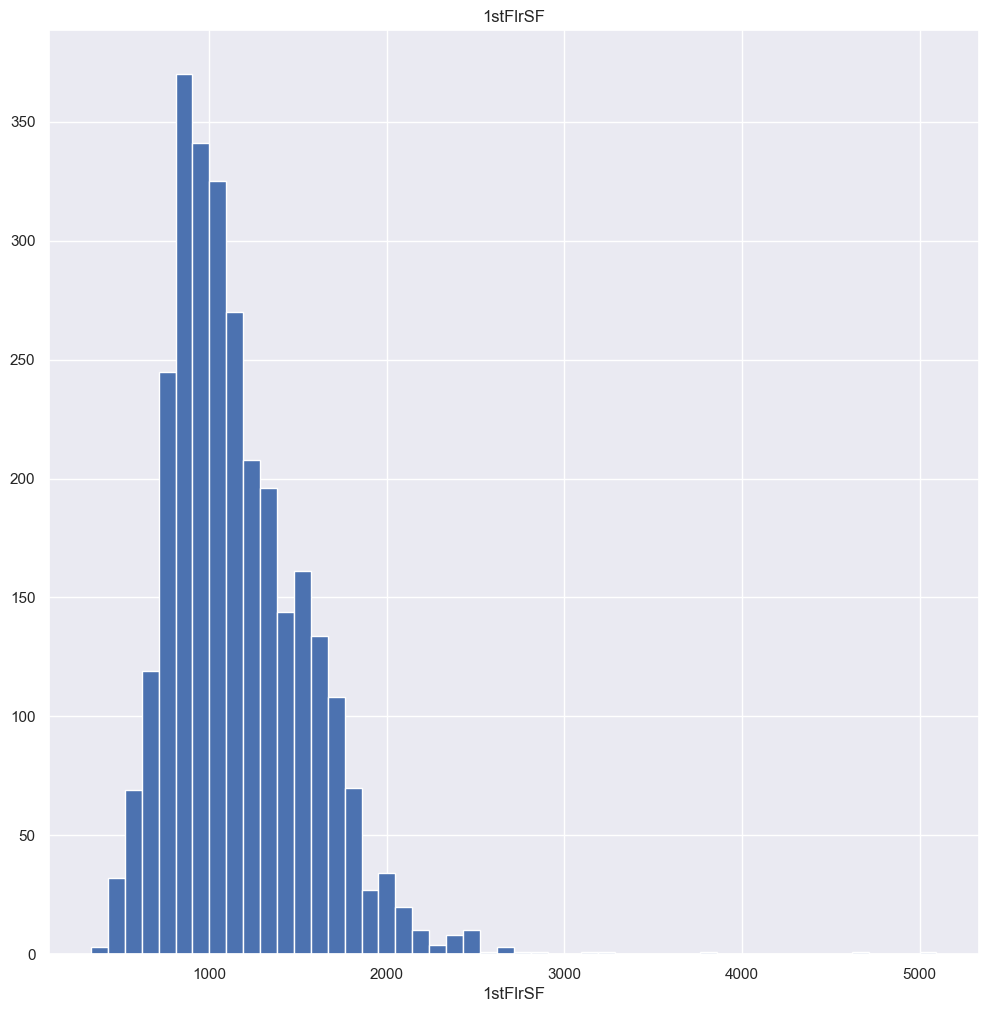

###########################
count   2919.000
mean     336.484
std      428.701
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      427.400
70%      636.000
80%      770.800
90%      925.000
95%     1131.200
99%     1400.200
max     2065.000
Name: 2ndFlrSF, dtype: float64


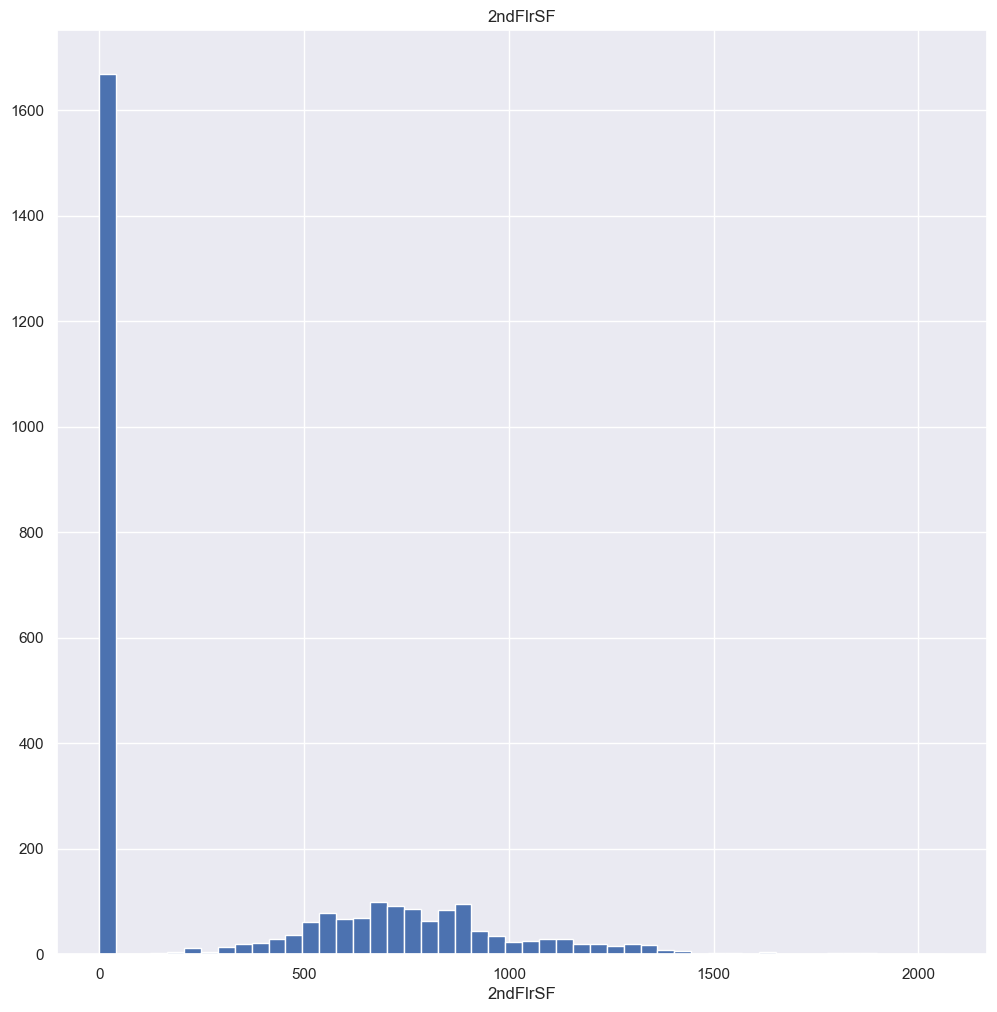

###########################
count   2919.000
mean       4.694
std       46.397
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      153.840
max     1064.000
Name: LowQualFinSF, dtype: float64


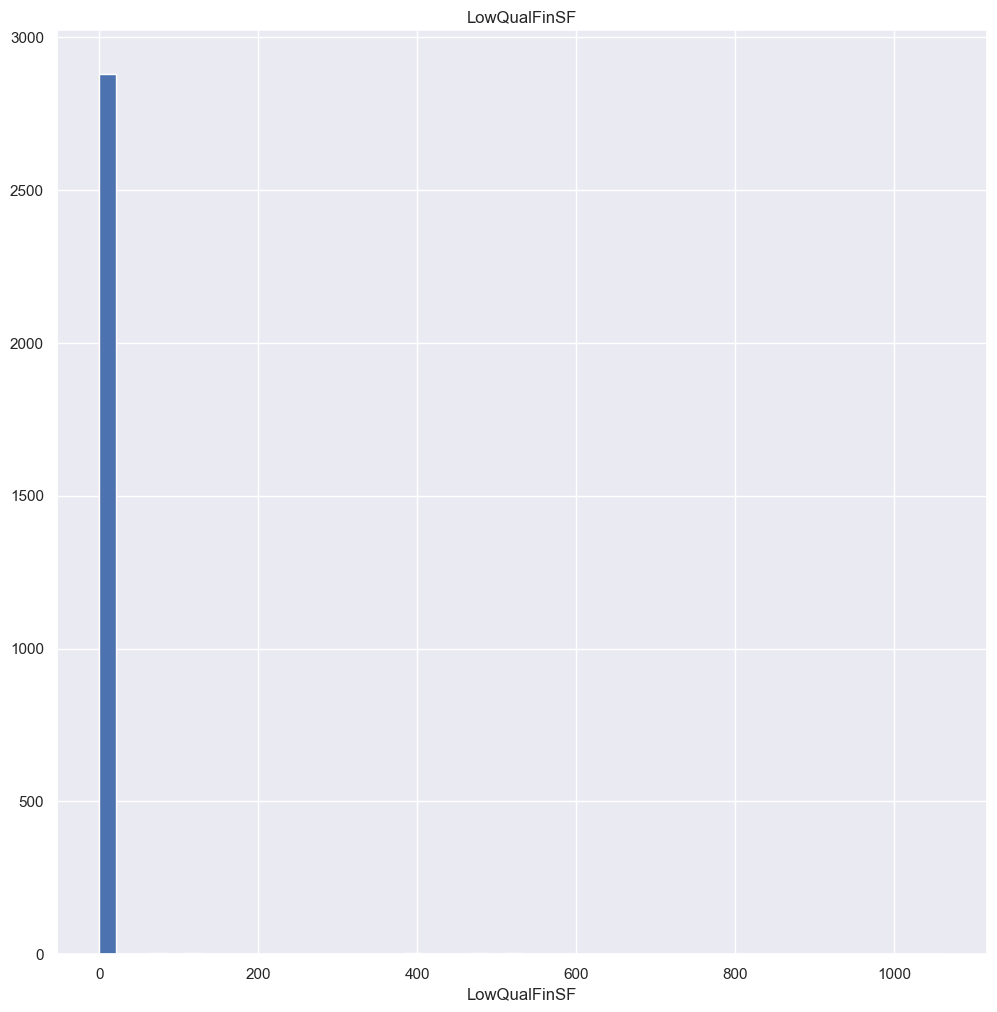

###########################
count   2919.000
mean    1500.760
std      506.051
min      334.000
5%       861.000
10%      923.800
20%     1064.600
30%     1200.000
40%     1329.200
50%     1444.000
60%     1560.000
70%     1680.000
80%     1838.400
90%     2153.200
95%     2464.200
99%     2935.720
max     5642.000
Name: GrLivArea, dtype: float64


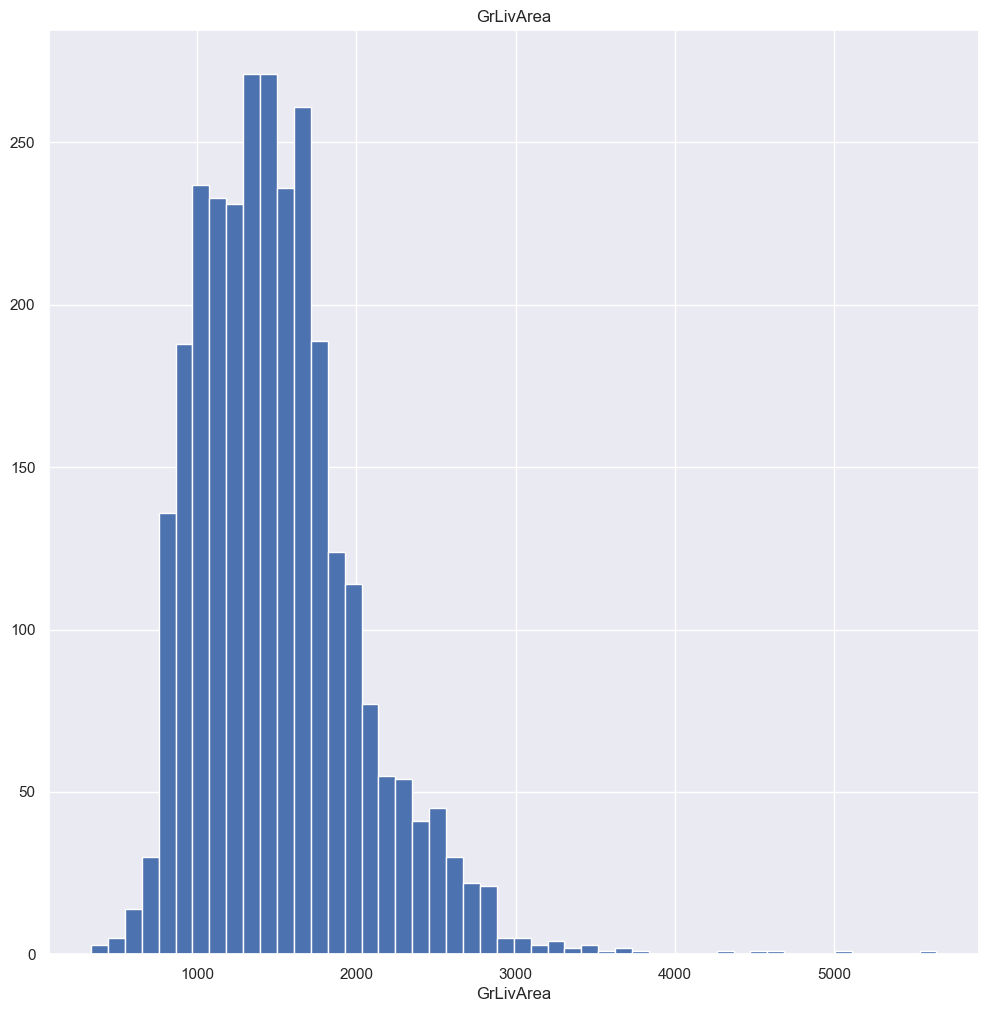

###########################
count   2919.000
mean       6.452
std        1.569
min        2.000
5%         4.000
10%        5.000
20%        5.000
30%        6.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%        8.000
95%        9.000
99%       11.000
max       15.000
Name: TotRmsAbvGrd, dtype: float64


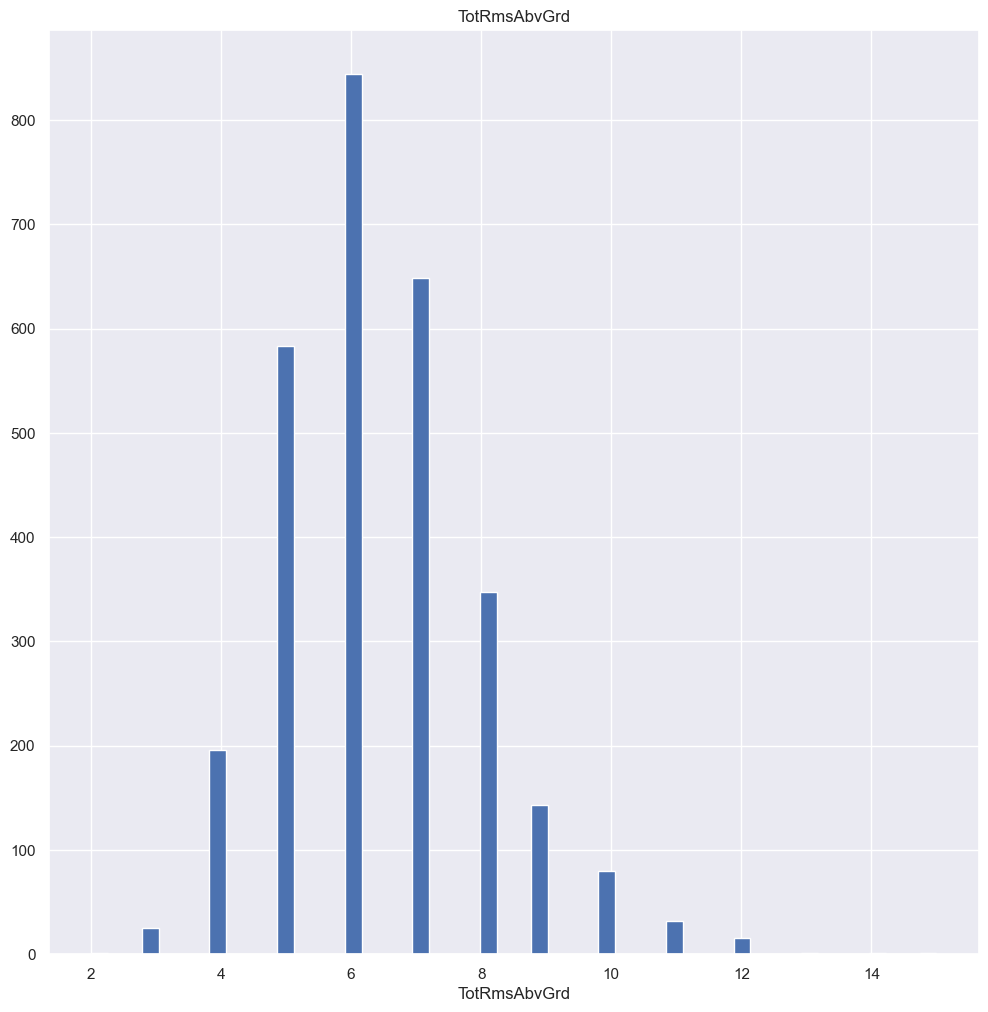

###########################
count   2760.000
mean    1978.113
std       25.574
min     1895.000
5%      1928.000
10%     1941.000
20%     1957.000
30%     1964.000
40%     1972.000
50%     1979.000
60%     1993.000
70%     1999.000
80%     2004.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2207.000
Name: GarageYrBlt, dtype: float64


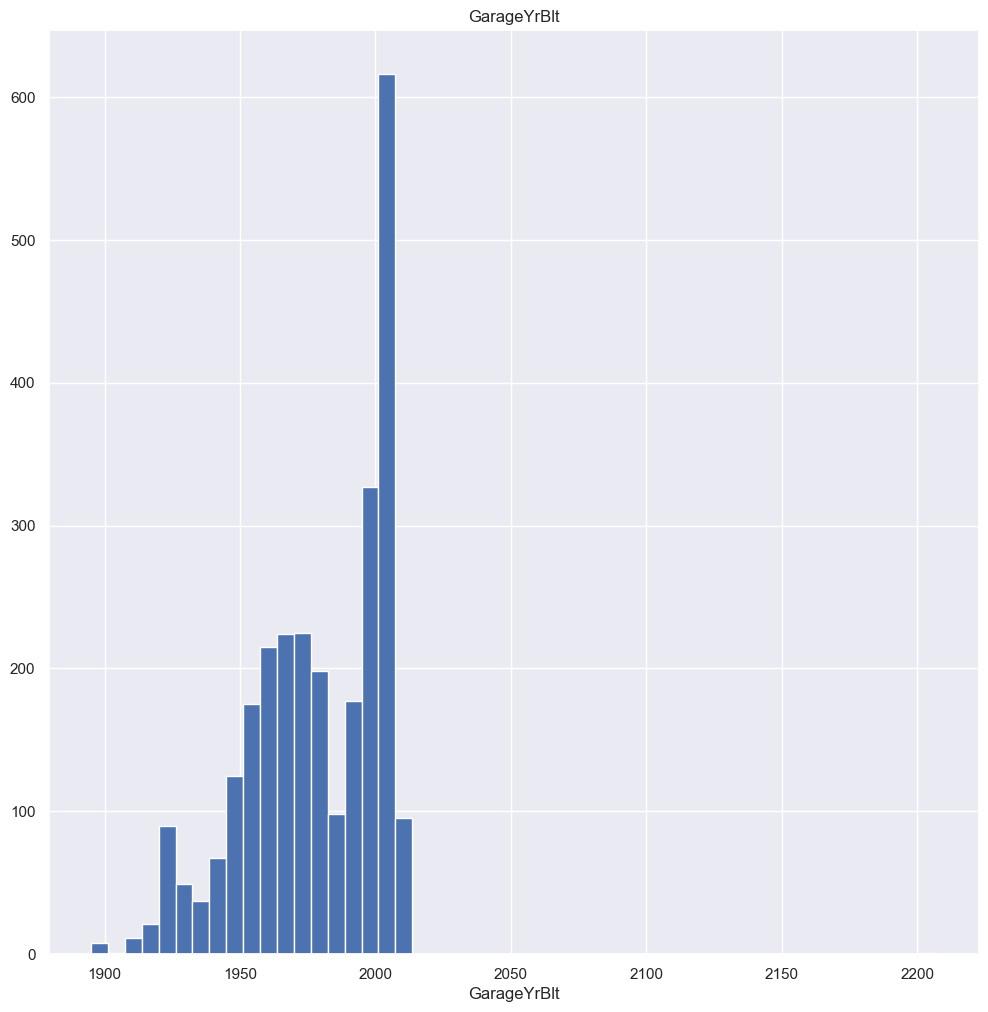

###########################
count   2918.000
mean     472.875
std      215.395
min        0.000
5%         0.000
10%      240.000
20%      296.000
30%      379.000
40%      440.000
50%      480.000
60%      513.000
70%      560.900
80%      621.000
90%      758.000
95%      856.150
99%     1019.490
max     1488.000
Name: GarageArea, dtype: float64


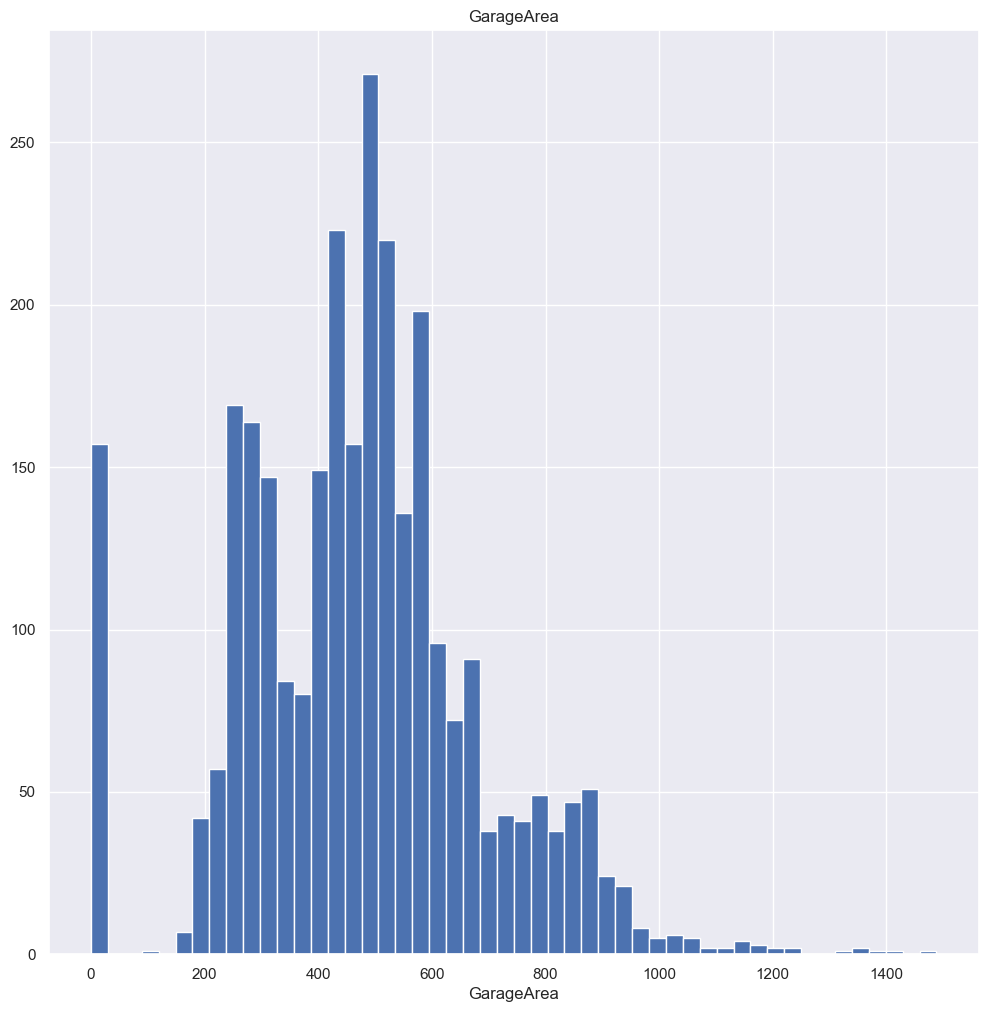

###########################
count   2919.000
mean      93.710
std      126.527
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      100.000
70%      144.000
80%      192.000
90%      257.000
95%      328.000
99%      500.820
max     1424.000
Name: WoodDeckSF, dtype: float64


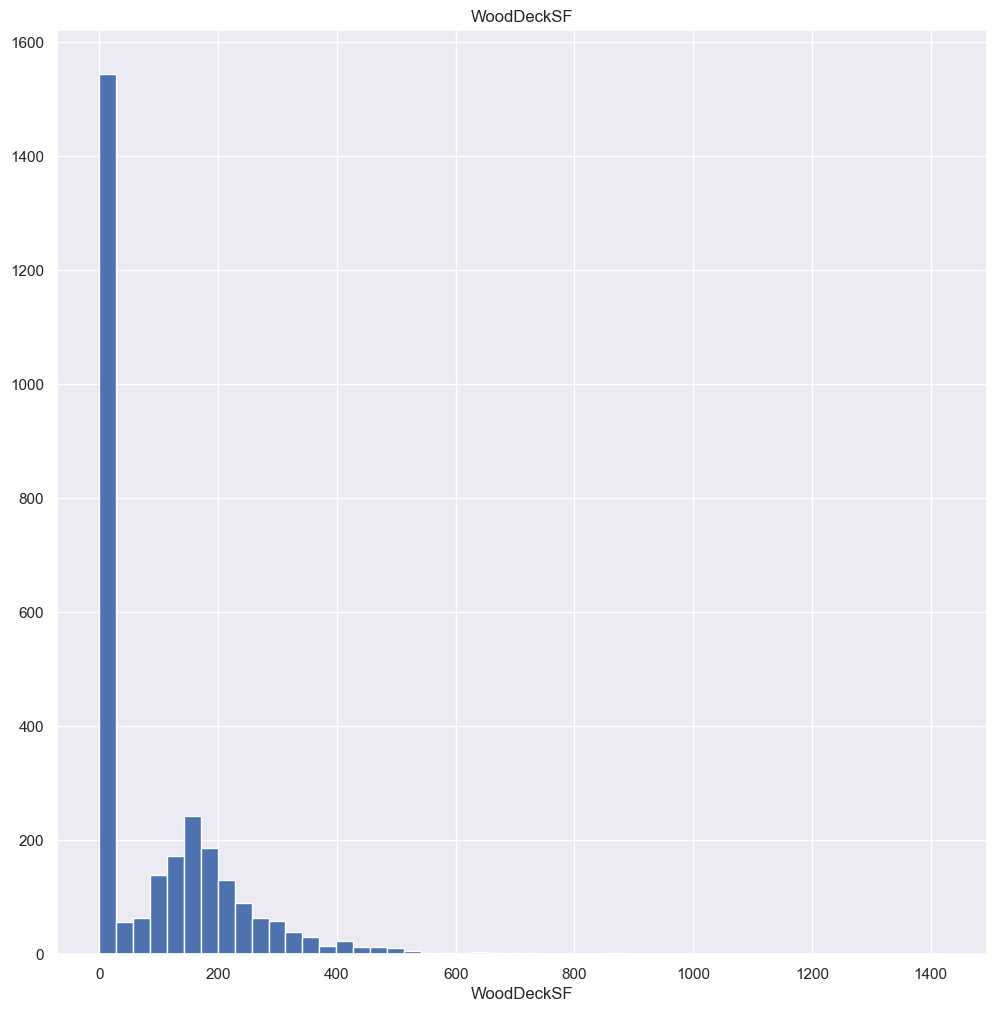

###########################
count   2919.000
mean      47.487
std       67.575
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%       26.000
60%       40.000
70%       58.000
80%       85.000
90%      131.200
95%      183.100
99%      284.460
max      742.000
Name: OpenPorchSF, dtype: float64


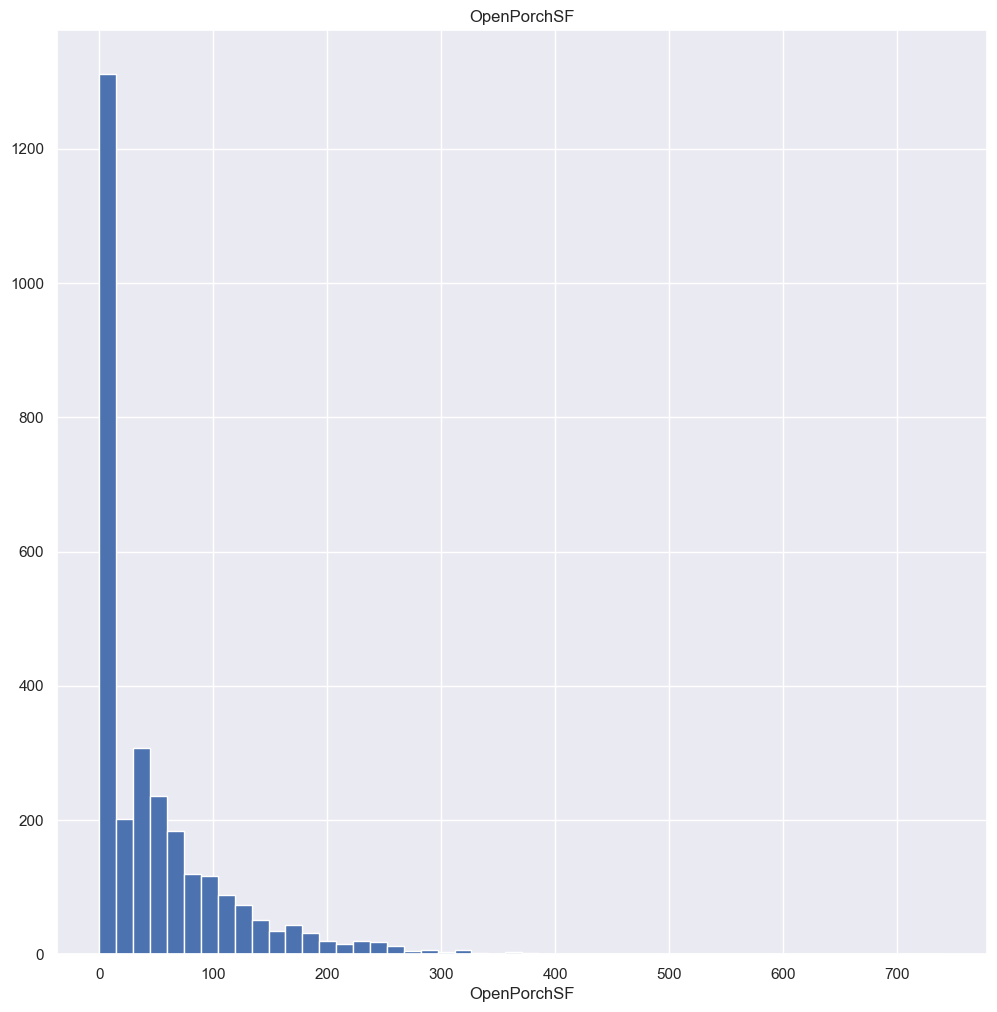

###########################
count   2919.000
mean      23.098
std       64.244
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      112.000
95%      176.000
99%      264.000
max     1012.000
Name: EnclosedPorch, dtype: float64


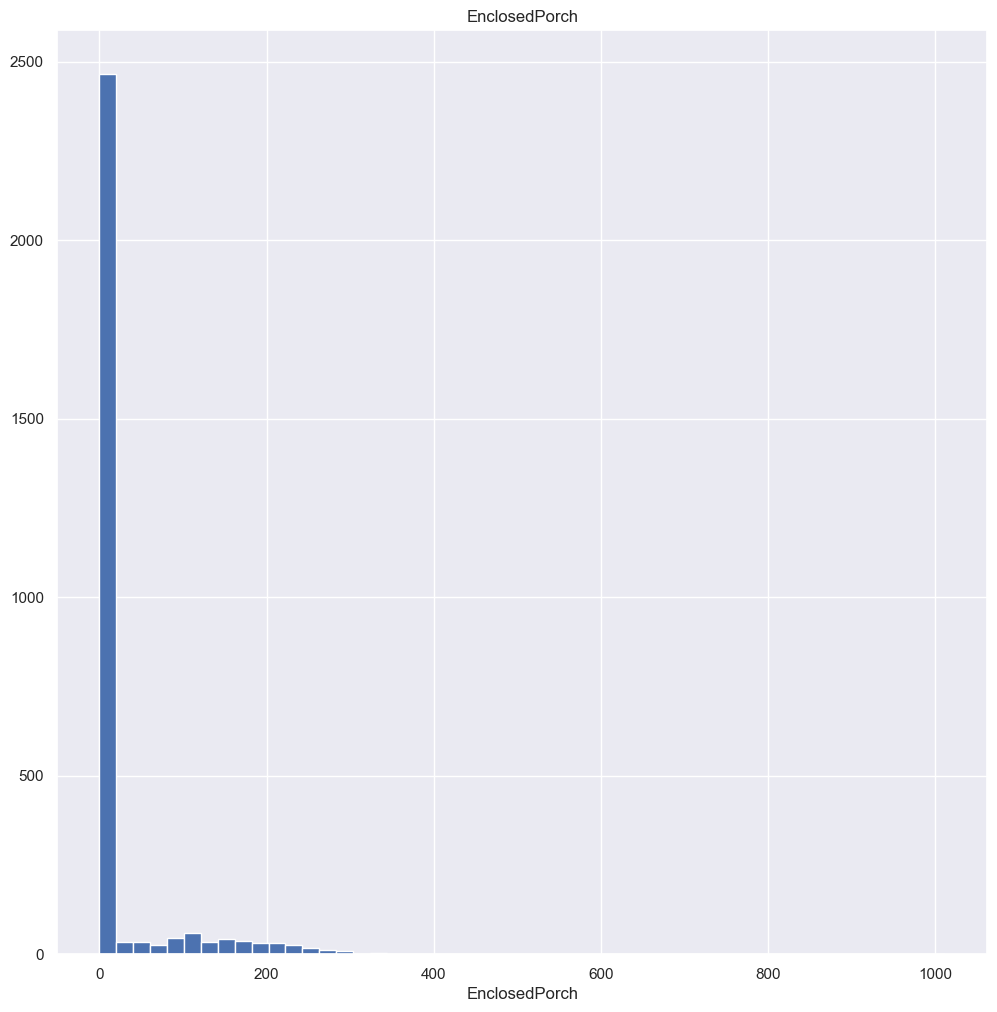

###########################
count   2919.000
mean       2.602
std       25.188
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      144.000
max      508.000
Name: 3SsnPorch, dtype: float64


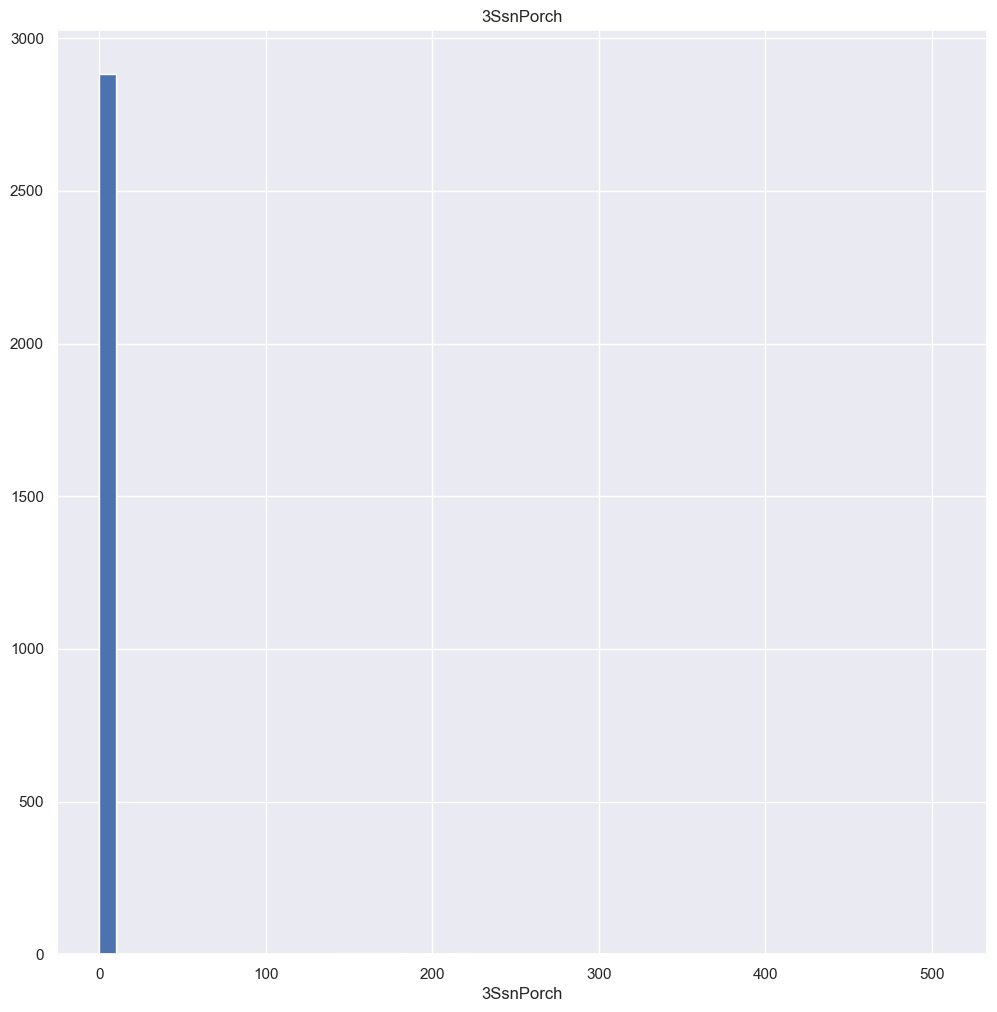

###########################
count   2919.000
mean      16.062
std       56.184
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%      161.000
99%      259.820
max      576.000
Name: ScreenPorch, dtype: float64


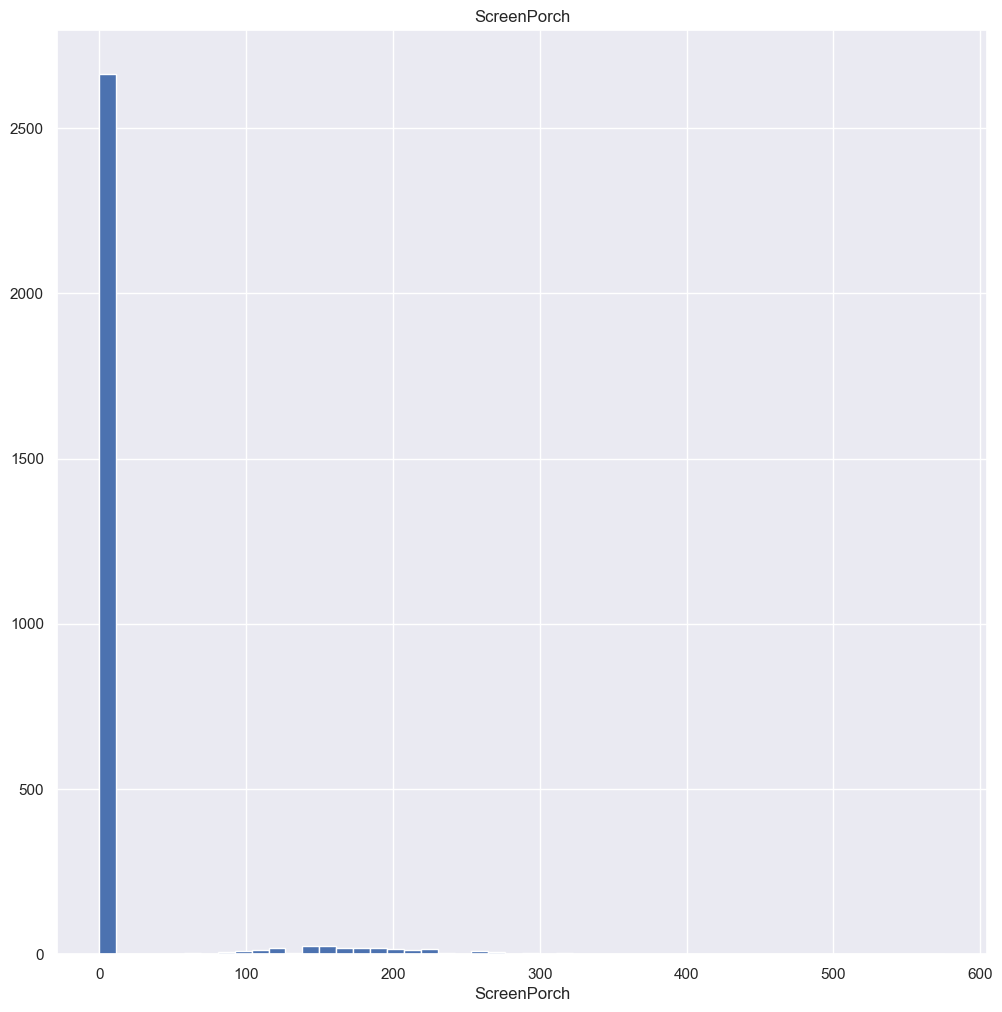

###########################
count   2919.000
mean       2.252
std       35.664
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%        0.000
max      800.000
Name: PoolArea, dtype: float64


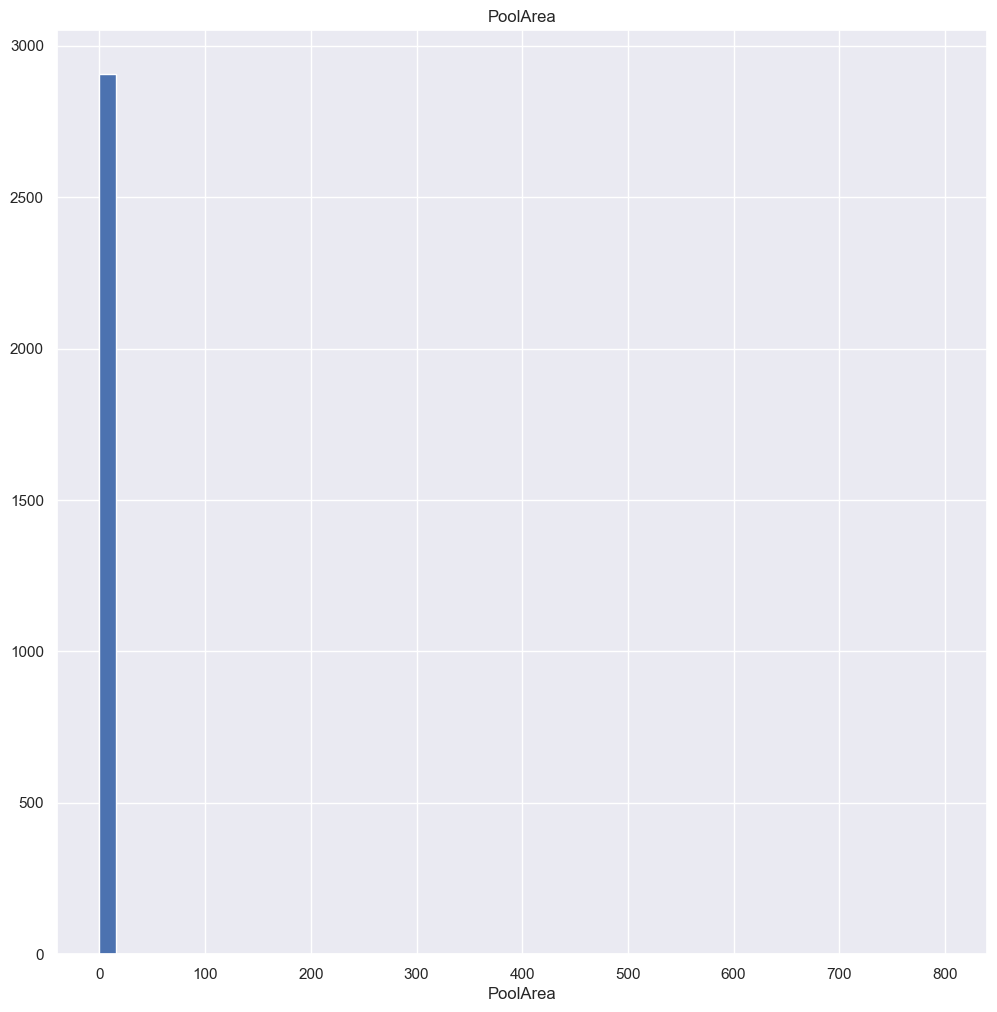

###########################
count    2919.000
mean       50.826
std       567.402
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       982.000
max     17000.000
Name: MiscVal, dtype: float64


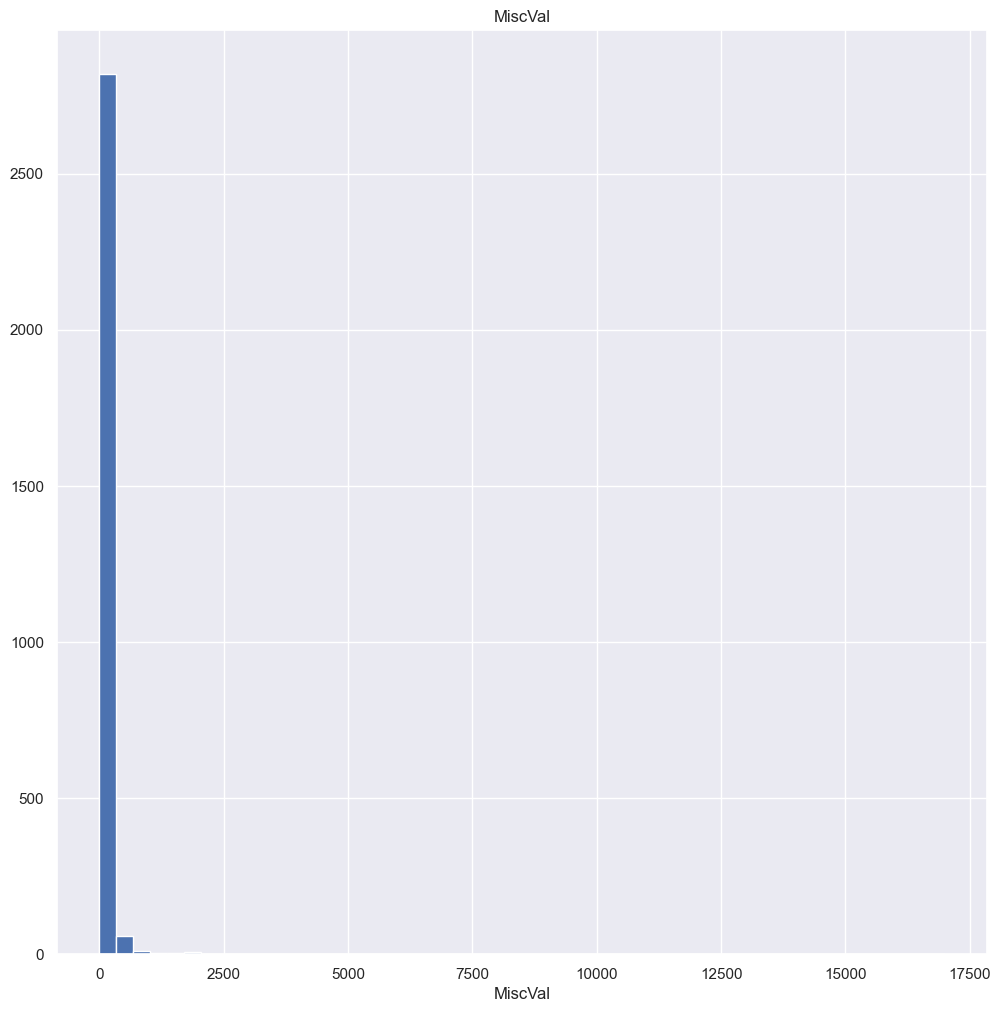

###########################
count   2919.000
mean       6.213
std        2.715
min        1.000
5%         2.000
10%        3.000
20%        4.000
30%        5.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%       10.000
95%       11.000
99%       12.000
max       12.000
Name: MoSold, dtype: float64


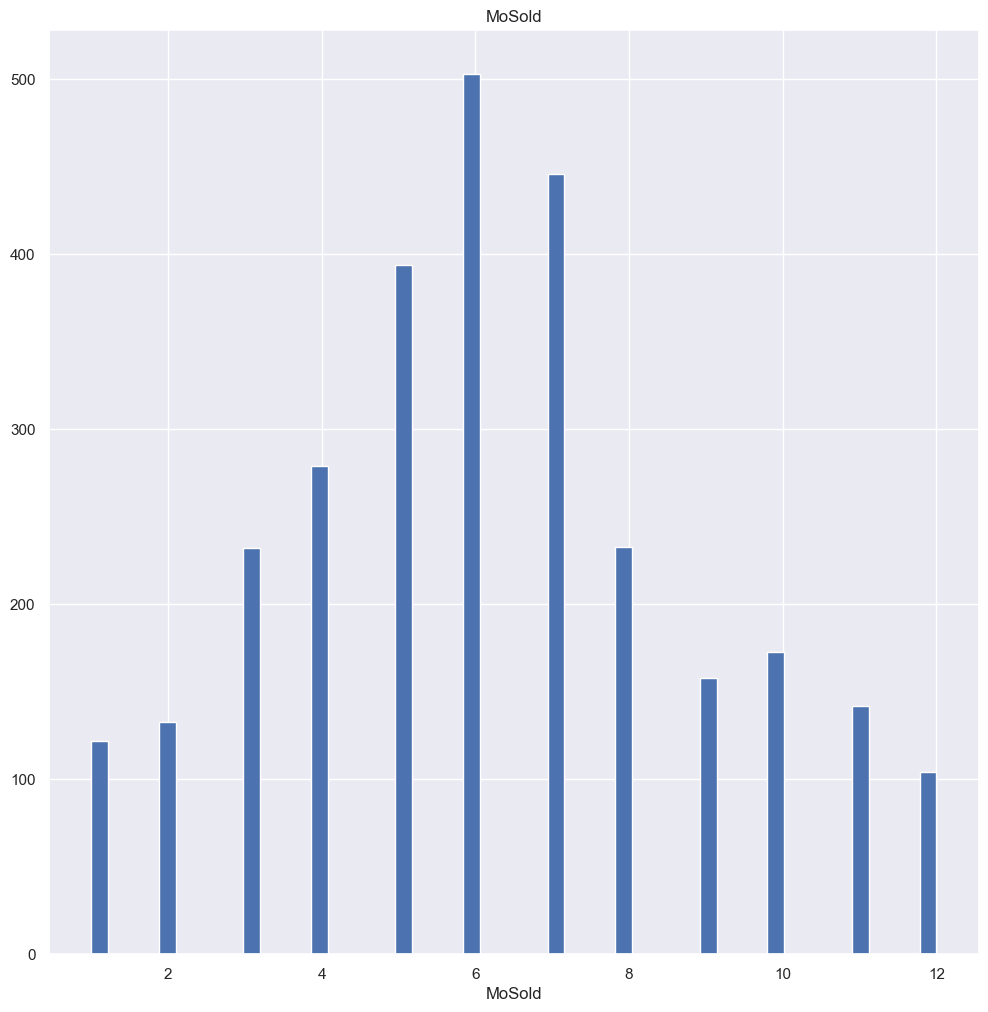

###########################
count     1460.000
mean    180921.196
std      79442.503
min      34900.000
5%       88000.000
10%     106475.000
20%     124000.000
30%     135500.000
40%     147000.000
50%     163000.000
60%     179280.000
70%     198620.000
80%     230000.000
90%     278000.000
95%     326100.000
99%     442567.010
max     755000.000
Name: SalePrice, dtype: float64


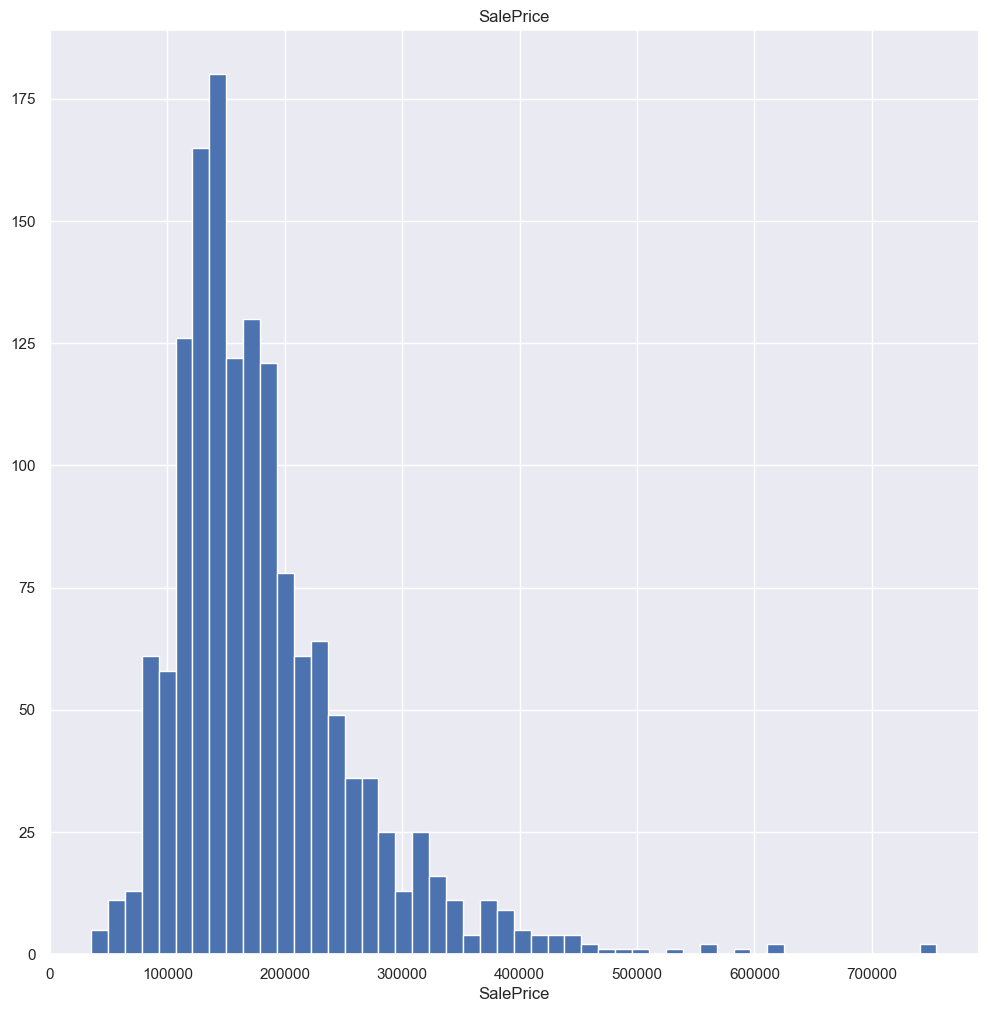

###########################


In [87]:
def num_sumamry(dataframe, numerical_col, plot=True):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

    print("###########################")

for col in num_cols:
    num_sumamry(df, col, True)

Hedef Değişken Analizi

In [88]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}),end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df,"SalePrice",col)

          TARGET_MEAN
MSZoning             
C (all)     74528.000
FV         214014.062
RH         131558.375
RL         191004.995
RM         126316.830


        TARGET_MEAN
Street             
Grvl     130190.500
Pave     181130.539


       TARGET_MEAN
Alley             
Grvl    122219.080
Pave    168000.585


          TARGET_MEAN
LotShape             
IR1        206101.665
IR2        239833.366
IR3        216036.500
Reg        164754.818


             TARGET_MEAN
LandContour             
Bnk           143104.079
HLS           231533.940
Low           203661.111
Lvl           180183.747


           TARGET_MEAN
Utilities             
AllPub      180950.957
NoSeWa      137500.000


           TARGET_MEAN
LotConfig             
Corner      181623.426
CulDSac     223854.617
FR2         177934.574
FR3         208475.000
Inside      176938.048


           TARGET_MEAN
LandSlope             
Gtl         179956.800
Mod         196734.138
Sev         204379.231


            TARGET_MEAN


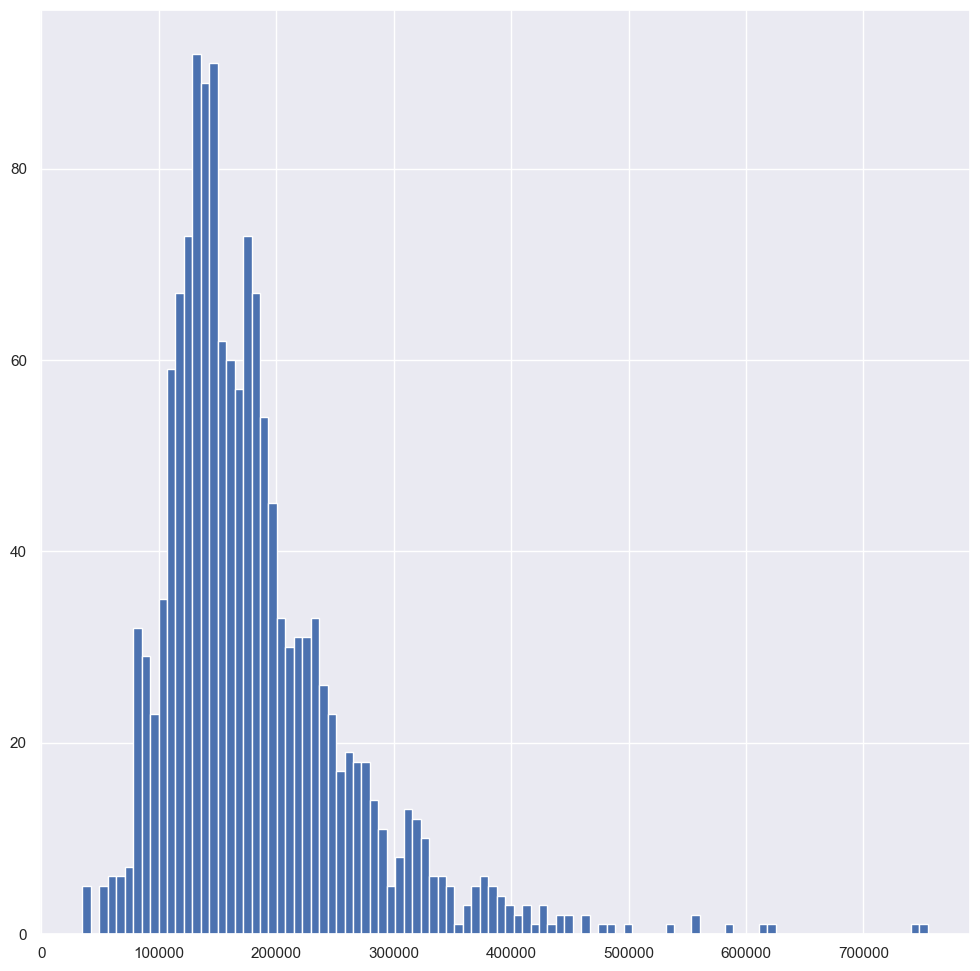

In [89]:
# Başarılı değişkenin incelenmesi
df["SalePrice"].hist(bins=100)
plt.show(block=True)

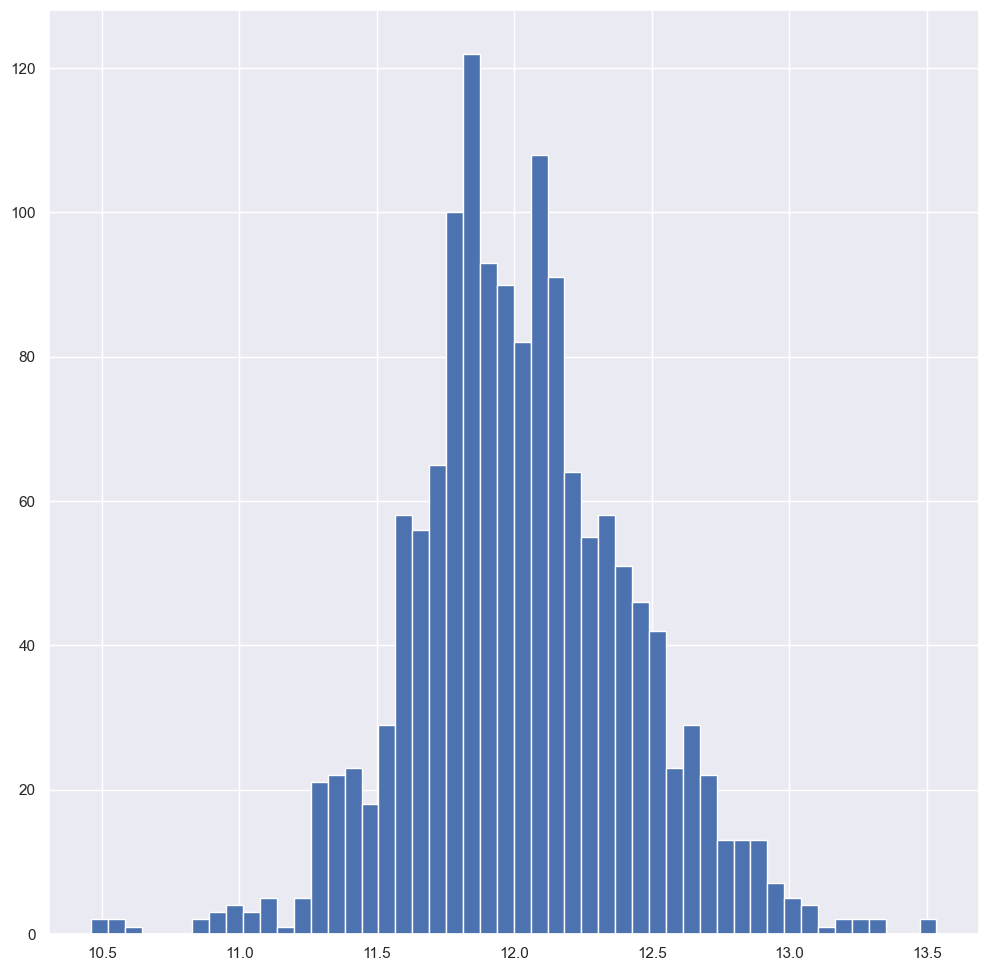

In [90]:
#Bağımlı değişkenin logaritmasının incelenmesi
np.log1p(df["SalePrice"]).hist(bins=50)
plt.show(block=True)

Korelasyon Analizi

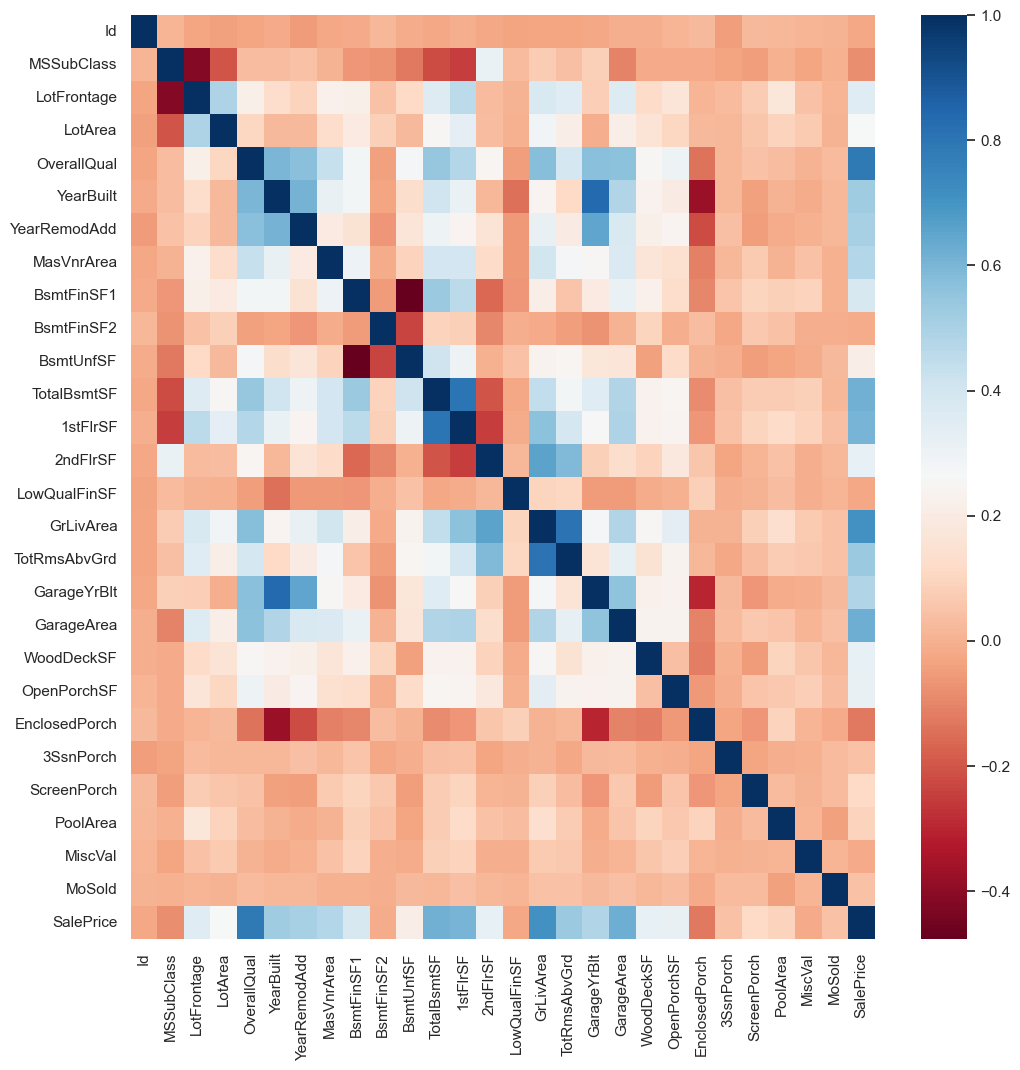

In [91]:
corr = df[num_cols].corr()
corr
sns.set_theme(rc={'figure.figsize':(12,12)})
sns.heatmap(corr,cmap="RdBu")
plt.show()

FUTURE ENGINEERING

Aykırı Değer Analizi

In [97]:
def outlier_thresholds(dataframe, variable, low_quantile=0.1, up_quantile=0.9):
    quantile_one=dataframe[variable].quantile(low_quantile)
    quantile_three=dataframe[variable].quantile(up_quantile)
    interquantile_range=quantile_three-quantile_one
    up_limit=quantile_three+1.5*interquantile_range
    low_limit=quantile_one-1.5*interquantile_range
    return low_limit,up_limit

In [98]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit)].any(axis=None):
        return True
    else:
        return False

In [99]:
for col in num_cols:
    if col != "SalePrice":
        print(col, check_outlier(df,col))

Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


Aykırı değerlerin baskılanması

In [100]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable]<low_limit),variable] = low_limit
    dataframe.loc[(dataframe[variable]>up_limit),variable]=up_limit

In [101]:
for col in num_cols:
    if col!="SalePrice":
        replace_with_thresholds(df,col)

Eksik Değer Analizi

In [106]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)


df["Alley"].value_counts()
df["BsmtQual"].value_counts()

              n_miss  ratio
PoolQC          2909 99.660
MiscFeature     2814 96.400
Alley           2721 93.220
Fence           2348 80.440
MasVnrType      1766 60.500
SalePrice       1459 49.980
FireplaceQu     1420 48.650
LotFrontage      486 16.650
GarageCond       159  5.450
GarageYrBlt      159  5.450
GarageFinish     159  5.450
GarageQual       159  5.450
GarageType       157  5.380
BsmtExposure      82  2.810
BsmtCond          82  2.810
BsmtQual          81  2.770
BsmtFinType2      80  2.740
BsmtFinType1      79  2.710
MasVnrArea        23  0.790
MSZoning           4  0.140
Functional         2  0.070
BsmtHalfBath       2  0.070
BsmtFullBath       2  0.070
Utilities          2  0.070
KitchenQual        1  0.030
TotalBsmtSF        1  0.030
BsmtUnfSF          1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
BsmtFinSF2         1  0.030
BsmtFinSF1         1  0.030
Exterior2nd        1  0.030
Exterior1st        1  0.030
SaleType           1  0.030
Electrical         1

BsmtQual
TA    1283
Gd    1209
Ex     258
Fa      88
Name: count, dtype: int64

In [107]:
# Bazı değişkenlerdeki boş değerler evin o özelliğe sahip olmadığını ifade etmektedir
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

In [108]:
# Kolonlardakş boşlukların "No" ifadesi ile doldurulması
for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)

              n_miss  ratio
MasVnrType      1766 60.500
SalePrice       1459 49.980
LotFrontage      486 16.650
GarageYrBlt      159  5.450
MasVnrArea        23  0.790
MSZoning           4  0.140
BsmtFullBath       2  0.070
BsmtHalfBath       2  0.070
Functional         2  0.070
Utilities          2  0.070
Exterior2nd        1  0.030
BsmtFinSF1         1  0.030
BsmtFinSF2         1  0.030
BsmtUnfSF          1  0.030
Exterior1st        1  0.030
Electrical         1  0.030
KitchenQual        1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
SaleType           1  0.030
TotalBsmtSF        1  0.030


In [ ]:
# Bu fonsksiyon eksik değerlerin median veya mean ile doldurulmasını sağlar
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0] # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x,axis=0)

    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

df = quick_missing_imp(df, num_method="median", cat_length=17)



# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType      

In [110]:
# Kategorik kolonların dağılımının incelenmesi

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
          COUNT  RATIO  TARGET_MEAN
MSZoning                           
C (all)      25  0.009    74528.000
FV          139  0.048   214014.062
RH           26  0.009   131558.375
RL         2269  0.777   191004.995
RM          460  0.158   126316.830


Street : 2
        COUNT  RATIO  TARGET_MEAN
Street                           
Grvl       12  0.004   130190.500
Pave     2907  0.996   181130.539


Alley : 3
       COUNT  RATIO  TARGET_MEAN
Alley                           
Grvl     120  0.041   122219.080
No      2721  0.932   183452.131
Pave      78  0.027   168000.585


LotShape : 4
          COUNT  RATIO  TARGET_MEAN
LotShape                           
IR1         968  0.332   206101.665
IR2          76  0.026   239833.366
IR3          16  0.005   216036.500
Reg        1859  0.637   164754.818


LandContour : 4
             COUNT  RATIO  TARGET_MEAN
LandContour                           
Bnk            117  0.040   143104.079
HLS            120  0.041   231533.940
Low 

In [113]:
# Nadir sınıfların tespit edilmesi
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O"
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    
    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var])

    return temp_df

rare_encoder(df,0.01)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.000,60,RL,65.000,8450.000,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.000,5,2003,2003.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,GasA,Ex,Y,SBrkr,856.000,854.000,0,1710.000,1.000,0.000,2,1,3,1,Gd,8.000,Typ,0,No,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0.000,61.000,0,0,0,0,No,No,No,0,2.000,2008,WD,Normal,208500.000
1,2.000,20,RL,80.000,9600.000,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Rare,Feedr,Norm,1Fam,1Story,6.000,8,1976,1976.000,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,GasA,Ex,Y,SBrkr,1262.000,0.000,0,1262.000,0.000,1.000,2,0,3,1,TA,6.000,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298.000,0.000,0,0,0,0,No,No,No,0,5.000,2007,WD,Normal,181500.000
2,3.000,60,RL,68.000,11250.000,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.000,5,2001,2002.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000,Unf,0.000,434.000,920.000,GasA,Ex,Y,SBrkr,920.000,866.000,0,1786.000,1.000,0.000,2,1,3,1,Gd,6.000,Typ,1,TA,Attchd,2001.000,RFn,2.000,608.000,TA,TA,Y,0.000,42.000,0,0,0,0,No,No,No,0,9.000,2008,WD,Normal,223500.000
3,4.000,70,RL,60.000,9550.000,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.000,5,1915,1970.000,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000,Unf,0.000,540.000,756.000,GasA,Gd,Y,SBrkr,961.000,756.000,0,1717.000,1.000,0.000,1,0,3,1,Gd,7.000,Typ,1,Gd,Detchd,1998.000,Unf,3.000,642.000,TA,TA,Y,0.000,35.000,272,0,0,0,No,No,No,0,2.000,2006,WD,Abnorml,140000.000
4,5.000,60,RL,84.000,14260.000,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.000,5,2000,2000.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000,Unf,0.000,490.000,1145.000,GasA,Ex,Y,SBrkr,1145.000,1053.000,0,2198.000,1.000,0.000,2,1,4,1,Gd,9.000,Typ,1,TA,Attchd,2000.000,RFn,3.000,836.000,TA,TA,Y,192.000,84.000,0,0,0,0,No,No,No,0,12.000,2008,WD,Normal,250000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915.000,160,RM,21.000,1936.000,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4.000,7,1970,1970.000,Gable,CompShg,CemntBd,CmentBd,BrkFace,0.000,TA,TA,CBlock,TA,TA,No,Unf,0.000,Unf,0.000,546.000,546.000,GasA,Gd,Y,SBrkr,546.000,546.000,0,1092.000,0.000,0.000,1,1,3,1,TA,5.000,Typ,0,No,No,1979.000,No,0.000,0.000,No,No,Y,0.000,0.000,0,0,0,0,No,No,No,0,6.000,2006,WD,Normal,NaN
2915,2916.000,160,RM,21.000,1894.000,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.000,5,1970,1970.000,Gable,CompShg,CemntBd,CmentBd,BrkFace,0.000,TA,TA,CBlock,TA,TA,No,Rec,252.000,Unf,0.000,294.000,546.000,GasA,TA,Y,SBrkr,546.000,546.000,0,1092.000,0.000,0.000,1,1,3,1,TA,6.000,Typ,0,No,Rare,1970.000,Unf,1.000,286.000,TA,TA,Y,0.000,24.000,0,0,0,0,No,No

In [118]:
# Yeni değişkenler oluşturunuz ve oluşturduğunuz yeni değişkenlerin başına 'NEW' ekleyiniz.

df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]

df["NEW_Garage*GrLiv"] = (df["GarageArea"] * df["GrLivArea"])

df["TotalQual"] = df[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence"]].sum(axis = 1, numeric_only=True) # 42


# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] # 32

# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2 # 56

# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF # 93

# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF # 156

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF # 35


# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea # 64

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea # 57

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea # 69

# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea # 36

# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF) # 73


df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"] # 61


df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt # 31

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt # 73

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd # 40

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt # 17

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd) # 30

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt # 48

In [119]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)

Label Encoding & One-Hot Encoding

In [120]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe

Observations: 2919
Variables: 92
cat_cols: 49
num_cols: 43
cat_but_car: 0
num_but_cat: 15


In [122]:
binary_cols=[col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

for col in binary_cols:
    label_encoder(df,col)

In [123]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df,cat_cols, drop_first=True)

MODELLEME

In [133]:
# Train ve Test verisini ayır. SalePrice boş olanlar test verisi
train_df = df[df["SalePrice"].notnull()]
test_df = df[df["SalePrice"].isnull()]

y= train_df["SalePrice"]
X=train_df.drop(["Id", "SalePrice"], axis=1)

# Train verisi ile model kurup, model başarısını değerlendir
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=17)

models = [('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror'))]
          #("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor, in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name})")

RMSE: 42586.9909 (LR)
RMSE: 47557.3947 (KNN)
RMSE: 39295.6404 (CART)
RMSE: 28878.9433 (RF)
RMSE: 26211.3815 (GBM)
RMSE: 27910.8172 (XGBoost)


In [136]:
df["SalePrice"].mean()
df["SalePrice"].std()

79442.50288288663

Değişkenlerin Önem Düzeyi

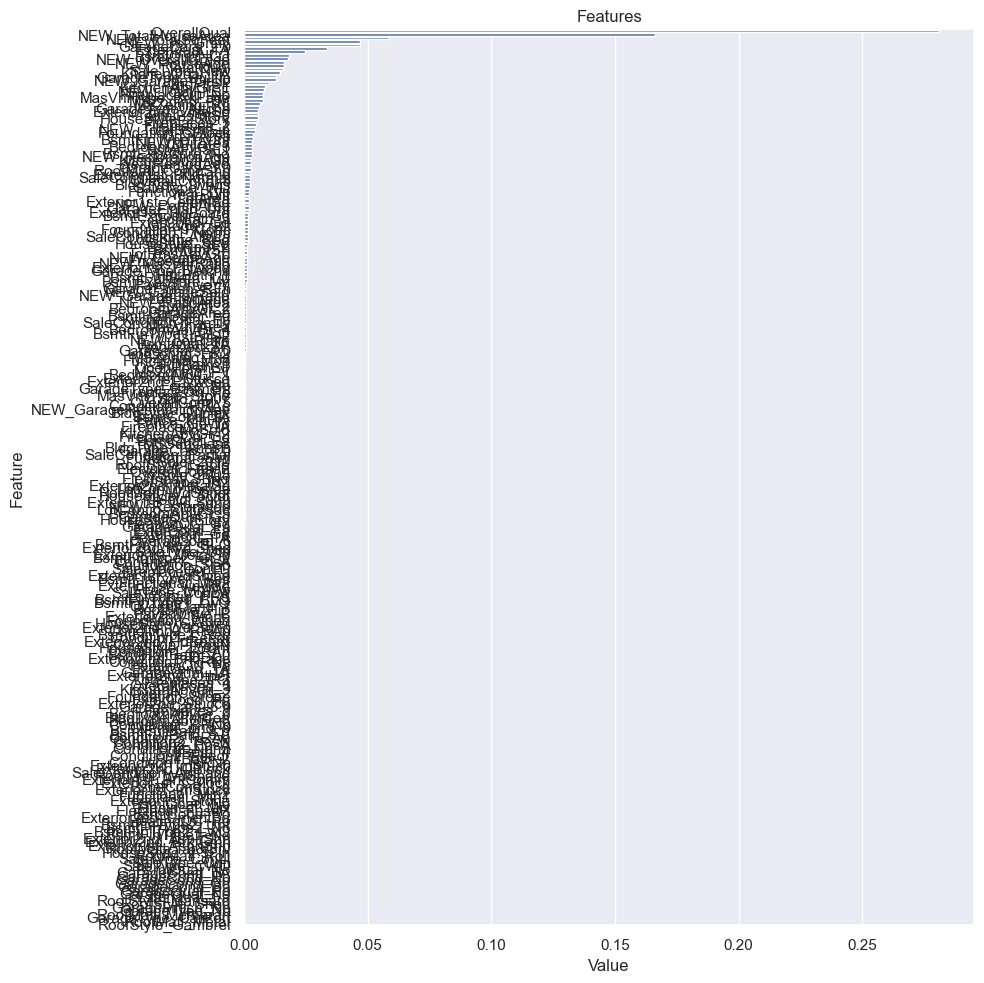

In [138]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = XGBRegressor()
model.fit(X,y)
plot_importance(model,X)